# This file is used to analyze real experiment data collected in December of 2022






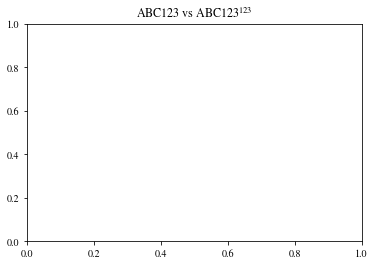

In [1]:
import pandas as pd
import numpy as np
import sys
import copy

import matplotlib.pyplot as plt
%matplotlib inline
# To change the default font like latex font
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

import itertools
import scipy.stats as stats

In [2]:
def countCommas(s):
    try:
        return s.count(',')
    except:
        return np.nan

# Content

- [Data Import](#Data-Import)
- [Define functions and important variables](#Define-functions-and-important-variables)
- [Start Data Analysis](#Start-Data-Analysis)


# Data Import

-[Return](#Content)

In [3]:
data_ABA= pd.read_csv('..\\ProcessedData\\data_ABA.csv')
data_BAB=pd.read_csv('..\\ProcessedData\\data_BAB.csv')

In [4]:
# Data with opportunity 
data_Oppor_B1 = pd.read_csv('..\\ProcessedData\\data_Oppor_B1.csv')
data_Oppor_allB = pd.read_csv('..\\ProcessedData\\data_Oppor_allB.csv')

In [5]:
# Data local only 
data_noOppor_AllA = pd.read_csv('..\\ProcessedData\\data_noOppor_AllA.csv')
data_noOppor_A2=pd.read_csv('..\\ProcessedData\\data_noOppor_A2.csv')

In [329]:
# Imported the counterfactual data
# path = '..//..//Model//SimulatedResults//16-IEL-Recap-With-2Modifications-Final-Simulations-Counterfactual//'
# name = 'BABp_0.4_b_34_g_8_fx_10'
# name = 'BABp_0.5_b_34_g_12'

# 
path = '..//..//Model//SimulatedResults//15-IEL-Recap-With-2Modifications-Final-Simulations-GridSearch//'
# # name = 'BABp_0.5_b_40_g_50' Only match join behavior:
# name = 'BABp_0.1_b_0_g_0'
name = 'BABp_0.5_b_34_g_12' #match 4 matrix
CounterfactualData = pd.read_csv(path+name+'.csv')

In [231]:
# CounterfactualData_cut = CounterfactualData[(CounterfactualData['FC']==20) | (CounterfactualData['FC']==80)]
CounterfactualData_cut

Unnamed: 0 Treatment  FC  subject_id  session_num  \
51200            0    HETERO  20           0            0   
51201            1    HETERO  20           0            0   
51202            2    HETERO  20           0            0   
51203            3    HETERO  20           0            0   
51204            4    HETERO  20           0            0   
...            ...       ...  ..         ...          ...   
511995          75      HOMO  80         319           19   
511996          76      HOMO  80         319           19   
511997          77      HOMO  80         319           19   
511998          78      HOMO  80         319           19   
511999          79      HOMO  80         319           19   

        player.local_community  endow_org Sequence  subsession.round_number  \
51200                        0         10   B1_bab                        1   
51201                        0         10   B1_bab                        2   
51202                        0         10   B1_bab                        3   
51203                        0         10   B1_bab                        4   
51204                        0         10   B1_bab                        5   
...                        ...        ...      ...                      ...   
511995                       3         20   B2_bab                       76   
511996                       3         20   B2_bab                       77   
511997                       3         20   B2_bab                       78   
511998                       3         20   B2_bab                       79   
511999                       3         20   B2_bab                       80   

        subsession.period  player.contribution_local  \
51200                   1                        0.0   
51201                   2                        0.0   
51202                   3                        5.0   
51203                   4                        0.0   
51204                   5                        0.0   
...                   ...                        ...   
511995                  6                        7.0   
511996                  7                        7.0   
511997                  8                        7.0   
511998                  9                       10.0   
511999                 10                       10.0   

        player.contribution_global  other_total_local  other_total_global  \
51200                          0.0               12.0                51.0   
51201                          8.0               28.0                 9.0   
51202                          NaN               21.0                15.0   
51203                          6.0                7.0                20.0   
51204                          0.0               27.0                45.0   
...                            ...                ...                 ...   
511995                         2.0               12.0                 2.0   
511996                         2.0               18.0                 3.0   
511997                         2.0               19.0                 2.0   
511998                         2.0               18.0                 2.0   
511999                         2.0               18.0                 2.0   

        player.payoff  
51200            45.8  
51201            27.0  
51202            20.6  
51203            21.8  
51204            51.2  
...               ...  
511995           16.8  
511996           21.0  
511997           21.0  
511998           19.2  
511999           19.2  

[102400 rows x 15 columns]

# Define functions and important variables 

-[Return](#Content)


In [6]:
def bootstrap_ci(data, n_samples, stat):
    
    n = len(data)                                #get length of the data
    ix = np.random.randint(0, n, (n_samples, n)) #get an array of bootsrapped indices
    samples = data[ix]                           #create bootrapped samples
    
    distribution = stat(samples, axis=1)

    return (np.percentile(distribution,2.5),np.percentile(distribution,97.5))

In [7]:
def permutation_test_r(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    original_stat=np.mean(sample1)-np.mean(sample2)
    print("Original Statistic:",original_stat)
    combined=np.append(sample1,sample2)
    #print combined
    permutations=np.matrix(list(itertools.permutations(combined)))
    print(permutations)
    n_permut=len(permutations)
    print("Number of permutations:",len(permutations))
    distr=permutations[:,0:n1].mean(axis=1)-permutations[:,n1:n1+n2].mean(axis=1)
    count=(distr<=original_stat).sum()
    print("Count: ",count," out of ",n_permut)
    p_val=np.round(float(count)/float(n_permut),3)
    print("Probability: ",p_val)

In [8]:
def permutation_test(pop_a, pop_b):

    original_statistics = pop_a.mean() - pop_b.mean()
    print(original_statistics)

    print('# 2. use permutation test (non-parametric test)' )
    n1 = len(pop_a)
    n2 = len(pop_b)
    
    sim_num = 10000
    
    combined = np.append(pop_a, pop_b)
#     permutationss=np.matrix(list(permutations(combined)))
#     n_permut=len(permutationss)
    n = len(combined)
    idx = np.arange(n)
    sim_d = []
    for i in range(sim_num):
        np.random.shuffle(idx)
        d = np.mean(combined[idx][0:n1]) - np.mean(combined[idx][n1::])
    #     print(d)
        sim_d.append(d)
    # calculate the p-value for two-sided test:
    count = (np.abs(sim_d)>=np.abs(original_statistics)).sum()
    # calculate the one-sided test, first-second
#     count = (np.array(sim_d)>=original_statistics).sum()
#     print(count)
    p_val = np.round((count+1)/(sim_num+1), 3)
    print("p-value for two-sided test", p_val)
    
#     distr=np.array(np.ma.mean(permutationss[:,0:n1],1)-np.ma.mean(permutationss[:,n1:n1+n2],1))
# #     count=(distr<=original_statistics).sum()
#     count=(np.abs(distr)>=np.abs(original_statistics)).sum()
#     print("Permutation Count: ",count," out of ",n_permut)
#     p_val=np.round(float(count)/float(n_permut),3)
#     print("two-sided Probability: ",p_val)


In [9]:
def CreateMean_CI_byHypothese(data, var, treatment_var, treatment_list, totalR):
    all_data = data
    # Create a matrix for 3 outputs: mean, upper CI, lower CI
    # The size is #Rounds * #Treatments
    output = np.empty((3, totalR, len(treatment_list)))
    output[:]=np.nan
    
    for i,t in enumerate(treatment_list): # Fixed the treatment order
        for r in range(1,totalR+1):
            pop_a = all_data.loc[(all_data[treatment_var]==t) & (all_data['subsession.period']==r), var]

            if not pop_a.empty :
                output[0,r-1,i] = pop_a.mean()
                output[1,r-1,i],output[2,r-1,i] = bootstrap_ci(np.array(pop_a), 10000, np.mean)
            else : 
                pass
    return output

# Start Data Analysis

Sequence : [7, 6, 18, 17, 13, 8, 12, 7]

A1 = [7] (10 rounds)

B1 = [6,18,17]

A2 = [13]

B2 = [8]

-[Order Effect](#Order-effect)

-[Compare Local and Global](#Compare-Local-and-Global)

-[Local Only Environment ](#Local-Only-Environment )

-[Local + Global Environment](#Local-+-Global-Environment)

-[Analyze Global + Local ](#Analyze-Global-+-Local)

-[Both Environments](#Both-Environments)

-[ All apps](#All-apps)

-[Return](#Content)


## Order effect

Compare the average between B1 in ABA and B1 in BAB sequence


In [10]:
data_Oppor = data_Oppor_B1
# data_Oppor=data_Oppor_allB

GroupRound = data_Oppor.groupby(['group.id_in_subsession', #'player.local_community',
                                  'session.code','subsession.sg',
                                  'Treatment','FC','Sequence',
                                  'subsession.round_number'])['tot_contr',  'privateAcc', 'player.payoff','player.contribution_local','player.contribution_global' ].sum().reset_index()

MatchAverage = GroupRound.groupby(['group.id_in_subsession', 'subsession.sg', #'player.local_community',
                                  'session.code',
                                  'Treatment','FC','Sequence'])['tot_contr',  'privateAcc', 'player.payoff','player.contribution_local','player.contribution_global' ].mean().reset_index()
CompareBoth = MatchAverage
# pd.pivot_table(data_Oppor, values=var_of_interest, index=['player.local_community',  'session.code', 'Treatment','FC','Sequence'],
#                     columns=['subsession.round_number'], aggfunc=np.sum, fill_value=np.nan)

CompareBoth.groupby(['Treatment','FC','Sequence'])['tot_contr'].agg(['mean','std'])
# LocalOnly.groupby(['Treatment','FC']).mean() # Note: if only A2 and A2_bab, contribution: downward trending is apparent; added A1, not very apparent (Hetero 20 upward trending?)

C:\Users\xinxi\AppData\Local\Temp/ipykernel_13216/4213805677.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  GroupRound = data_Oppor.groupby(['group.id_in_subsession', #'player.local_community',
C:\Users\xinxi\AppData\Local\Temp/ipykernel_13216/4213805677.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  MatchAverage = GroupRound.groupby(['group.id_in_subsession', 'subsession.sg', #'player.local_community',


mean        std
Treatment FC Sequence                      
HETERO    20 B1        70.250000  32.850266
             B1_bab    56.025000  12.087132
          80 B1        46.683333  13.416358
             B1_bab    58.191667  18.994563
HOMO      20 B1        56.466667  14.961874
             B1_bab    69.850000  14.884220
          80 B1        32.158333  21.343276
             B1_bab    65.941667  14.874522

In [30]:
# MatchAverage

In [11]:
CompareBoth.groupby(['Treatment','FC','Sequence'])['player.contribution_global'].agg(['mean','std', 'count']).round(2)

mean    std  count
Treatment FC Sequence                     
HETERO    20 B1        60.53  37.14      6
             B1_bab    35.20  10.27      6
          80 B1        11.01  12.43      6
             B1_bab    10.49  13.53      6
HOMO      20 B1        47.75  14.93      6
             B1_bab    51.90   9.39      6
          80 B1        25.12  22.33      6
             B1_bab    40.46  25.40      6

In [12]:
# var_of_interest = 'player.contribution_local'
# var_of_interest = 'player.payoff'
# var_of_interest = 'privateAcc'
var_of_interest =  'player.contribution_global'
condition = (CompareBoth['Treatment']=='HOMO') & (CompareBoth['FC']==80)
groupA = CompareBoth.loc[condition &(CompareBoth['Sequence']=='B1'),var_of_interest]
groupB = CompareBoth.loc[condition&(CompareBoth['Sequence']=='B1_bab'),var_of_interest]

# Note: the tot_contr is only sig diff for HOMO, 80

In [13]:
# ttest(groupA, groupB, correction = False)
stats.ttest_ind(groupA, groupB)

Ttest_indResult(statistic=-1.110472709315187, pvalue=0.2927829749919324)

In [14]:
stats.ranksums(groupA, groupB)

RanksumsResult(statistic=-1.12089707663561, pvalue=0.2623316754083572)

In [15]:
permutation_test(groupA, groupB)

-15.333333333333329
# 2. use permutation test (non-parametric test)
p-value for two-sided test 0.285


In [31]:
# data_Oppor_B1

## Compare Local and Global

-[Start Data Analysis](#Start-Data-Analysis)

In [9]:
data_noOppor_AllA[data_noOppor_AllA['Sequence']=='A1']

subsession.round_number  subsession.period  subsession.sg  \
0                          1                  1              1   
1                          1                  1              1   
2                          1                  1              1   
3                          1                  1              1   
4                          1                  1              1   
..                       ...                ...            ...   
635                       10                 10              1   
636                       10                 10              1   
637                       10                 10              1   
638                       10                 10              1   
639                       10                 10              1   

     player.id_in_group  player.endowment  player.join_club  \
0                     1             300.0                 0   
1                     5             300.0                 0   
2                     1             300.0                 0   
3                     5             300.0                 0   
4                     2             300.0                 0   
..                  ...               ...               ...   
635                   7             200.0                 0   
636                   4             200.0                 0   
637                   8             200.0                 0   
638                   4             200.0                 0   
639                   8             200.0                 0   

     player.local_community  player.id_in_local  player.contribution_local  \
0                         1                   0                       10.0   
1                         2                   0                       10.0   
2                         3                   0                       15.0   
3                         0                   0                       10.0   
4                         1                   1                       10.0   
..                      ...                 ...                        ...   
635                       0                   2                        0.0   
636                       1                   3                        0.0   
637                       2                   3                        1.0   
638                       3                   3                        5.0   
639                       0                   3                        0.0   

     player.contribution_global  ...  group.total_contribution_global  \
0                           0.0  ...                              0.0   
1                           0.0  ...                              0.0   
2                           0.0  ...                              0.0   
3                           0.0  ...                              0.0   
4                           0.0  ...                              0.0   
..                          ...  ...                              ...   
635                         0.0  ...                              0.0   
636                         0.0  ...                              0.0   
637                         0.0  ...                              0.0   
638                         0.0  ...                              0.0   
639                         0.0  ...                              0.0   

     group.individual_share_global  session.code  Treatment  FC  \
0                              0.0      9xes1nai     HETERO  20   
1                              0.0      9xes1nai     HETERO  20   
2                              0.0      9xes1nai     HETERO  20   
3                              0.0      9xes1nai     HETERO  20   
4                              0.0      9xes1nai     HETERO  20   
..                             ...           ...        ...  ..   
635                            0.0      0eg86j32       HOMO  80   
636                            0.0      0eg86j32       HOMO  80   
637                            0.0    

# Local Only Environment 

- [Contribution average time trend ](#Contribution-average-time-trend )

- [Local only (others)](#Local-only-(others))


-[Start Data Analysis](#Start-Data-Analysis)

### Contribution average time trend 

-[Local Only Environment](#Local-Only-Environment)


In [157]:
# Data local only 
data_noOppor = data_noOppor_AllA
data_noOppor['End_level'] = "High (30)"
data_noOppor.loc[data_noOppor['endowment']==10,'End_level'] = "Low (10)"
data_noOppor.loc[data_noOppor['endowment']==20,'End_level'] = "Homo (20)"
data_noOppor['tot_cont_share'] = data_noOppor['tot_contr'] / data_noOppor['endowment'] * 100
data_noOppor['T_endw_comp']= data_noOppor['Treatment'] + ', ' + data_noOppor['End_level']
data_noOppor

subsession.round_number  subsession.period  subsession.sg  \
0                           1                  1              1   
1                           1                  1              1   
2                           1                  1              1   
3                           1                  1              1   
4                           1                  1              1   
...                       ...                ...            ...   
3195                       20                 20              1   
3196                       20                 20              1   
3197                       20                 20              1   
3198                       20                 20              1   
3199                       20                 20              1   

      player.id_in_group  player.endowment  player.join_club  \
0                      1             300.0                 0   
1                      5             300.0                 0   
2                      1             300.0                 0   
3                      5             300.0                 0   
4                      2             300.0                 0   
...                  ...               ...               ...   
3195                   7             200.0                 0   
3196                   4             200.0                 0   
3197                   8             200.0                 0   
3198                   4             200.0                 0   
3199                   8             200.0                 0   

      player.local_community  player.id_in_local  player.contribution_local  \
0                          1                   0                       10.0   
1                          2                   0                       10.0   
2                          3                   0                       15.0   
3                          0                   0                       10.0   
4                          1                   1                       10.0   
...                      ...                 ...                        ...   
3195                       0                   2                        1.0   
3196                       1                   3                        0.0   
3197                       2                   3                       20.0   
3198                       3                   3                        7.0   
3199                       0                   3                        0.0   

      player.contribution_global  ...  Treatment  FC  participant.code  \
0                            0.0  ...     HETERO  20          zcomruh3   
1                            0.0  ...     HETERO  20          2hmxb93l   
2                            0.0  ...     HETERO  20          mtdu10l3   
3                            0.0  ...     HETERO  20          ycczqkta   
4                            0.0  ...     HETERO  20          8qc6v1us   
...                          ...  ...        ...  ..               ...   
3195                         0.0  ...       HOMO  20          vou6qpqb   
3196                         0.0  ...       HOMO  20          x1c0dxrl   
3197                         0.0  ...       HOMO  20          191iospu   
3198                         0.0  ...       HOMO  20          hzmz02dz   
3199                         0.0  ...       HOMO  20          gkyo3o8s   

      endowment  tot_contr  privateAcc  Sequence  End_level tot_cont_share  \
0          30.0       10.0        20.0        A1  High (30)      33.333333   
1          30.0       10.0        20.0        A1  High (30)      33.333333   
2          30.0       15.0        15.0        A1  High (30)      50.000000   
3          30.0       10.0        20.0        A1  High (30)      33.333333   
4          30.0       10.0        20.0        A1  High (30)      33.333333   
...         ...        ...         ...       ...        ...            ...   
3195       20.0        1.0        19.0    A2_bab

In [158]:
data_noOppor.groupby(['Treatment'])['tot_cont_share'].mean()

Treatment
HETERO    46.264583
HOMO      42.909375
Name: tot_cont_share, dtype: float64

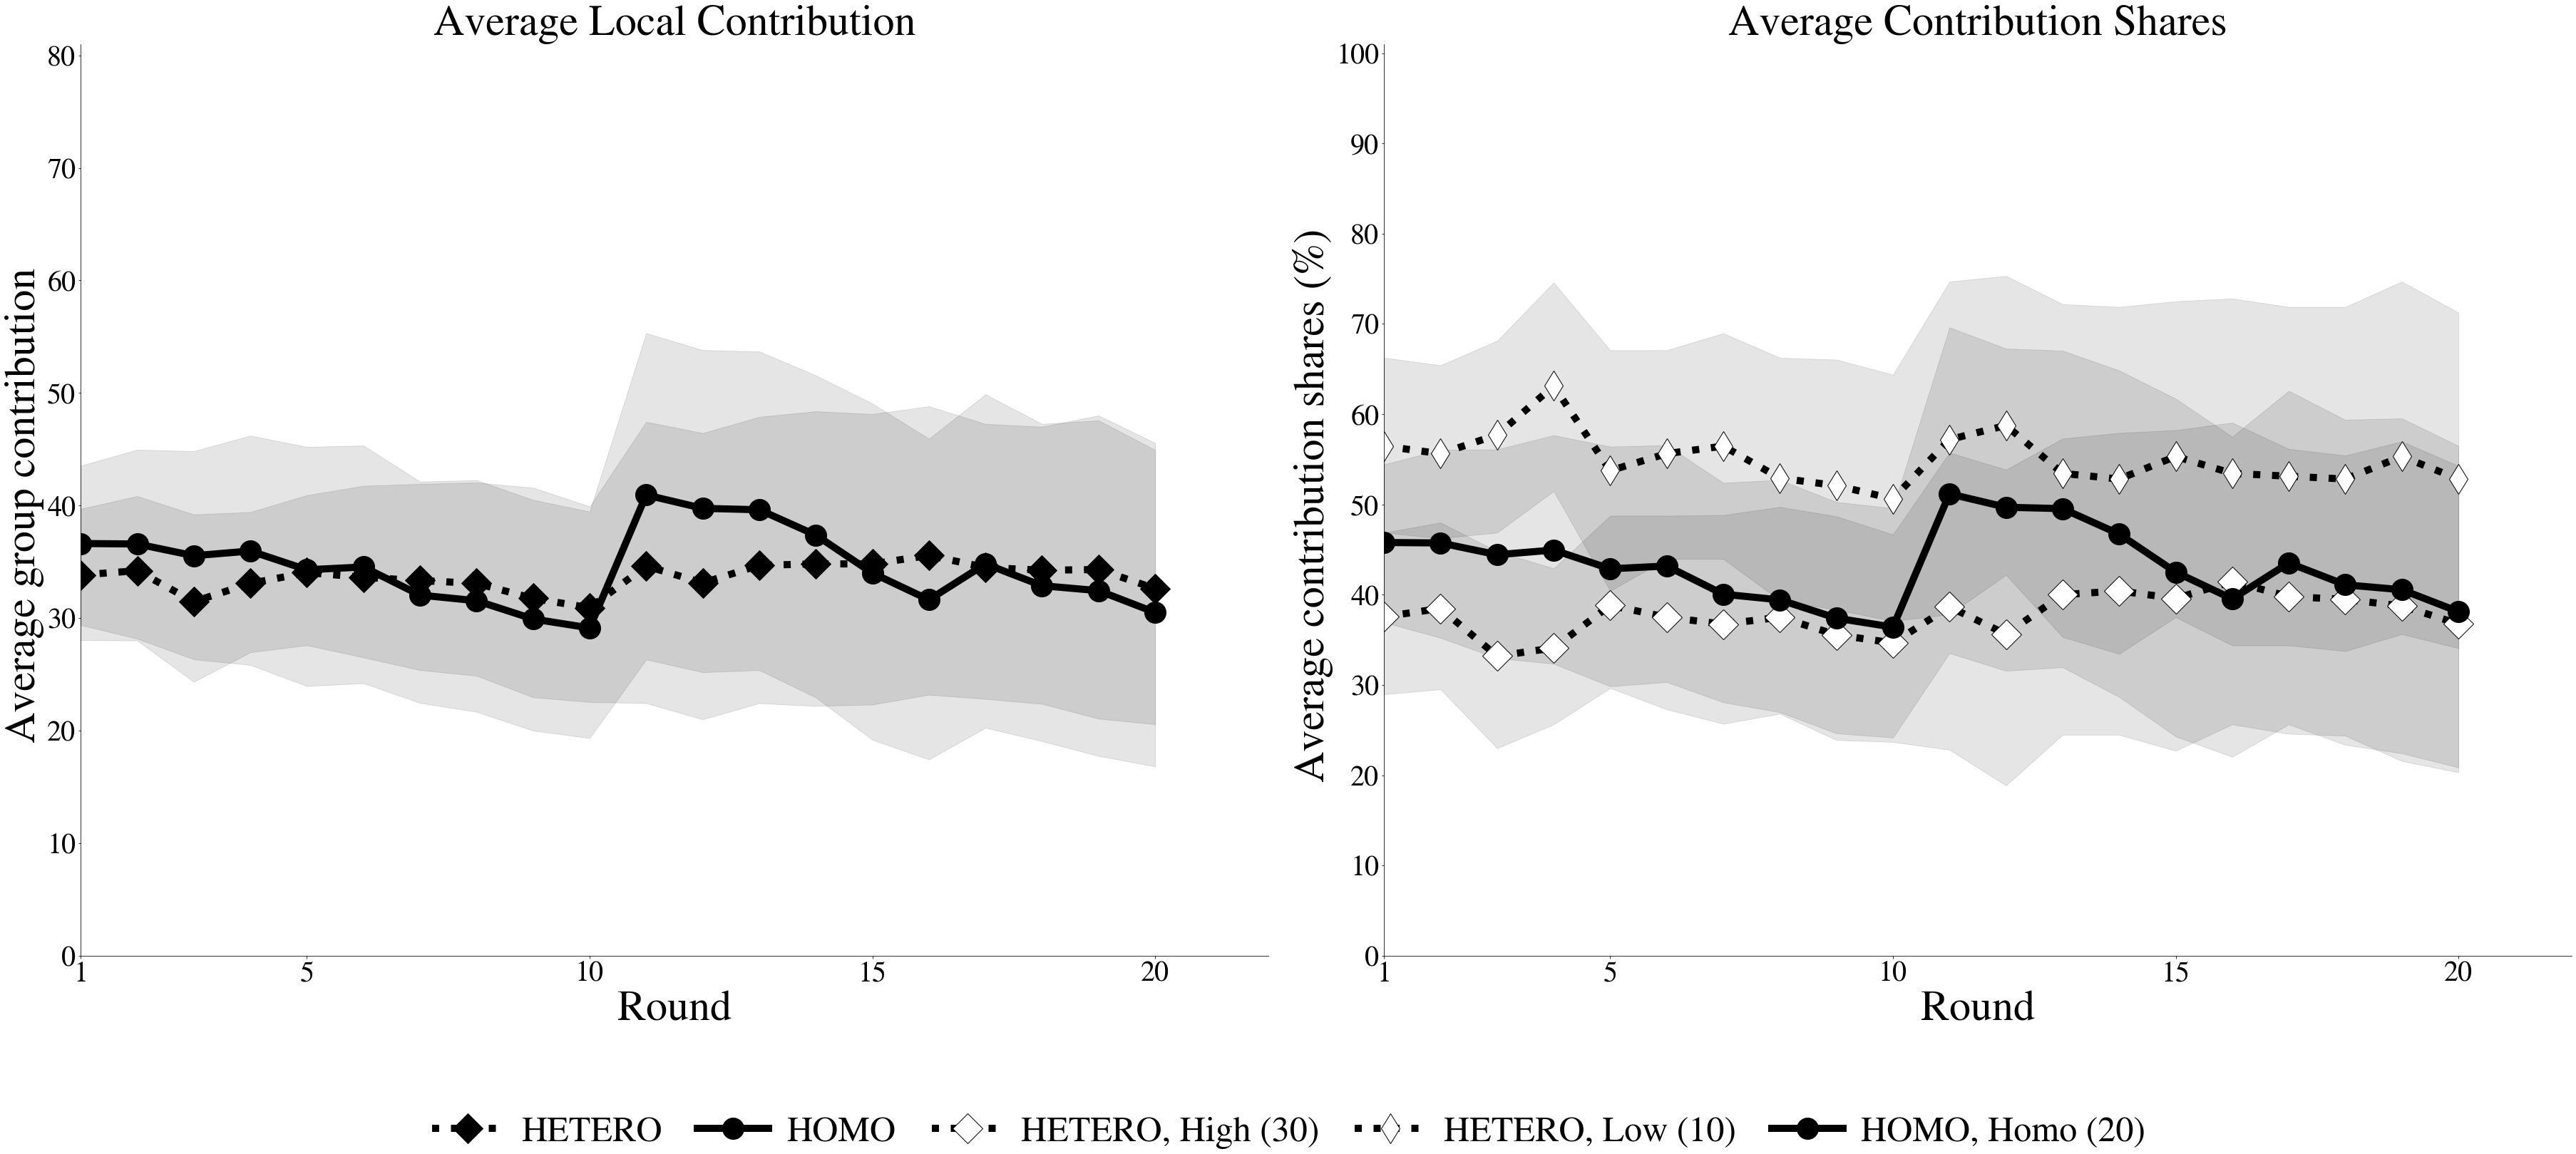

In [166]:
### This is to create the graph for all rounds

# Left graph for absolute value 
treatment_list = ['HETERO','HOMO']
treatment_var = 'Treatment'
var_of_interest =  'tot_contr'

LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()

output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list)



# right graph for absolute value 
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()
output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list_r , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 81)
custom_xtick = np.array([0,4,9,14,19])
custom_ytick = np.arange(0,81,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o',
                     }
    
custom_markercolor = ['black', 'black', ]
custom_markerfacecolor = ['black', 'black']
custom_linestyle = [':','-']

for j, yy in enumerate(treatment_list):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average group contribution ', fontsize=60)
axes[0].set_title('Average Local Contribution', fontsize=60)

# axes[0].spines['top'].set_visible(False)
# axes[0].spines['right'].set_visible(False)  
# axes[0].tick_params(axis='x', labelsize=40)
# axes[0].tick_params(axis='y', labelsize=40)



# Right figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 21)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_linestyle = [':',':','-']



for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[1].set_xlabel('Round', fontsize=60)
axes[1].set_ylabel('Average contribution shares (%) ', fontsize=60)
axes[1].set_title('Average Contribution Shares', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

# handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Only-Contribution.pdf', bbox_inches="tight" )  


In [342]:
data_noOppor_sim

Unnamed: 0 Treatment  FC  subject_id  session_num  \
50              50    HETERO  20           0            0   
51              51    HETERO  20           0            0   
52              52    HETERO  20           0            0   
53              53    HETERO  20           0            0   
54              54    HETERO  20           0            0   
...            ...       ...  ..         ...          ...   
102385          65      HOMO  80         319           19   
102386          66      HOMO  80         319           19   
102387          67      HOMO  80         319           19   
102388          68      HOMO  80         319           19   
102389          69      HOMO  80         319           19   

        player.local_community  endow_org Sequence  subsession.round_number  \
50                           0         10   A2_bab                       51   
51                           0         10   A2_bab                       52   
52                           0         10   A2_bab                       53   
53                           0         10   A2_bab                       54   
54                           0         10   A2_bab                       55   
...                        ...        ...      ...                      ...   
102385                       3         20   A2_bab                       66   
102386                       3         20   A2_bab                       67   
102387                       3         20   A2_bab                       68   
102388                       3         20   A2_bab                       69   
102389                       3         20   A2_bab                       70   

        subsession.period  player.contribution_local  \
50                      1                        8.0   
51                      2                        7.0   
52                      3                        3.9   
53                      4                       10.0   
54                      5                        8.0   
...                   ...                        ...   
102385                 16                       20.0   
102386                 17                       20.0   
102387                 18                       20.0   
102388                 19                       20.0   
102389                 20                       20.0   

        player.contribution_global  tot_contr  tot_cont_share  End_level  \
50                             NaN        8.0            80.0   Low (10)   
51                             NaN        7.0            70.0   Low (10)   
52                             NaN        3.9            39.0   Low (10)   
53                             NaN       10.0           100.0   Low (10)   
54                             NaN        8.0            80.0   Low (10)   
...                            ...        ...             ...        ...   
102385                         NaN       20.0           100.0  Homo (20)   
102386                         NaN       20.0           100.0  Homo (20)   
102387                         NaN       20.0           100.0  Homo (20)   
102388                         NaN       20.0           100.0  Homo (20)   
102389                         NaN       20.0           100.0  Homo (20)   

             T_endw_comp  
50      HETERO, Low (10)  
51      HETERO, Low (10)  
52      HETERO, Low (10)  
53      HETERO, Low (10)  
54      HETERO, Low (10)  
...                  ...  
102385   HOMO, Homo (20)  
102386   HOMO, Homo (20)  
102387   HOMO, Homo (20)  
102388   HOMO, Homo (20)  
102389   HOMO, Homo (20)  

[25600 rows x 16 columns]

In [343]:
# Prepare to add the simulated data on top of the experimental data
# data_noOppor_sim = CounterfactualData_cut[CounterfactualData_cut['Sequence']=='A2_bab']
data_noOppor_sim = CounterfactualData[CounterfactualData['Sequence']=='A2_bab']

data_noOppor_sim['tot_contr'] = data_noOppor_sim['player.contribution_local']
data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['player.contribution_local'] / data_noOppor_sim['endow_org']
data_noOppor_sim['End_level'] = "High (30)"
data_noOppor_sim.loc[data_noOppor_sim['endow_org']==10,'End_level'] = "Low (10)"
data_noOppor_sim.loc[data_noOppor_sim['endow_org']==20,'End_level'] = "Homo (20)"
data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['tot_contr'] / data_noOppor_sim['endow_org'] * 100
data_noOppor_sim['T_endw_comp']= data_noOppor_sim['Treatment'] + ', ' + data_noOppor_sim['End_level']


# Left graph for absolute value 
treatment_list = ['HETERO','HOMO']
treatment_var = 'Treatment'
var_of_interest =  'tot_contr'

LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()

output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list)


LocalOnly = data_noOppor_sim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()

output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list , 20)

dfSim = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_lSim = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_uSim = pd.DataFrame(output[2,:,:], columns = treatment_list)


# right graph for absolute value 
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()
output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list_r , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_noOppor_sim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()
output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list_r , 20)

df_rSim = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lrSim = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_urSim = pd.DataFrame(output[2,:,:], columns = treatment_list_r)


C:\Users\xinxi\AppData\Local\Temp/ipykernel_9008/2589311535.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noOppor_sim['tot_contr'] = data_noOppor_sim['player.contribution_local']
C:\Users\xinxi\AppData\Local\Temp/ipykernel_9008/2589311535.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['player.contribution_local'] / data_noOppor_sim['endow_org']
C:\Users\xinxi\AppData\Local\Temp/ipykernel_9008/2589311535.py:7: SettingWithCopyWarning: 
A va

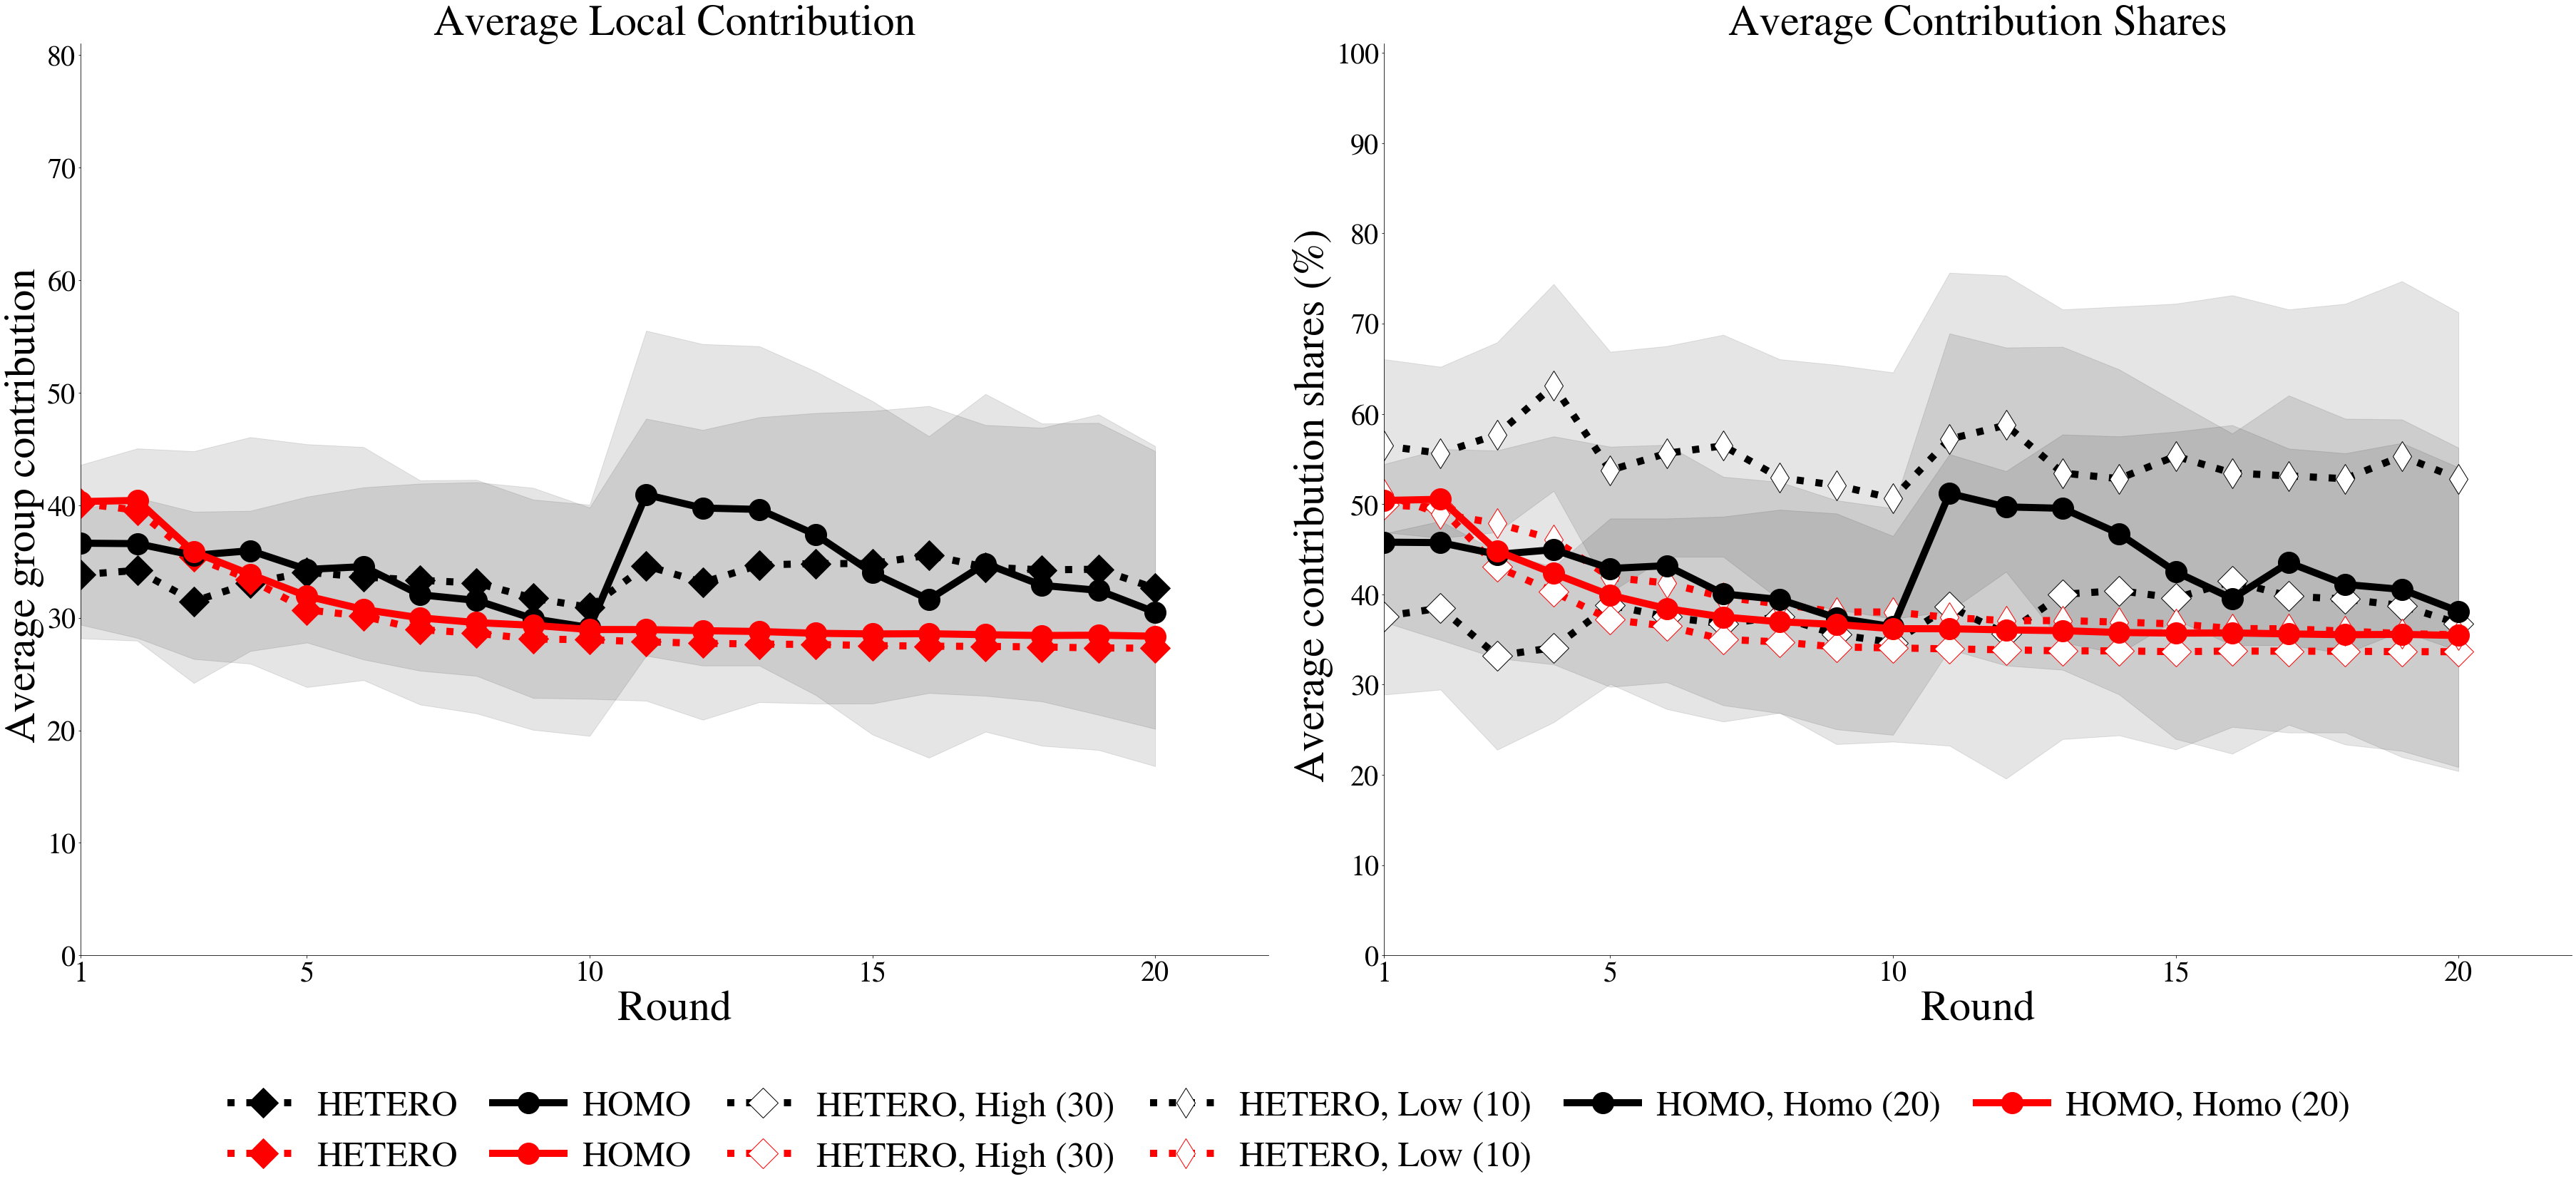

In [344]:
### Compare with Simulation results

pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 81)
custom_xtick = np.array([0,4,9,14,19])
custom_ytick = np.arange(0,81,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o',
                     }
    
custom_markercolor = ['black', 'black', ]
custom_markerfacecolor = ['black', 'black']
custom_linestyle = [':','-']

for j, yy in enumerate(treatment_list):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])
    axes[0].plot(dfSim[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor='red',
                         linewidth=10,  markersize=30 )
#     axes[0].fill_between(df_ci_uSim.index, df_ci_uSim[yy],df_ci_lSim[yy], alpha=0.1, color='red')

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average group contribution ', fontsize=60)
axes[0].set_title('Average Local Contribution', fontsize=60)

# axes[0].spines['top'].set_visible(False)
# axes[0].spines['right'].set_visible(False)  
# axes[0].tick_params(axis='x', labelsize=40)
# axes[0].tick_params(axis='y', labelsize=40)



# Right figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 21)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_markerfacecolor_s = ['white', 'white','red']
custom_linestyle = [':',':','-']



for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])
    axes[1].plot(df_rSim[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=30 )
#     axes[1].fill_between(df_ci_urSim.index, df_ci_urSim[yy],df_ci_lrSim[yy], alpha=0.1, color='red')
    
axes[1].set_xlabel('Round', fontsize=60)
axes[1].set_ylabel('Average contribution shares (%) ', fontsize=60)
axes[1].set_title('Average Contribution Shares', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

# handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Only-Contribution-WithSim.pdf', bbox_inches="tight" )  


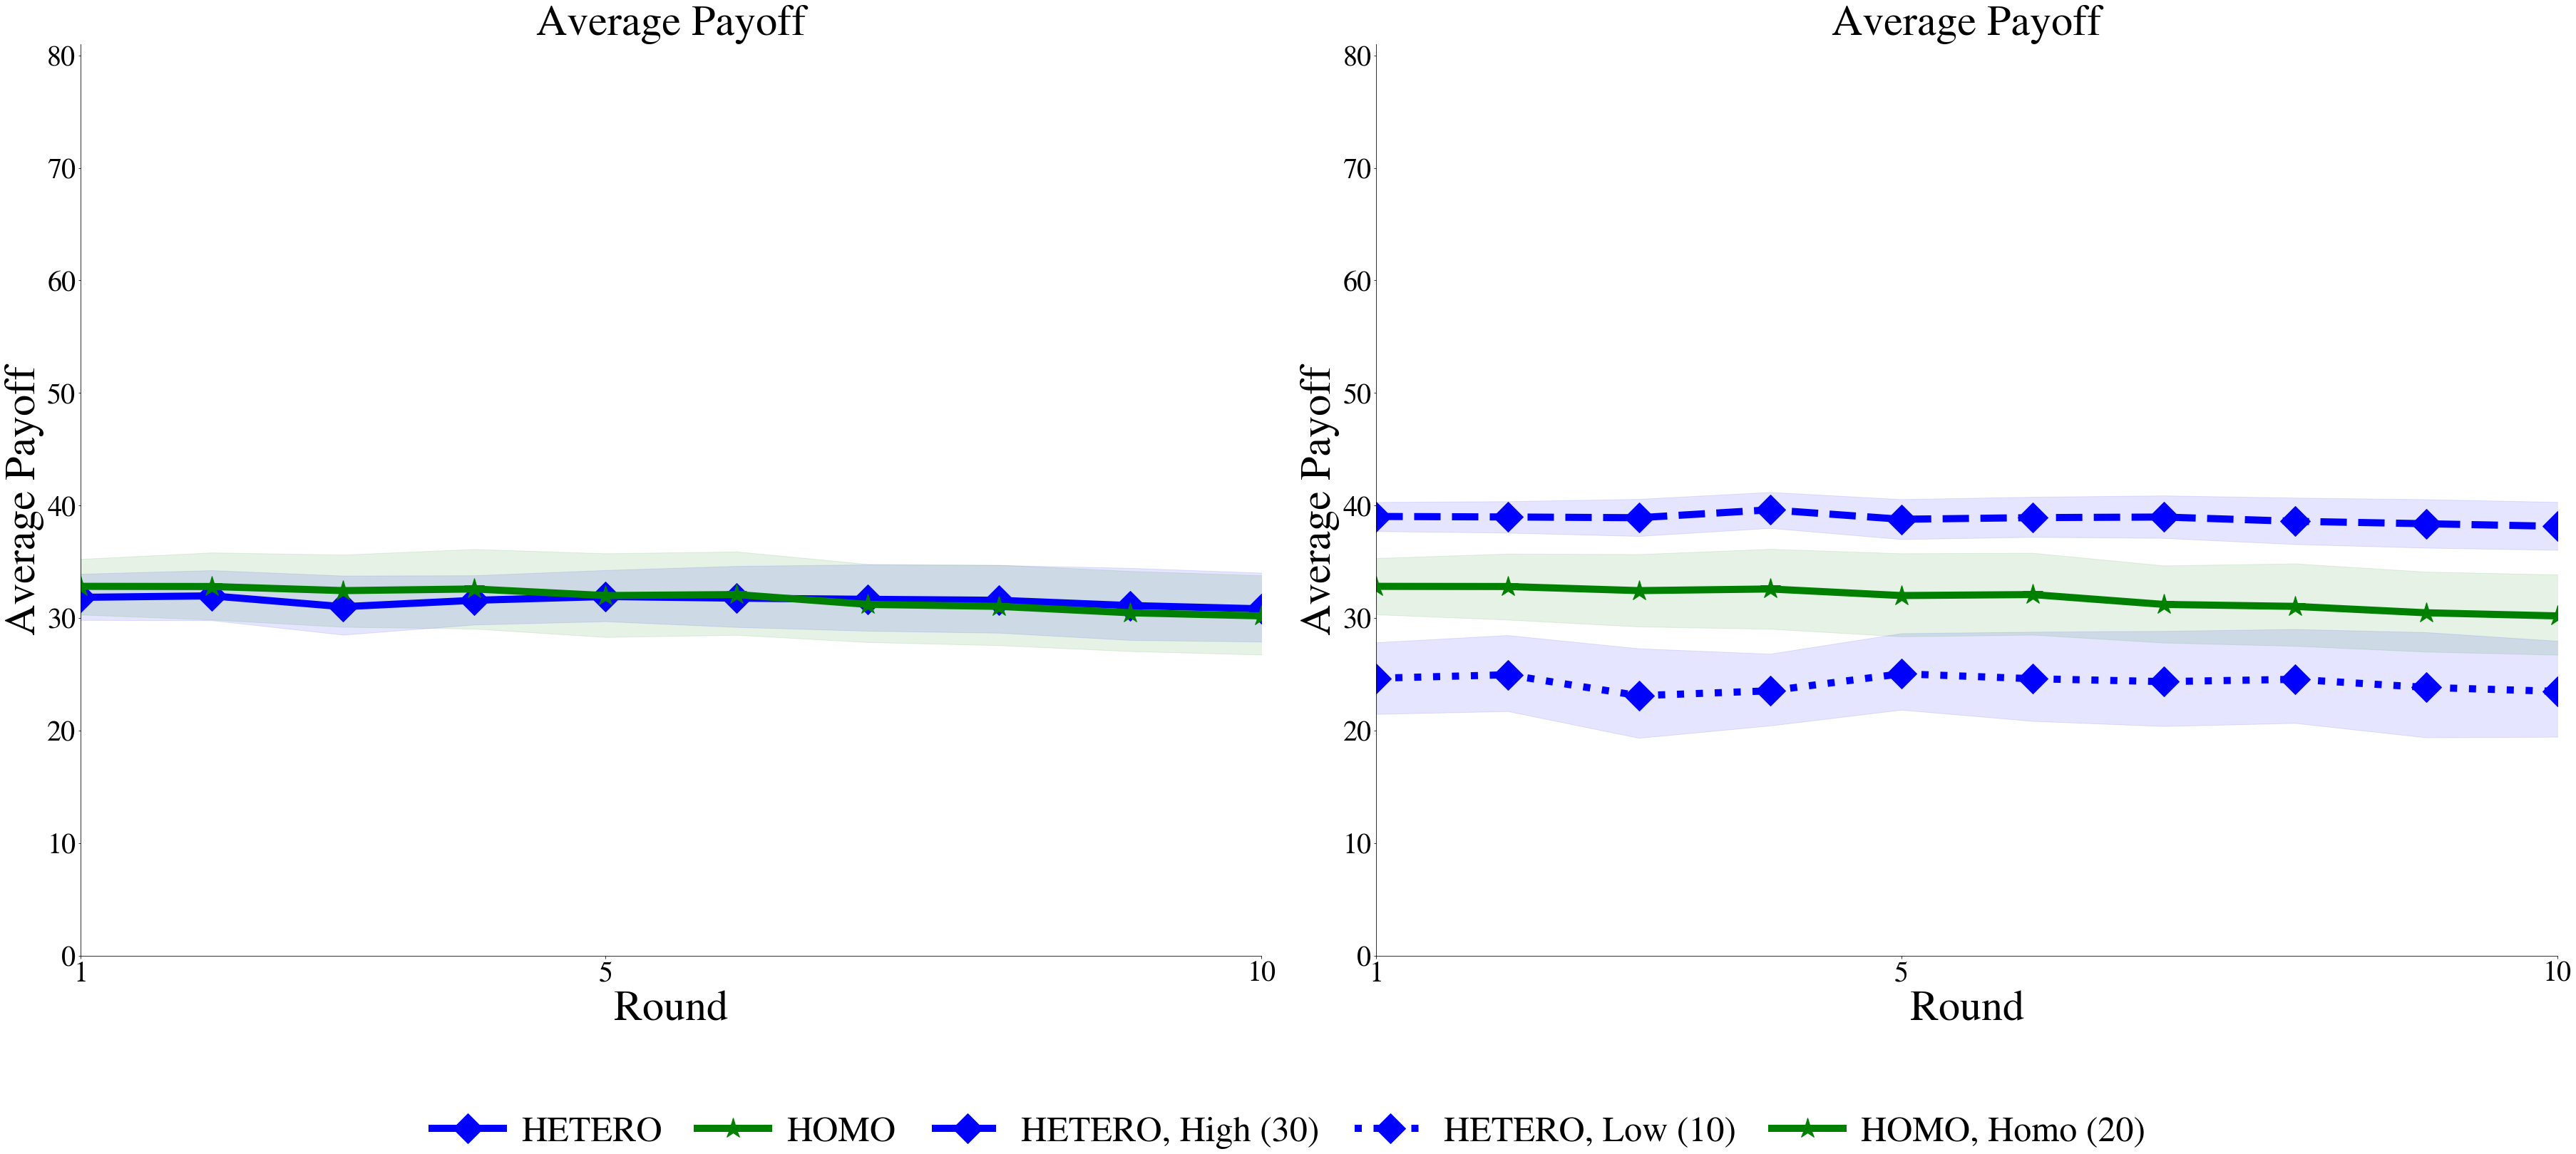

In [172]:
### This is to create the graph for all rounds

# Left graph for absolute value 
treatment_list = ['HETERO','HOMO']
treatment_var = 'Treatment'
var_of_interest =  'player.payoff'

LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list)



# right graph for absolute value 
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'player.payoff'
LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()
output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list_r , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 81)
custom_xtick = np.array([0,4,9,14,19])
custom_ytick = np.arange(0,81,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO': 'D',
                    'HOMO': '*',
                     }
    
custom_markercolor = ['b', 'g', ]
custom_markerfacecolor = ['b', 'g']
custom_linestyle = ['-','-']

for j, yy in enumerate(treatment_list):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average Payoff', fontsize=60)
axes[0].set_title('Average Payoff', fontsize=60)

# axes[0].spines['top'].set_visible(False)
# axes[0].spines['right'].set_visible(False)  
# axes[0].tick_params(axis='x', labelsize=40)
# axes[0].tick_params(axis='y', labelsize=40)



# Right figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 81)
custom_ytick = np.arange(0,81,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'D',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['b','b', 'g', ]
custom_markerfacecolor = ['b', 'b','g']
custom_linestyle = ['--',':','-']



for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[1].set_xlabel('Round', fontsize=60)
axes[1].set_ylabel('Average Payoff', fontsize=60)
axes[1].set_title('Average Payoff', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

# handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Only-Welfare.pdf', bbox_inches="tight" )  


### Local only (others)

If pulling all apps together, the difference is not very significant 

Just note: when only considering A2, HOMO > Hetero in the first 15 rounds (roughly), but maybe not significant (don't know yet)

### Only look at A1, homo is much smaller than hetero; All A, homo is slightly higher than hetero

### Temp Conclusion: Local only: HOMO may be slightly higher than HETERO (even so, maybe not significant) I don't observe a different in contribution between HOMO and HETERO communities. 


-[Local Only Environment](#Local-Only-Environment)

In [9]:
# Data local only 
## Note: in local app, 'subsession.round_number' = 'subsession.period'
# data_noOppor_AllA = pd.read_csv('..\\ProcessedData\\data_noOppor_AllA.csv')
# data_noOppor_A2=pd.read_csv('..\\ProcessedData\\data_noOppor_A2.csv')
data_noOppor = data_noOppor_AllA
# data_noOppor = data_noOppor_AllA[data_noOppor_AllA['Sequence']=='A1'] # A1 only 


# var_of_interest = 'player.contribution_local'
# var_of_interest = 'player.payoff'
# var_of_interest = 'privateAcc'
var_of_interest =  'tot_contr'

LocalOnly = data_noOppor.groupby([ 
                      'Treatment',
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum()

# LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, index=['player.local_community',  'session.code', 'Treatment','FC','Sequence'],
#                     columns=['subsession.round_number'], aggfunc=np.sum, fill_value=np.nan)

# LocalOnly.groupby(['Treatment','FC','Sequence']).mean()
LocalOnly.groupby(['Treatment']).mean() # Note: if only A2 and A2_bab, contribution: downward trending is apparent; added A1, not very apparent (Hetero 20 upward trending?)

Treatment
HETERO    33.4925
HOMO      34.3275
Name: tot_contr, dtype: float64

In [28]:
# LocalOnly = LocalOnly.reset_index()
# LocalOnly['player.local_community'].unique()
# x = LocalOnly.loc[LocalOnly['Treatment']=='HETERO', 'tot_contr']
# x
# bootstrap_ci(np.array(x), 10000, np.mean)
treatment_list = ['HETERO','HOMO']
treatment_var = 'Treatment'
var_of_interest =  'tot_contr'
output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list , 20)


KeyError: 'Treatment'

In [16]:
data_noOppor['subsession.period'].unique()
# data_noOppor['subsession.round_number'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int64)

<AxesSubplot:title={'center':'A1 Only'}, xlabel='subsession.period'>

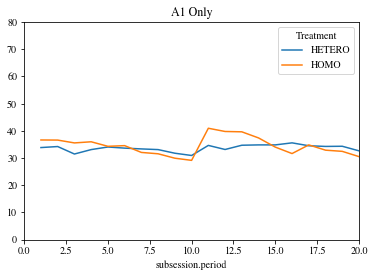

In [17]:
pd.pivot_table(LocalOnly.reset_index(), index = 'subsession.period',  # period=round-number
               columns='Treatment', values=var_of_interest).plot(xlim=(0,20), ylim=(0,80), title='Local Public Goods Only')

<AxesSubplot:title={'center':'Local Public Good Only'}, xlabel='subsession.period'>

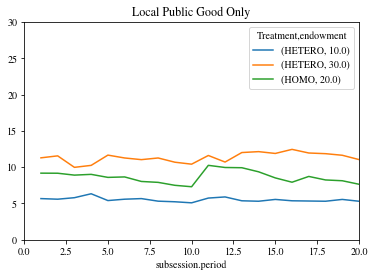

In [20]:
var_of_interest =  'tot_contr'

LocalOnly = data_noOppor.groupby([ 
                      'Treatment',
    'player.local_community',  'session.code', 'endowment',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean()
pd.pivot_table(LocalOnly.reset_index(), index = 'subsession.period', 
               columns=['Treatment', 'endowment'], values=var_of_interest).plot(xlim=(0,20), ylim=(0,30), title='Local Public Good Only')

In [21]:
# Value-wise: 
pd.pivot_table(LocalOnly.reset_index(), index = 'subsession.period', 
               columns=['Treatment', 'endowment'], values=var_of_interest).round(2).T


subsession.period       1      2     3      4      5      6      7      8   \
Treatment endowment                                                          
HETERO    10.0        5.65   5.56  5.77   6.31   5.38   5.56   5.65   5.29   
          30.0       11.27  11.54  9.96  10.23  11.65  11.25  11.02  11.25   
HOMO      20.0        9.16   9.15  8.89   8.99   8.57   8.64   8.01   7.89   

subsession.period       9      10     11     12     13     14     15     16  \
Treatment endowment                                                           
HETERO    10.0        5.21   5.06   5.72   5.88   5.34   5.28   5.53   5.34   
          30.0       10.67  10.40  11.59  10.69  12.00  12.12  11.88  12.44   
HOMO      20.0        7.48   7.28  10.23   9.94   9.91   9.34   8.50   7.91   

subsession.period       17     18     19     20  
Treatment endowment                              
HETERO    10.0        5.31   5.28   5.53   5.28  
          30.0       11.94  11.84  11.62  11.03  
HOMO      20.0        8.70   8.22   8.11   7.62

In [17]:
# LocalOnly.sort_values(['Sequence', 'Treatment', 'FC']) # To check each treatment, how much variations within each treatment/sessions
# LocalOnly.sort_values([ 'Treatment', 'FC', 'player.local_community','Sequence',]) # To check how consistent each group is 

In [ ]:
data_noOppor.groupby([ 
                      'Treatment',
#     'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number'])[var_of_interest].mean()
# plot.line()

In [15]:
def B_round_number_transfor(x):
    y = x
    if x>10 and x<=30:
        y = x-10
    elif x>30:
        y = x-30
    return y
        

# Local + Global Environment

-[Contribution average time trend (both)](#Contribution-average-time-trend-(both))

-[Tradeoff between local and global](#Tradeoff-between-local-and-global)

-[% Join the club (both)](#%-Join-the-club-(both))

-[% Welfare (both)](#%-Welfare-(both))


-[Analyze Global + Local (Others)](#Analyze-Global-+-Local-(Others))



-Return : [Start Data Analysis](#Start-Data-Analysis)

In [146]:
# Data local + global 
data_Oppor = data_Oppor_allB
data_Oppor['End_level'] = "Homo (20)" 
data_Oppor.loc[data_Oppor['endowment']<=10,'End_level'] = "Low (10)"
data_Oppor.loc[data_Oppor['endowment']>20,'End_level'] = "High (30)"
data_Oppor['tot_cont_share'] = data_Oppor['tot_contr'] / data_Oppor['endowment'] * 100
data_Oppor['T_endw_comp']= data_Oppor['Treatment'] + ', ' + data_Oppor['End_level']
data_Oppor['local_share'] = data_Oppor['player.contribution_local']/ data_Oppor['endowment'] * 100
data_Oppor['global_share'] = data_Oppor['player.contribution_global']/ data_Oppor['endowment'] * 100

data_Oppor

subsession.round_number  subsession.period  subsession.sg  \
0                           1                  1              1   
1                           1                  1              1   
2                           1                  1              1   
3                           1                  1              1   
4                           1                  1              1   
...                       ...                ...            ...   
7035                       10                 10              1   
7036                       10                 10              1   
7037                       10                 10              1   
7038                       10                 10              1   
7039                       10                 10              1   

      player.id_in_group  player.endowment  player.join_club  \
0                      1             280.0                 1   
1                      5             280.0                 1   
2                      1             280.0                 1   
3                      5             280.0                 1   
4                      2             300.0                 0   
...                  ...               ...               ...   
7035                   7             180.0                 1   
7036                   4             180.0                 1   
7037                   8             180.0                 1   
7038                   4             180.0                 1   
7039                   8             180.0                 1   

      player.local_community  player.id_in_local  player.contribution_local  \
0                          1                   0                        8.0   
1                          2                   0                        5.0   
2                          3                   0                        7.0   
3                          0                   0                        4.0   
4                          1                   1                       10.0   
...                      ...                 ...                        ...   
7035                       0                   2                        0.0   
7036                       1                   3                        0.0   
7037                       2                   3                        1.0   
7038                       3                   3                        2.0   
7039                       0                   3                        0.0   

      player.contribution_global  ...  participant.code  endowment  tot_contr  \
0                            8.0  ...          zcomruh3       28.0       16.0   
1                            5.0  ...          2hmxb93l       28.0       10.0   
2                            7.0  ...          mtdu10l3       28.0       14.0   
3                            4.0  ...          ycczqkta       28.0        8.0   
4                            0.0  ...          8qc6v1us       30.0       10.0   
...                          ...  ...               ...        ...        ...   
7035                         3.0  ...          vou6qpqb       18.0        3.0   
7036                         0.0  ...          x1c0dxrl       18.0        0.0   
7037                         5.0  ...          191iospu       18.0        6.0   
7038                         9.0  ...          hzmz02dz       18.0       11.0   
7039                        18.0  ...          gkyo3o8s       18.0       18.0   

      privateAcc  Sequence  End_level  tot_cont_share        T_endw_comp  \
0           12.0        B1  High (30)       57.142857  HETERO, High (30)   
1           18.0        B1  High (30)       35.714286  HETERO, High (30)   
2           14.0        B1  High (30)       50.000000  HETERO, High (30)   
3           20.0        B1  High (30)       28.571429  HETERO, High (30)   
4           20.0        B1  High (30)       33.333333  HETERO, High (30)   
...          ...       ...        ...             ... 

In [317]:
data_Oppor['subsession.period'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int64)

In [327]:
x = data_Oppor[(data_Oppor['subsession.period']>=11) & 
           (data_Oppor['subsession.period']<=20)].groupby(['Treatment',
                                                           'FC'])['player.join_club','player.contribution_local','player.contribution_global'].mean()
print(x)
x.to_numpy()

              player.join_club  player.contribution_local  \
Treatment FC                                                
HETERO    20          0.887500                   1.826563   
          80          0.101562                   7.118750   
HOMO      20          0.990625                   1.039062   
          80          0.537500                   1.670313   

              player.contribution_global  
Treatment FC                              
HETERO    20                    5.759375  
          80                    0.240625  
HOMO      20                    6.645313  
          80                    4.256250  


C:\Users\xinxi\AppData\Local\Temp/ipykernel_9008/4003456648.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  x = data_Oppor[(data_Oppor['subsession.period']>=11) &


array([[0.8875   , 1.8265625, 5.759375 ],
       [0.1015625, 7.11875  , 0.240625 ],
       [0.990625 , 1.0390625, 6.6453125],
       [0.5375   , 1.6703125, 4.25625  ]])

In [331]:
CounterfactualData_cut
# For the simulated results
# Data local + global 
# data_OpporSim = CounterfactualData_cut[CounterfactualData_cut['Sequence']=='B1_bab']
data_OpporSim = CounterfactualData[CounterfactualData['Sequence']=='B1_bab']

data_OpporSim['End_level'] = "Homo (20)" 
data_OpporSim['tot_contr'] = data_OpporSim['player.contribution_local'] + np.nan_to_num(data_OpporSim['player.contribution_global'])
data_OpporSim['endowment'] = data_OpporSim['endow_org'] - 1*(1-np.isnan(data_OpporSim['player.contribution_global']))*data_OpporSim['FC']/10
data_OpporSim.loc[data_OpporSim['endow_org']<=10,'End_level'] = "Low (10)"
data_OpporSim.loc[data_OpporSim['endow_org']>20,'End_level'] = "High (30)"


data_OpporSim['tot_cont_share'] = data_OpporSim['tot_contr'] / data_OpporSim['endowment'] * 100
data_OpporSim['T_endw_comp']= data_OpporSim['Treatment'] + ', ' + data_OpporSim['End_level']
data_OpporSim['local_share'] = data_OpporSim['player.contribution_local']/ data_OpporSim['endowment'] * 100
data_OpporSim['global_share'] = data_OpporSim['player.contribution_global']/ data_OpporSim['endowment'] * 100

data_OpporSim['player.join_club'] = 1-np.isnan(data_OpporSim['player.contribution_global'])
# data_OpporSim.loc[(data_OpporSim['endowment']==10) & (data_OpporSim['player.join_club']==1) & (data_OpporSim['FC']==100) ,'End_level'] = "Homo (20)"
# data_OpporSim.loc[(data_OpporSim['endowment']==20) & (data_OpporSim['player.join_club']==1) & (data_OpporSim['FC']==100) ,'End_level'] = "High (30)"


C:\Users\xinxi\AppData\Local\Temp/ipykernel_9008/1866029191.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_OpporSim['End_level'] = "Homo (20)"
C:\Users\xinxi\AppData\Local\Temp/ipykernel_9008/1866029191.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_OpporSim['tot_contr'] = data_OpporSim['player.contribution_local'] + np.nan_to_num(data_OpporSim['player.contribution_global'])
C:\Users\xinxi\AppData\Local\Temp/ipykernel_9008/1866029191.py:9: SettingWithCopyWarning: 
A value is trying to be

### Contribution average time trend (both)

Return: 
 [Local + Global Environment](#Local-+-Global-Environment)


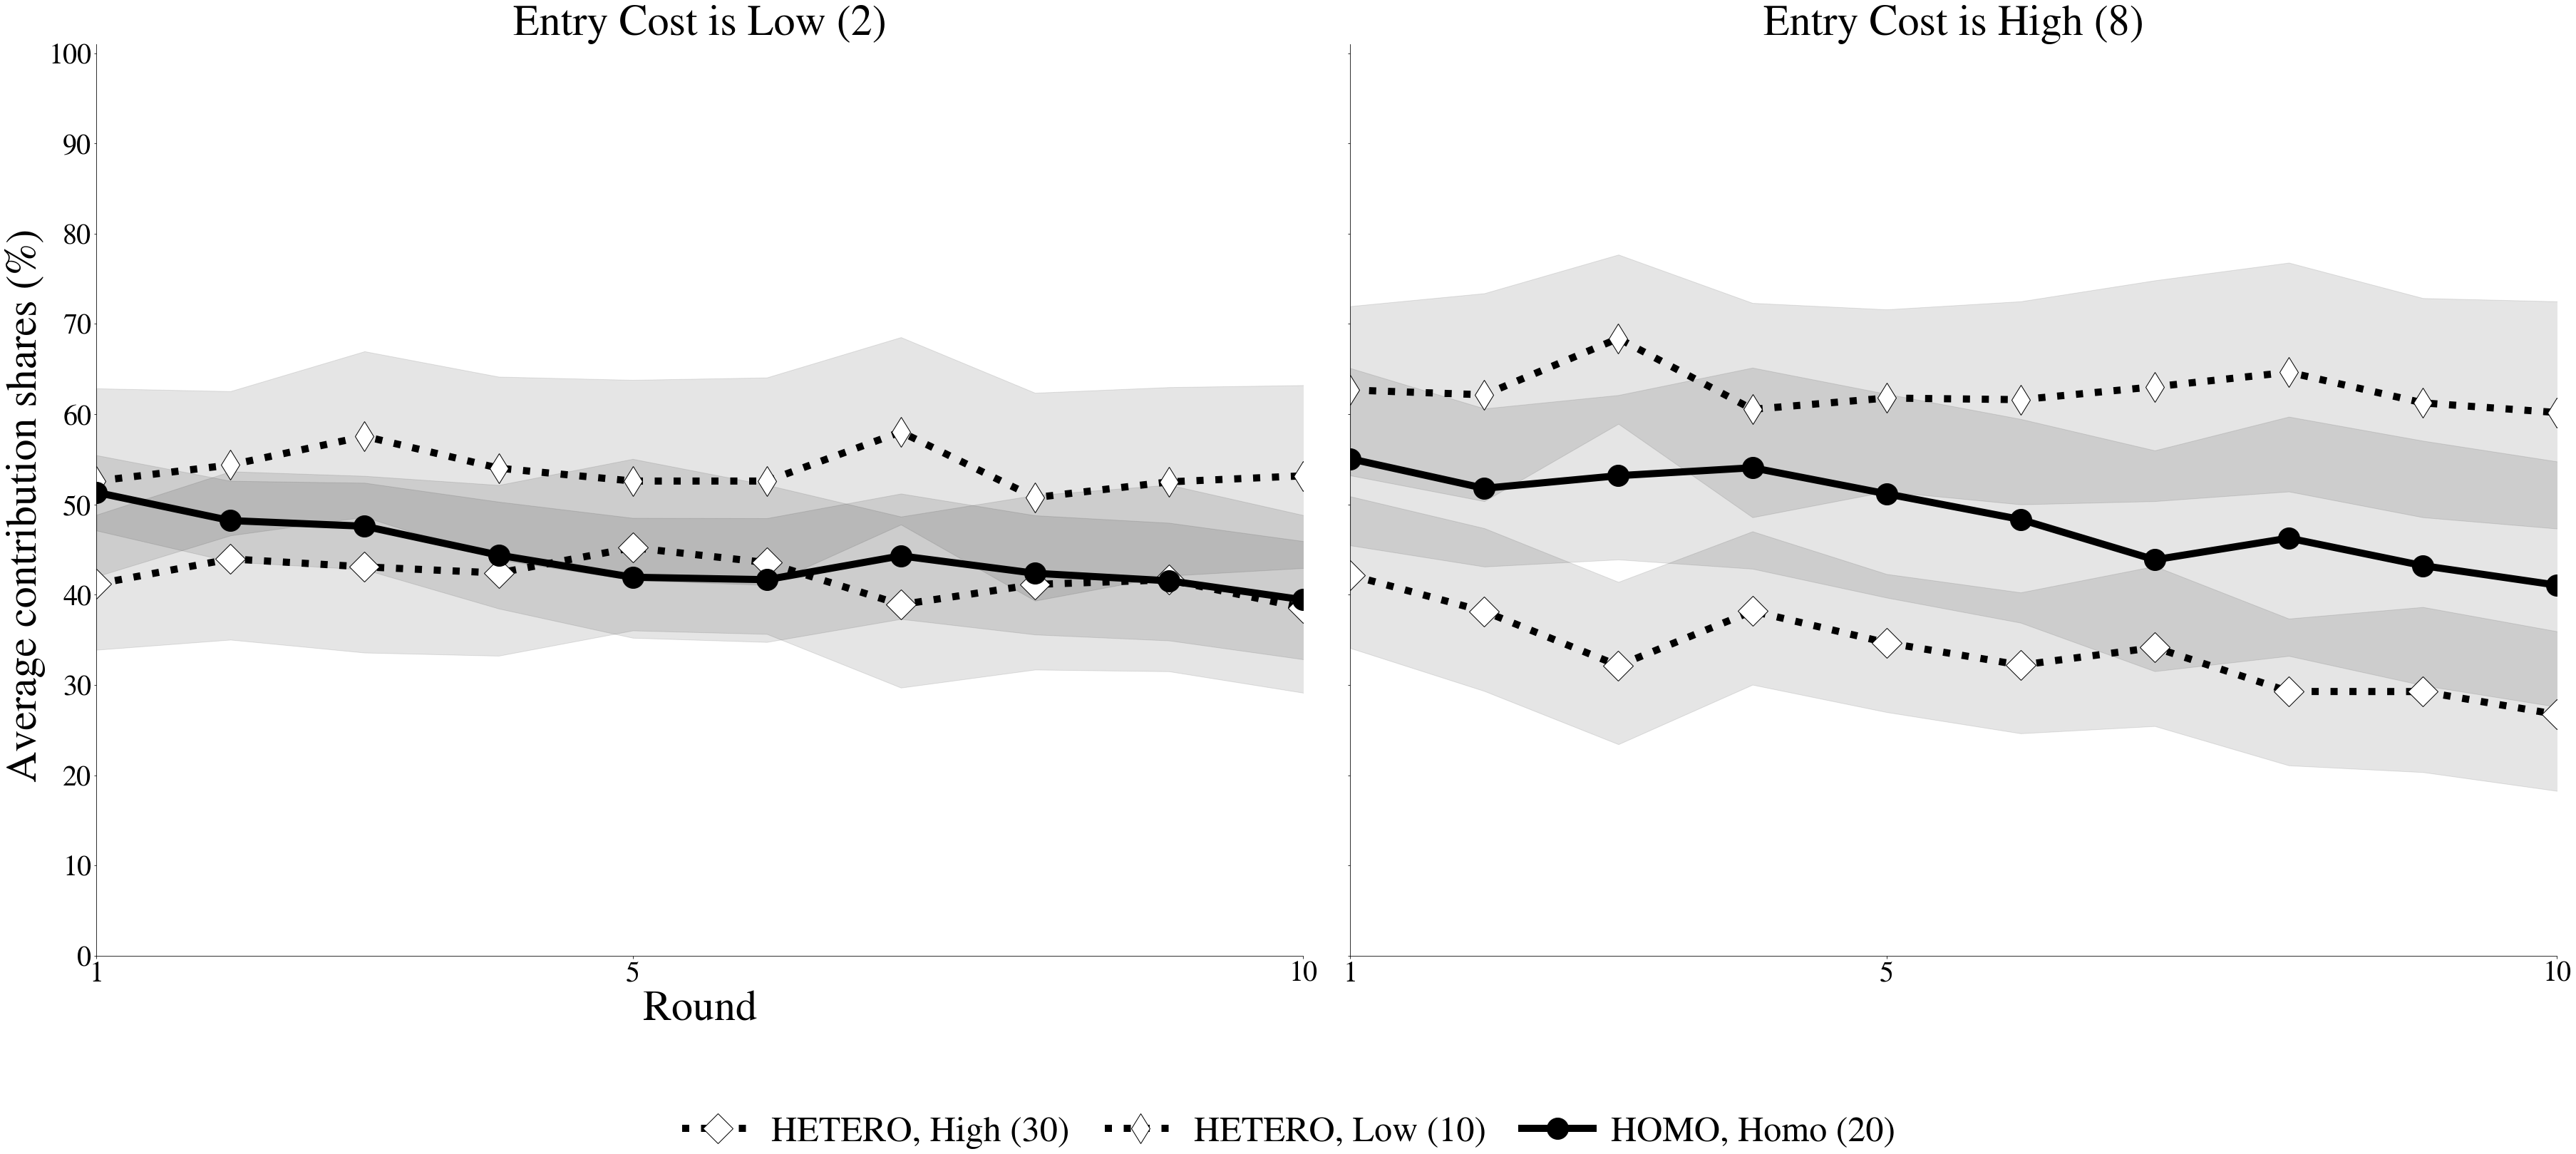

In [153]:
### This is to create the graph for all rounds
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average contribution shares (%) ', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution.pdf', bbox_inches="tight" )  


In [154]:
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']

# For the simulated data

treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_OpporSim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

dfSim = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lSim = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_uSim = pd.DataFrame(output[2,:,:], columns = treatment_list_r)


# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_rSim = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lrSim = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_urSim = pd.DataFrame(output[2,:,:], columns = treatment_list_r)



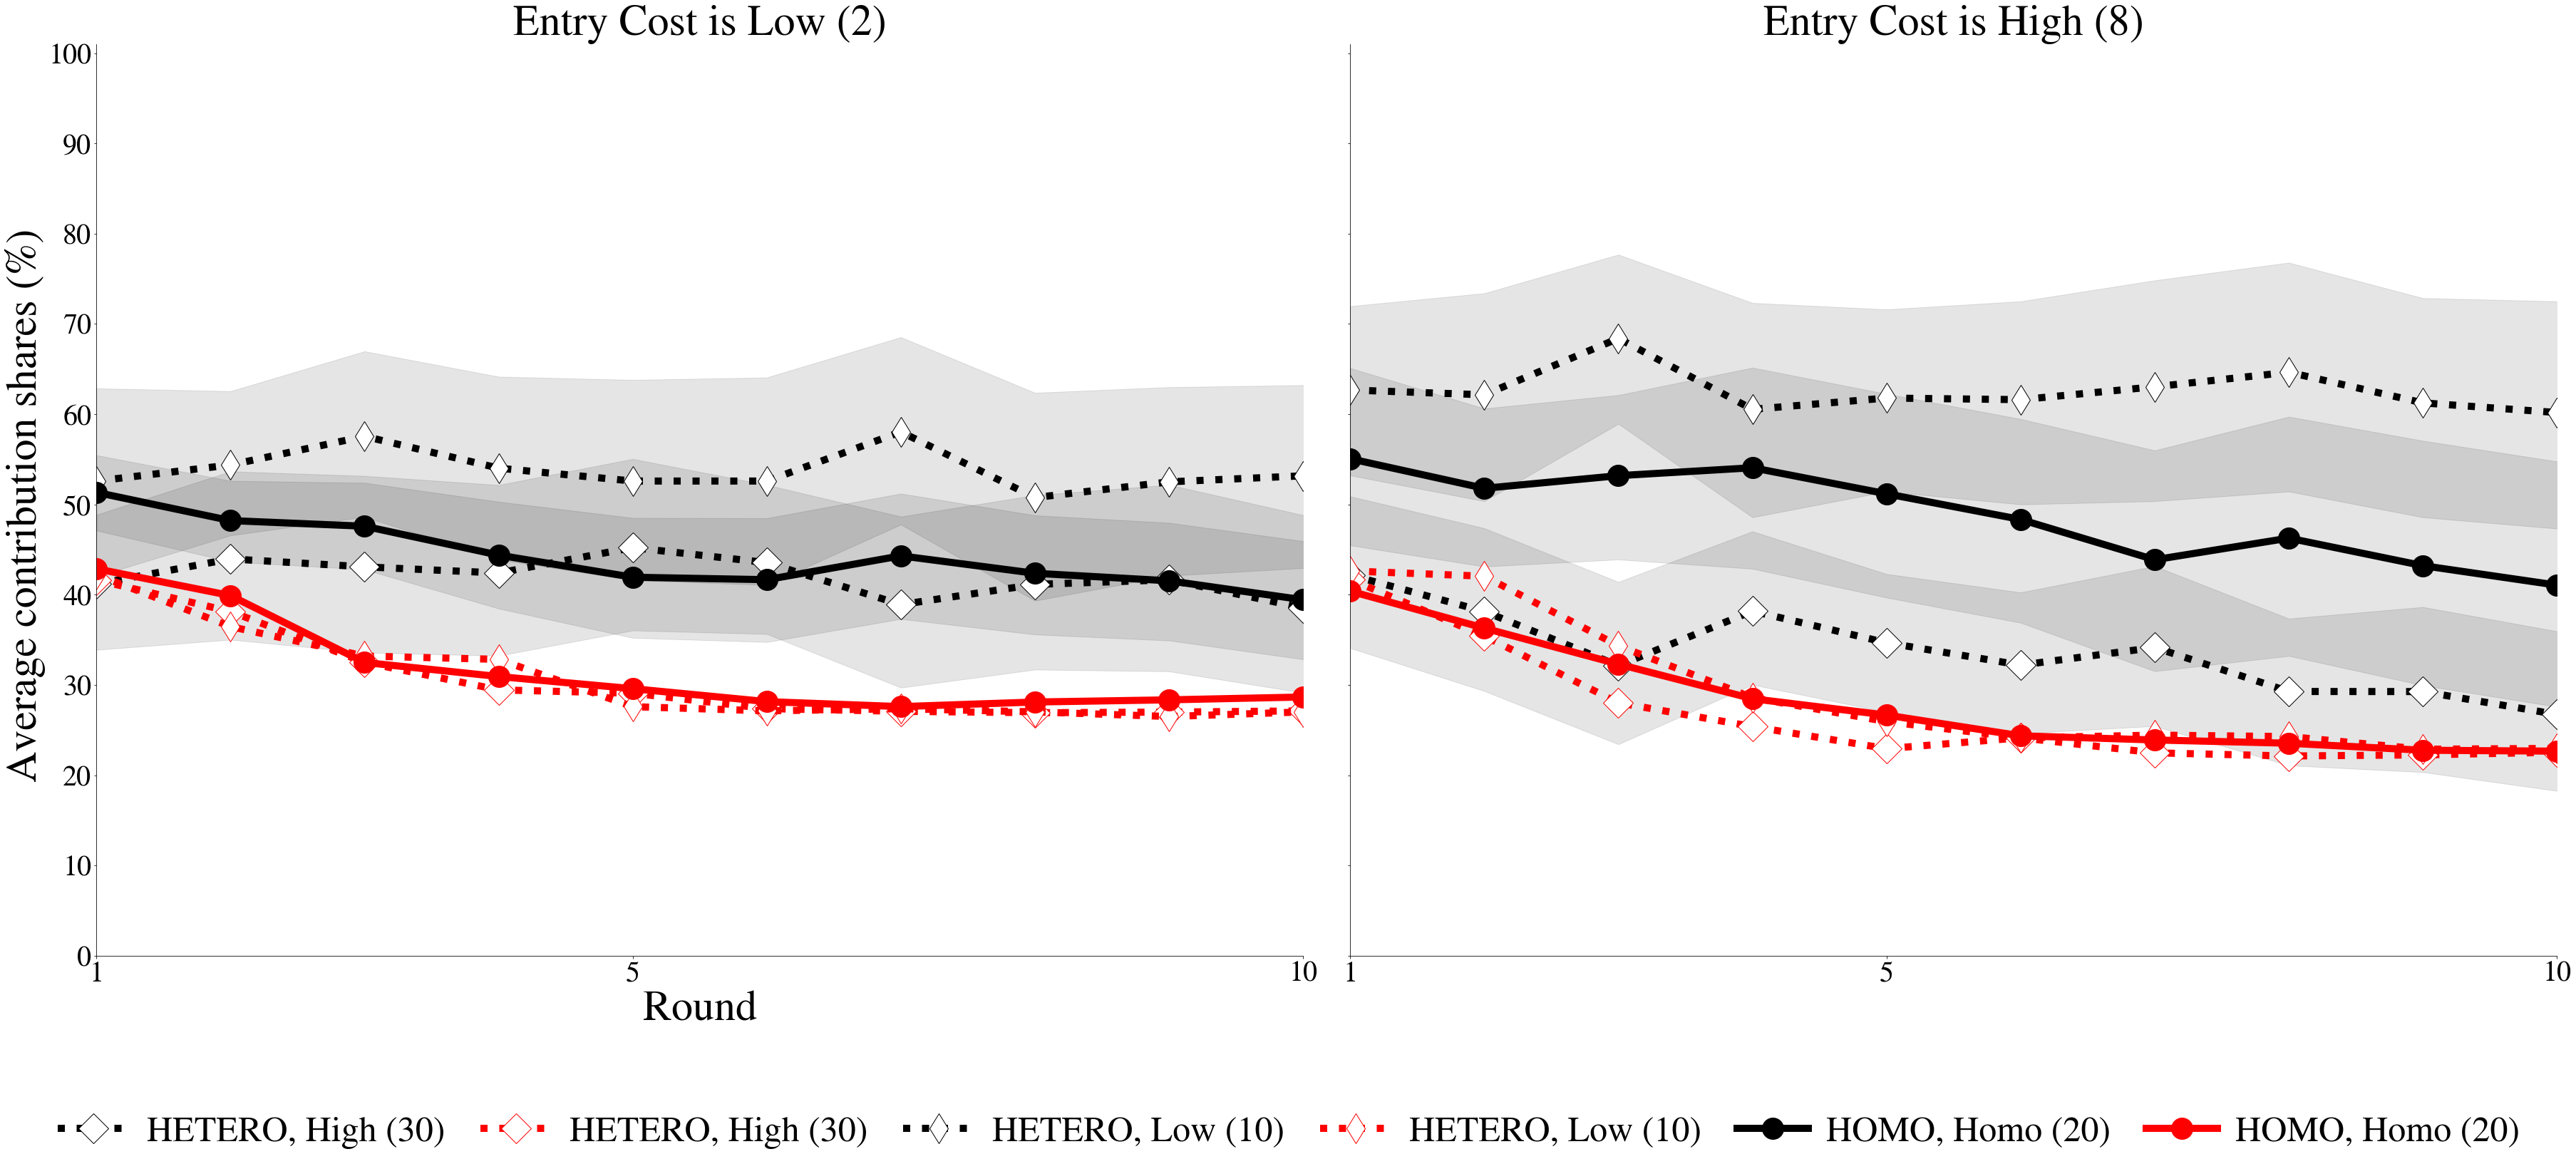

In [155]:
### This is to create the graph for all rounds



pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_markerfacecolor_s = ['white', 'white','red']
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])
    axes[0].plot(dfSim[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=30 )
#     axes[0].fill_between(df_ci_uSim.index, df_ci_uSim[yy],df_ci_lSim[yy], alpha=0.1, color='red')

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average contribution shares (%) ', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])
    axes[1].plot(df_rSim[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=30 )
#     axes[1].fill_between(df_ci_urSim.index, df_ci_urSim[yy],df_ci_lrSim[yy], alpha=0.1, color='red')

axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution-add-simulation.pdf', bbox_inches="tight" )  


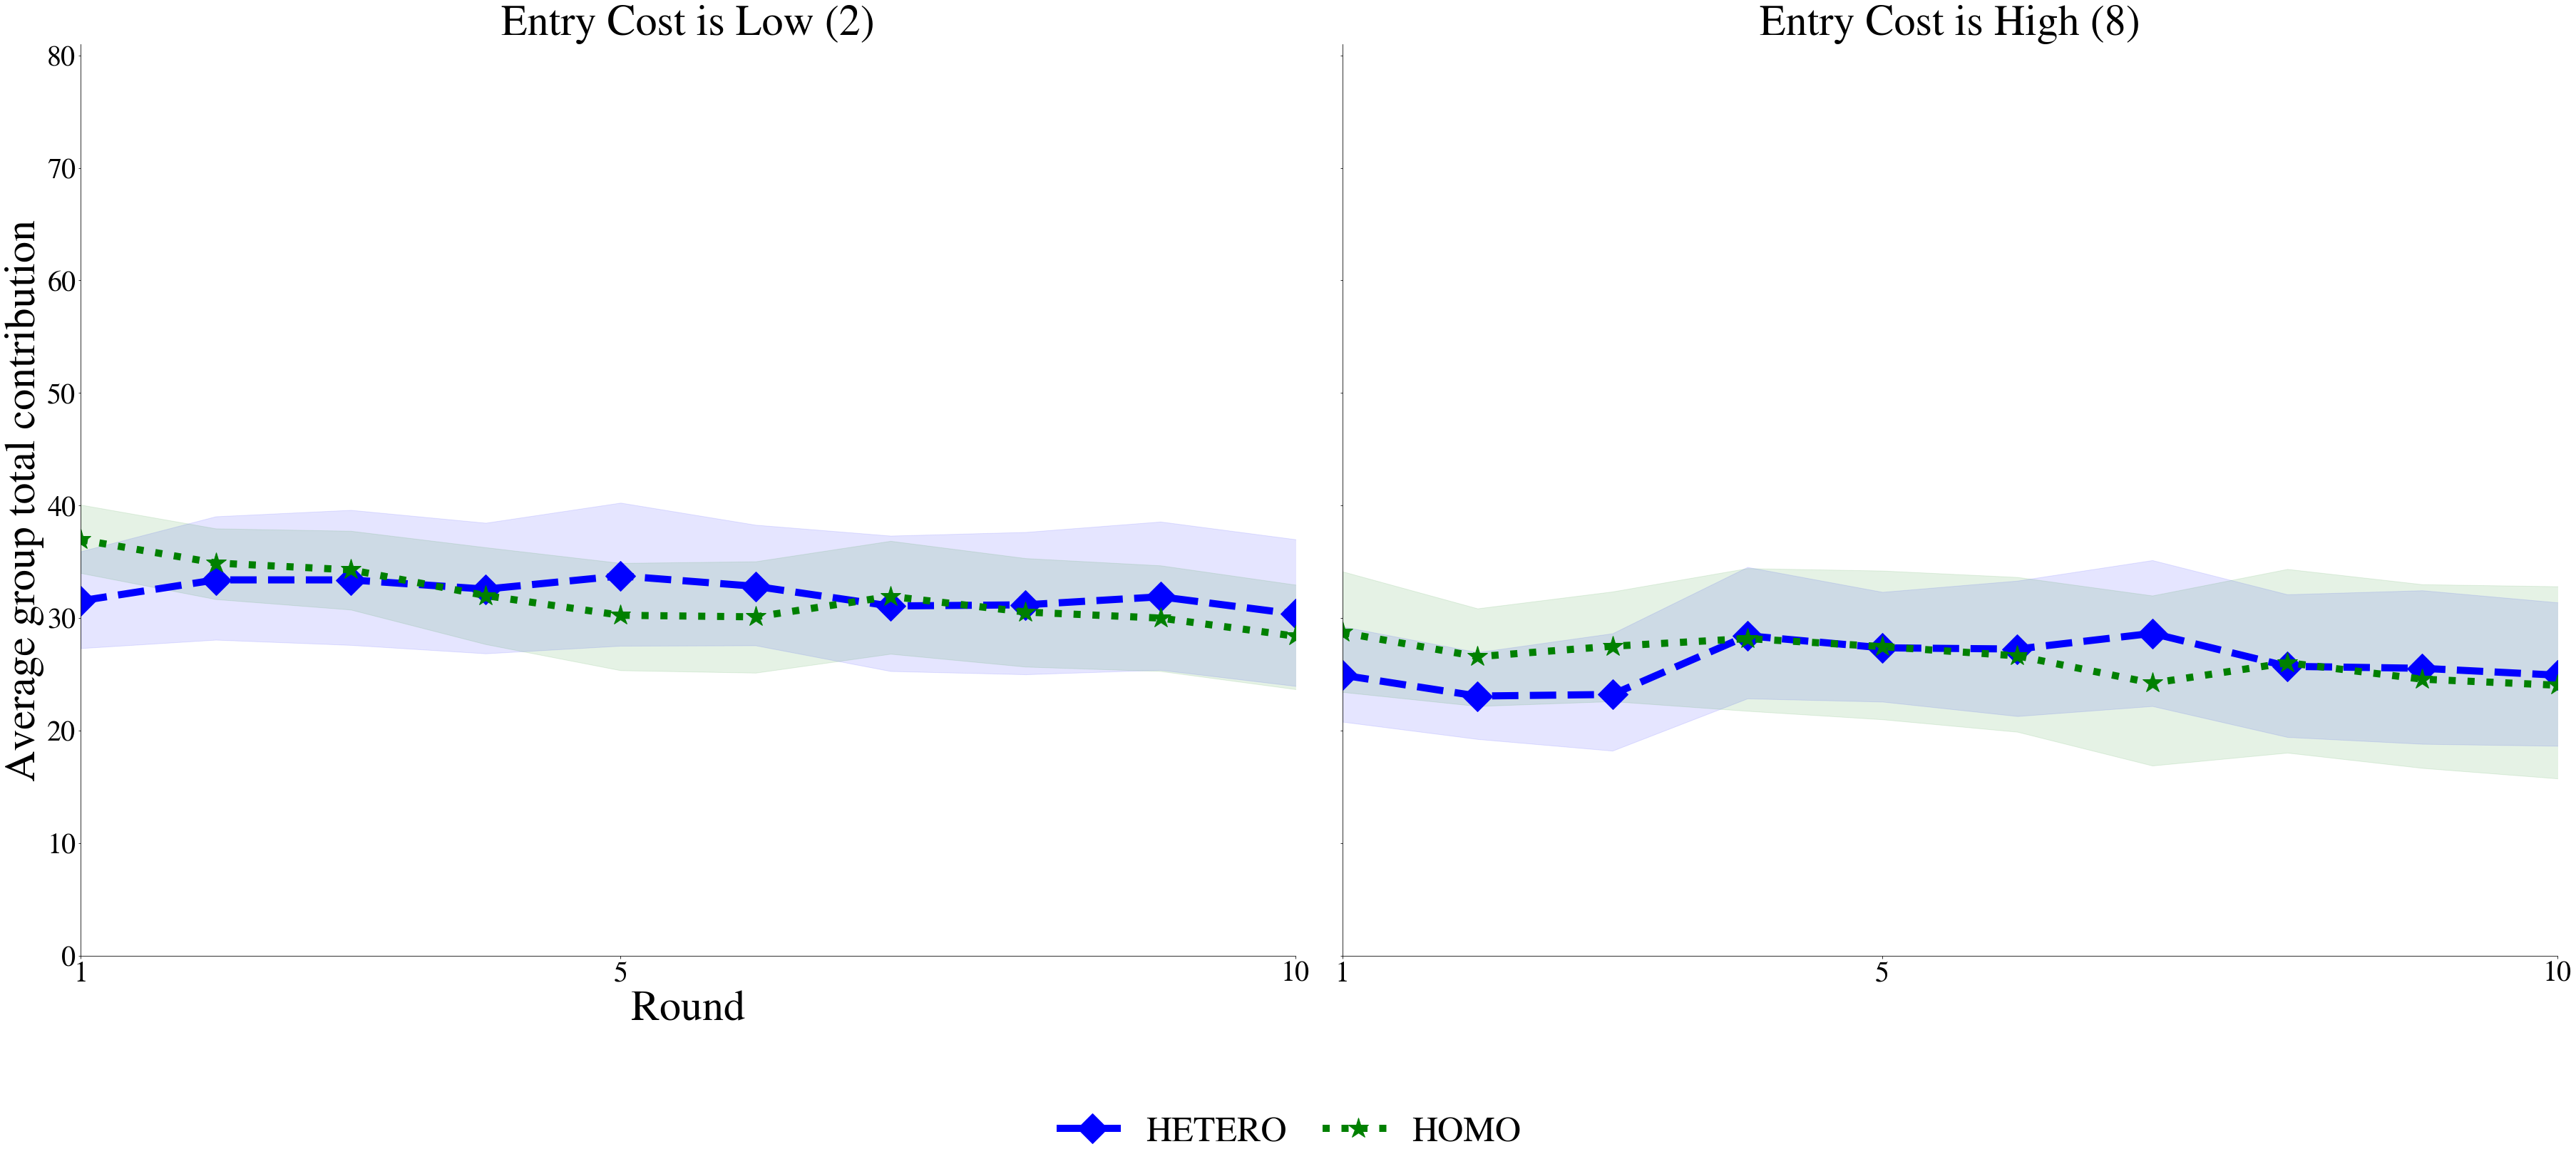

In [34]:
### This is to create the graph for all rounds
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_list = ['HETERO','HOMO']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
var_of_interest =  'tot_contr'
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 81)
custom_ytick = np.arange(0,81,step=10)
custom_xtick = np.array([0,4,9,14,19])
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO': 'D',
#                     'HETERO': 'd',
                    'HOMO': '*'
                     }
    
custom_markercolor = ['b','g', ]
custom_markerfacecolor = ['b', 'g']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average group total contribution', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution2.pdf', bbox_inches="tight" )  


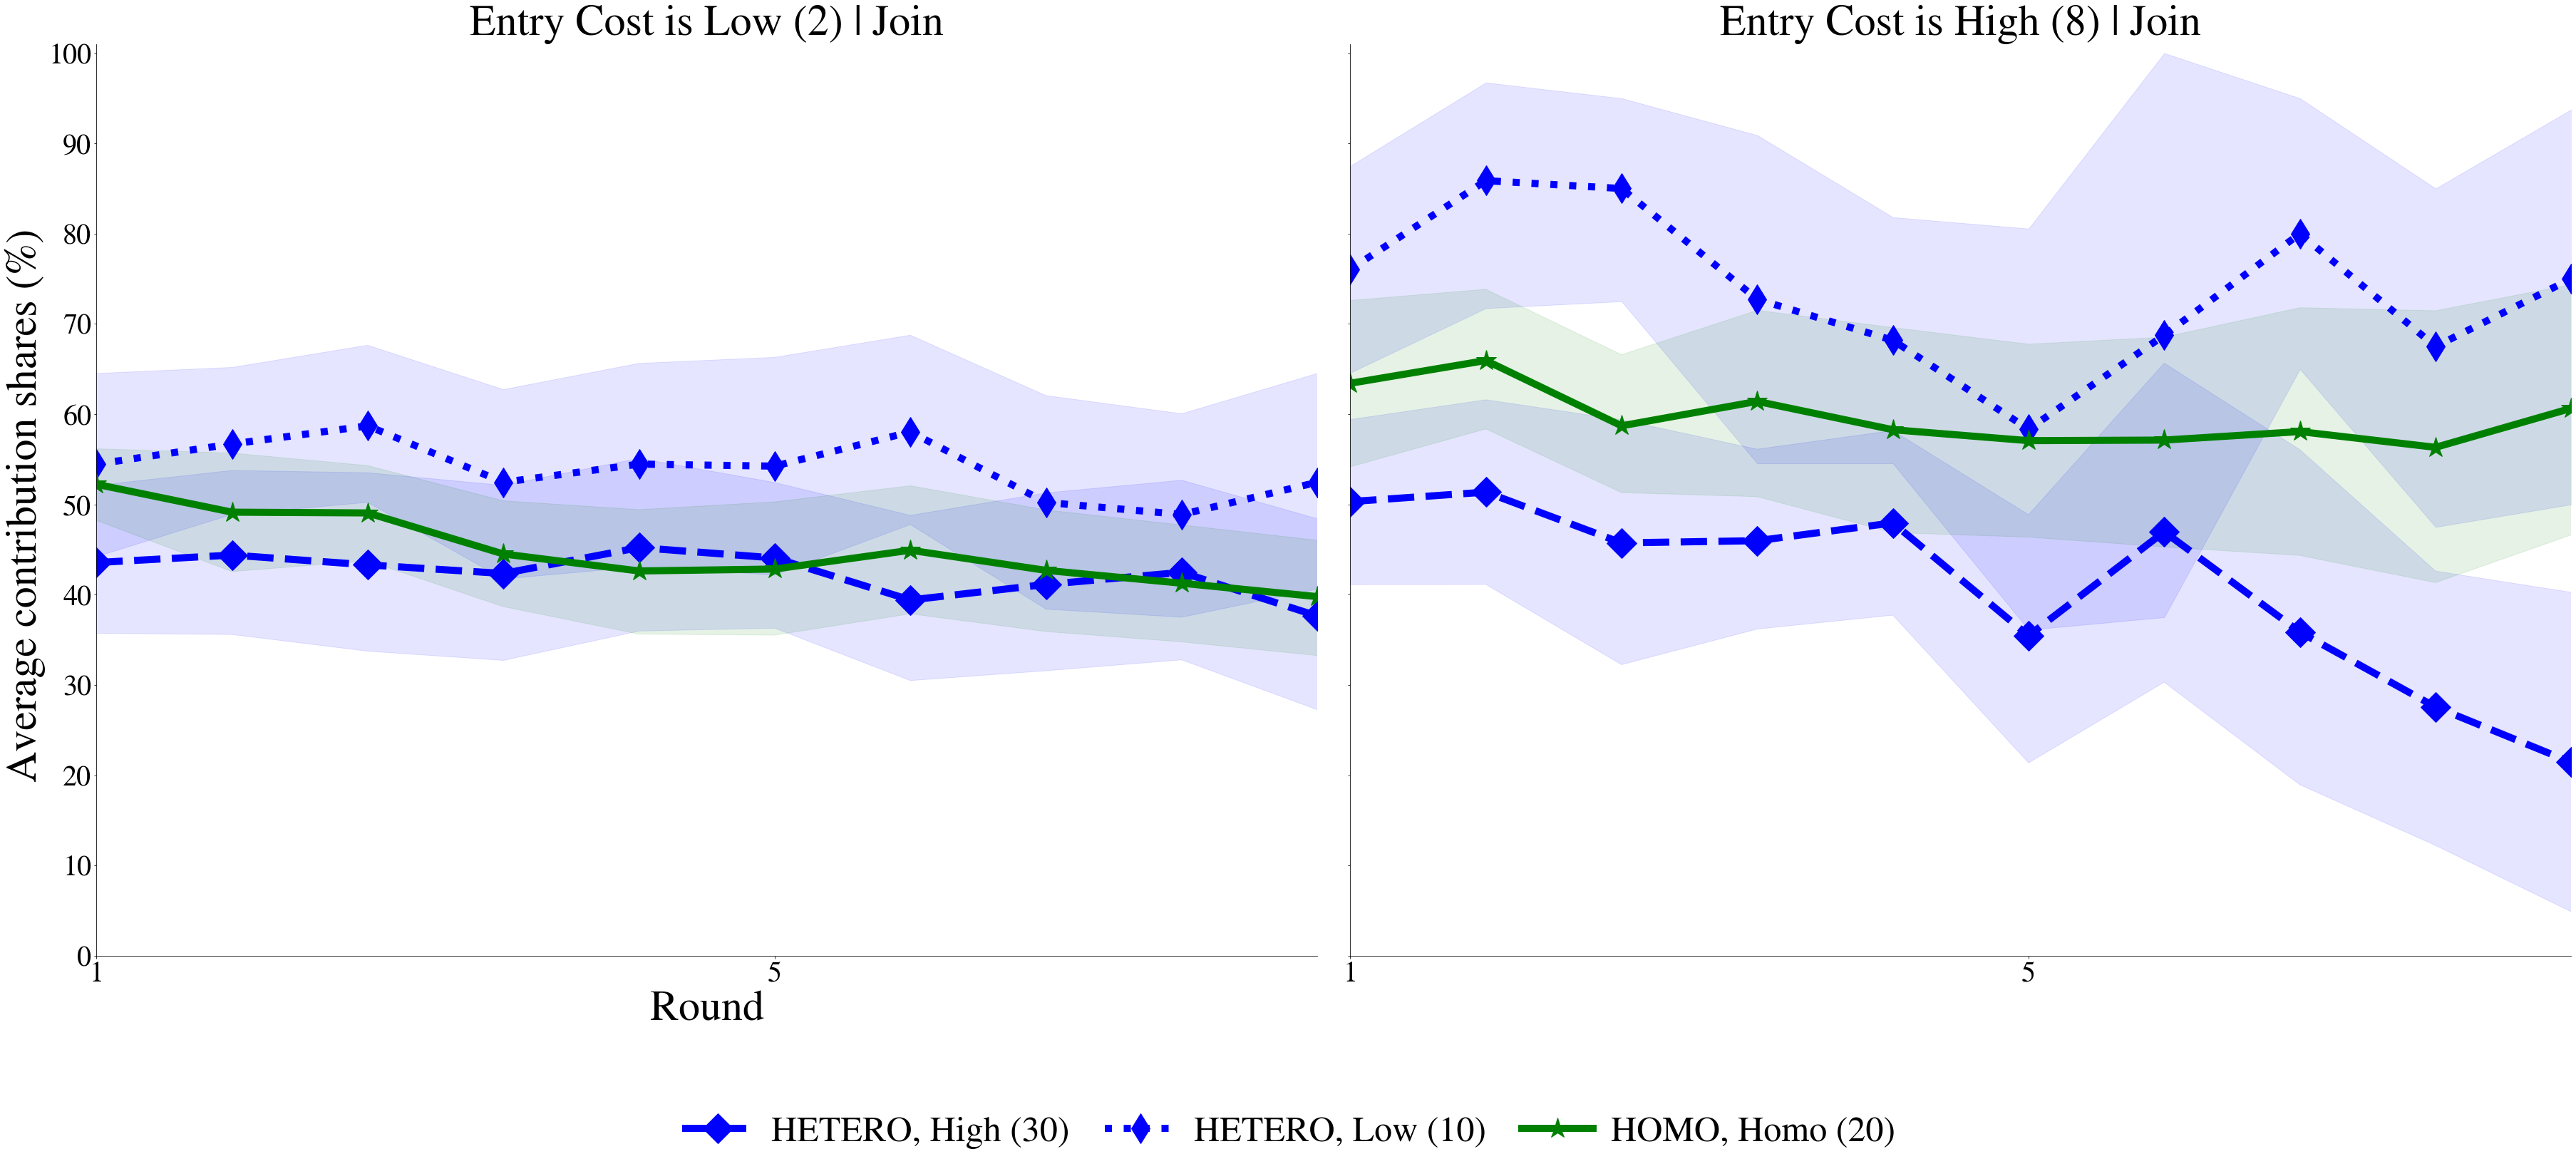

In [18]:
### This is to create the graph for all rounds
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_Oppor[data_Oppor['player.join_club']==1].groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['b','b', 'g', ]
custom_markerfacecolor = ['b', 'b','g']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average contribution shares (%) ', fontsize=60)
axes[0].set_title('Entry Cost is Low (2) | Join', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

axes[1].set_title('Entry Cost is High (8) | Join', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution-JoinOnly.pdf', bbox_inches="tight" )  


### Tradeoff between local and global

Return: 

-[Local + Global Environment](#Local-+-Global-Environment)

In [15]:
treatment_list = ['HETERO','HOMO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
var_of_interest =  [var_l, var_g]
R_max = 10


LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()


output = np.empty((4,2, 3))
output[:]=np.nan

for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==20), v]
        print('index', i,j, t, v)
        output[i, j, 0]=pop_a.mean()
        output[i, j, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==80), v]
        print('index', i+2, j, t,v)
        output[i+2,j, 0]=pop_a.mean()
        output[i+2,j,1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
        
var_of_interest = 'endowment'
LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()
total_e = np.empty((2,2,3))
total_e[:]=np.nan

for i,t in enumerate(treatment_list): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==20), var_of_interest]
    total_e[i,0,0] =pop_a.mean()
    total_e[i, 0, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
    
    pop_b = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==80), var_of_interest]
    total_e[i,1,0] = np.mean(pop_b)
    total_e[i, 1, 1:3]=bootstrap_ci(np.array(pop_b), 10000, np.mean)  
#     print(i,t)

index 0 0 HETERO player.contribution_local
index 0 1 HETERO player.contribution_global
index 1 0 HOMO player.contribution_local
index 1 1 HOMO player.contribution_global
index 2 0 HETERO player.contribution_local
index 2 1 HETERO player.contribution_global
index 3 0 HOMO player.contribution_local
index 3 1 HOMO player.contribution_global


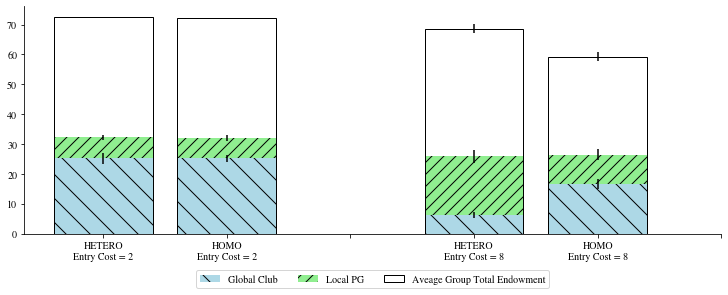

In [162]:
labels=  ['HETERO\nEntry Cost = 2', 'HOMO\nEntry Cost = 2', '','HETERO\nEntry Cost = 8', 'HOMO\nEntry Cost = 8', '']
labels2 = ["Global Club", "Local PG", "Aveage Group Total Endowment"]
colors = ['grey', 'white']
hatchs = ['\\', '//']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))


axes.bar([0,1], output[[0,1],1, 0], 
             yerr=[output[[0,1],1,0]-output[[0,1],1,1], output[[0,1],1,2]-output[[0,1],1,0]],
             label=labels2[0],
             hatch=hatchs[0],
             color = 'lightblue')

axes.bar([0,1], output[[0,1],0, 0], 
             yerr=[output[[0,1],0,0]-output[[0,1],0,1], output[[0,1],0,2]-output[[0,1],0,0]],
          label=labels2[1],
         bottom = output[[0,1],1, 0], 
             hatch=hatchs[1],
             color = 'lightgreen')

axes.bar([0,1], total_e[[0,1],0, 0], 
         yerr=[total_e[[0,1],0,0]-total_e[[0,1],0,1], total_e[[0,1],0,2]-total_e[[0,1],0,0]],
          fill=False, label=labels2[2],
        edgecolor = 'black')

axes.bar([3,4], output[[2,3],1, 0], 
             yerr=[output[[2,3],1,0]-output[[2,3],1,1], output[[2,3],1,2]-output[[2,3],1,0]],
             label=labels2[0],
             hatch=hatchs[0],
             color = 'lightblue')

axes.bar([3,4], output[[2,3],0, 0], 
             yerr=[output[[2,3],0,0]-output[[2,3],0,1], output[[2,3],0,2]-output[[2,3],0,0]],
          label=labels2[1],
         bottom = output[[2,3],1, 0], 
             hatch=hatchs[1],
             color = 'lightgreen')

axes.bar([3,4], total_e[[0,1],1, 0], 
         yerr=[total_e[[0,1],1,0]-total_e[[0,1],1,1], total_e[[0,1],1,2]-total_e[[0,1],1,0]],
          fill=False, label=labels2[2],
        edgecolor = 'black')

axes.set_xticks(x)
axes.set_xticklabels(labels)
axes.legend( labels2, bbox_to_anchor=(.5,-.2), loc="center" , ncol=3)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

In [20]:
data_Oppor['subsession.period'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int64)

In [21]:
# This one uses the bars for FC=2, and FC=8 separately for each round 

treatment_list = ['HETERO','HOMO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
var_e =  'endowment'
var_of_interest =  [var_l, var_g, var_e]
R_max = 20

# Prepare for the first subfigure (sum)
LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()


# Left figure: FC=2
# FC(2,8) * (HETERO,HOMO) * variables (local, global, endowment) * roundN (20) * 3 (mean, upper, lower)


output = np.empty((2,2,3,20, 3))
output[:]=np.nan

for i, endow in enumerate(treatment_list):
    for j,v in enumerate(var_of_interest):
        for r in range(R_max): 
            pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']==r+1)&
                                (LocalGlobal['FC']==20), v]
            print('index', i,endow, j, v, r, 'FC=20')
            output[0, i, j,r, 0]=pop_a.mean()
            output[0, i, j,r, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    

for i, endow in enumerate(treatment_list):
    for j,v in enumerate(var_of_interest):
        for r in range(R_max): 
            pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']==r+1)&
                                (LocalGlobal['FC']==80), v]
            print('index', i,endow, j, v, r, 'FC=80')
            output[1, i, j,r, 0]=pop_a.mean()
            output[1, i, j,r, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean) 



index 0 HETERO 0 player.contribution_local 0 FC=20
index 0 HETERO 0 player.contribution_local 1 FC=20
index 0 HETERO 0 player.contribution_local 2 FC=20
index 0 HETERO 0 player.contribution_local 3 FC=20
index 0 HETERO 0 player.contribution_local 4 FC=20
index 0 HETERO 0 player.contribution_local 5 FC=20
index 0 HETERO 0 player.contribution_local 6 FC=20
index 0 HETERO 0 player.contribution_local 7 FC=20
index 0 HETERO 0 player.contribution_local 8 FC=20
index 0 HETERO 0 player.contribution_local 9 FC=20
index 0 HETERO 0 player.contribution_local 10 FC=20
index 0 HETERO 0 player.contribution_local 11 FC=20
index 0 HETERO 0 player.contribution_local 12 FC=20
index 0 HETERO 0 player.contribution_local 13 FC=20
index 0 HETERO 0 player.contribution_local 14 FC=20
index 0 HETERO 0 player.contribution_local 15 FC=20
index 0 HETERO 0 player.contribution_local 16 FC=20
index 0 HETERO 0 player.contribution_local 17 FC=20
index 0 HETERO 0 player.contribution_local 18 FC=20
index 0 HETERO 0 playe

index 1 HOMO 0 player.contribution_local 8 FC=80
index 1 HOMO 0 player.contribution_local 9 FC=80
index 1 HOMO 0 player.contribution_local 10 FC=80
index 1 HOMO 0 player.contribution_local 11 FC=80
index 1 HOMO 0 player.contribution_local 12 FC=80
index 1 HOMO 0 player.contribution_local 13 FC=80
index 1 HOMO 0 player.contribution_local 14 FC=80
index 1 HOMO 0 player.contribution_local 15 FC=80
index 1 HOMO 0 player.contribution_local 16 FC=80
index 1 HOMO 0 player.contribution_local 17 FC=80
index 1 HOMO 0 player.contribution_local 18 FC=80
index 1 HOMO 0 player.contribution_local 19 FC=80
index 1 HOMO 1 player.contribution_global 0 FC=80
index 1 HOMO 1 player.contribution_global 1 FC=80
index 1 HOMO 1 player.contribution_global 2 FC=80
index 1 HOMO 1 player.contribution_global 3 FC=80
index 1 HOMO 1 player.contribution_global 4 FC=80
index 1 HOMO 1 player.contribution_global 5 FC=80
index 1 HOMO 1 player.contribution_global 6 FC=80
index 1 HOMO 1 player.contribution_global 7 FC=80
in

array([[[[[ 8.28571429,  5.64285714, 11.28571429],
          [ 7.60714286,  4.57053571, 11.10714286],
          [ 7.5       ,  4.53571429, 10.89285714],
          [ 7.42857143,  4.57142857, 10.64285714],
          [ 6.        ,  3.46428571,  8.96428571],
          [ 6.60714286,  3.89285714,  9.75      ],
          [ 7.21428571,  4.32142857, 10.53571429],
          [ 5.85714286,  3.64196429,  8.35714286],
          [ 5.78571429,  2.85714286,  9.17857143],
          [ 5.17857143,  2.92857143,  7.71428571],
          [ 5.1875    ,  2.25      ,  8.5       ],
          [ 4.0625    ,  1.875     ,  6.375     ],
          [ 3.4375    ,  1.5625    ,  5.4375    ],
          [ 4.125     ,  1.9375    ,  6.375     ],
          [ 4.75      ,  1.875     ,  8.0625    ],
          [ 3.25      ,  1.1875    ,  5.6890625 ],
          [ 4.125     ,  1.8125    ,  6.6875    ],
          [ 4.        ,  1.5       ,  6.9375    ],
          [ 4.875     ,  1.8734375 ,  8.3125    ],
          [ 3.75      ,  1.6875

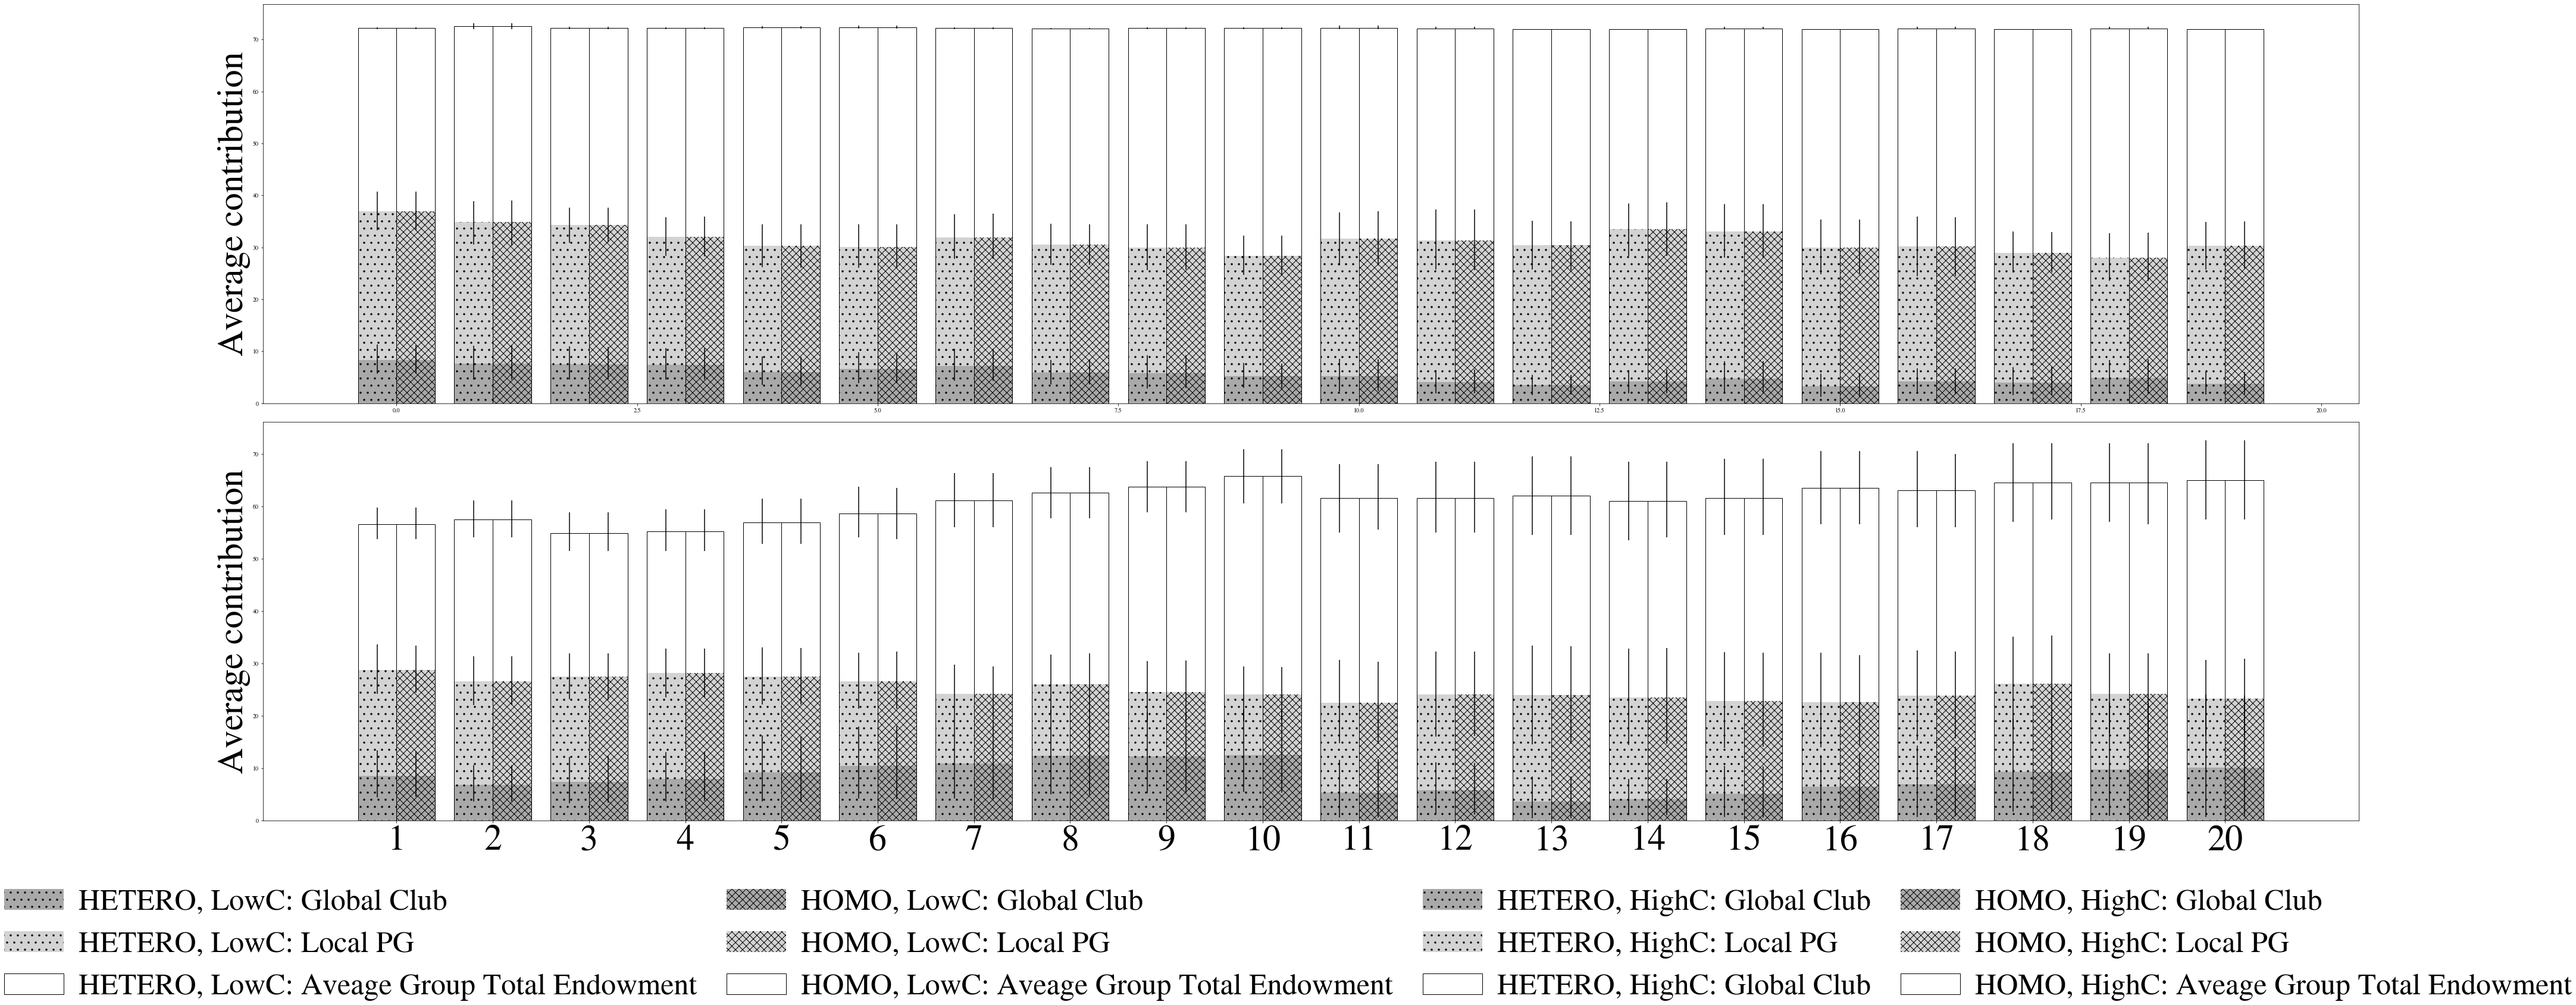

In [40]:
### Separate data and the figure drawing
pd.set_option('plotting.backend', 'matplotlib')

fig, axes = plt.subplots(nrows=2, ncols=1,  sharex=False,  sharey=False,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# First figure
# labels=  ['HETERO\n $\hspace{5}$ Entry Cost = 2', 'HOMO', '','HETERO\n $\hspace{5}$ Entry Cost = 8', 'HOMO', '']
# labels2 = ["Global Club", "Local PG", "Aveage Group Total Endowment"]
# colors = ['grey', 'white']
# hatchs = ['\\', '//']


labels = [str(i+1) for i in range(R_max)]
labels2 = ["Global Club", "Local PG", "Aveage Group Total Endowment"]
colors = ['grey', 'white']
hatchs = ['.', 'xx']

x = np.arange(len(labels))
width = 0.4
x1 = [i-width/2 for i in range(R_max)]
x2 = [i+width/2 for i in range(R_max)]

# Left panel: fc =2 
# HETERO
axes[0].bar(x1,output[0,0,0,:,0], width, 
             yerr=[output[0,0,0,:,0]-output[0,0,0,:,1],output[0,0,0,:,2]-output[0,0,0,:,0]],
             label='HETERO, ' + 'LowC: ' + labels2[0],
             hatch=hatchs[0],
             color = 'darkgrey')

axes[0].bar(x1, output[0,0,1,:,0], width, 
             yerr=[output[0,0,1,:,0]-output[0,0,1,:,1], output[0,0,1,:,2]-output[0,0,1,:,0]],
          label='HETERO, ' + 'LowC: ' + labels2[1],
         bottom = output[0,0,0,:,0], 
             hatch=hatchs[0],
             color = 'lightgrey')

axes[0].bar(x1, output[0,0,2,:,0], width, 
         yerr=[ output[0,0,2,:,0]- output[0,0,2,:,1],  output[0,0,2,:,2]- output[0,0,2,:,0]],
          fill=False, label='HETERO, ' + 'LowC: ' + labels2[2],
        edgecolor = 'black')

# HOMO
axes[0].bar(x2,output[0,1,0,:,0], width, 
             yerr=[output[0,1,0,:,0]-output[0,1,0,:,1],output[0,1,0,:,2]-output[0,1,0,:,0]],
             label='HOMO, ' + 'LowC: ' + labels2[0],
             hatch=hatchs[1],
             color = 'darkgrey')

axes[0].bar(x2, output[0,1,1,:,0], width, 
             yerr=[output[0,1,1,:,0]-output[0,1,1,:,1], output[0,1,1,:,2]-output[0,1,1,:,0]],
          label='HOMO, ' + 'LowC: ' + labels2[1],
         bottom = output[0,1,0,:,0], 
             hatch=hatchs[1],
             color = 'lightgrey')

axes[0].bar(x2, output[0,1,2,:,0], width, 
         yerr=[ output[0,1,2,:,0]- output[0,1,2,:,1],  output[0,1,2,:,2]- output[0,1,2,:,0]],
          fill=False, label='HOMO, ' + 'LowC: ' + labels2[2],
        edgecolor = 'black')


# Right panel
# HETERO
axes[1].bar(x1,output[1,0,0,:,0], width, 
             yerr=[output[1,0,0,:,0]-output[1,0,0,:,1],output[1,0,0,:,2]-output[1,0,0,:,0]],
             label='HETERO, ' + 'HighC: ' + labels2[0],
             hatch=hatchs[0],
             color = 'darkgrey')

axes[1].bar(x1, output[1,0,1,:,0], width, 
             yerr=[output[1,0,1,:,0]-output[1,0,1,:,1], output[1,0,1,:,2]-output[1,0,1,:,0]],
          label='HETERO, ' + 'HighC: ' + labels2[1],
         bottom = output[1,0,0,:,0], 
             hatch=hatchs[0],
             color = 'lightgrey')

axes[1].bar(x1, output[1,0,2,:,0], width, 
         yerr=[ output[1,0,2,:,0]- output[1,0,2,:,1],  output[1,0,2,:,2]- output[1,0,2,:,0]],
          fill=False, label='HETERO, ' + 'HighC: ' + labels2[0],
        edgecolor = 'black')

# HOMO
axes[1].bar(x2,output[1,1,0,:,0], width, 
             yerr=[output[1,1,0,:,0]-output[1,1,0,:,1],output[1,1,0,:,2]-output[1,1,0,:,0]],
             label='HOMO, ' + 'HighC: ' + labels2[0],
             hatch=hatchs[1],
             color = 'darkgrey')

axes[1].bar(x2, output[1,1,1,:,0], width, 
             yerr=[output[1,1,1,:,0]-output[1,1,1,:,1], output[1,1,1,:,2]-output[1,1,1,:,0]],
          label='HOMO, ' + 'HighC: ' + labels2[1],
         bottom = output[1,1,0,:,0], 
             hatch=hatchs[1],
             color = 'lightgrey')

axes[1].bar(x2, output[1,1,2,:,0], width, 
         yerr=[ output[1,1,2,:,0]- output[1,1,2,:,1],  output[1,1,2,:,2]- output[1,1,2,:,0]],
          fill=False, label='HOMO, ' + 'HighC: ' + labels2[2],
        edgecolor = 'black')


axes[1].set_xticks(x)
axes[1].set_xticklabels(labels,multialignment='center',fontsize=60)

axes[0].set_ylabel('Average contribution', fontsize=60)
axes[1].set_ylabel('Average contribution', fontsize=60)

# for i in range(3):
#     axes[i].spines['top'].set_visible(False)
#     axes[i].spines['right'].set_visible(False)  
#     axes[i].tick_params(axis='x', labelsize=40)
#     axes[i].tick_params(axis='y', labelsize=40)


# handles, labels = axes[0].get_legend_handles_labels() 
# handles2, labels2 = axes[1].get_legend_handles_labels() 
# fig.legend(handles[:3]+handles2, labels[0:3]+labels2, bbox_to_anchor=(.5,-.1), loc="center" , ncol=4 , fontsize=50,
#                borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.legend( bbox_to_anchor=(.5,-.1), loc="center" , ncol=4 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
# fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution-Tradeoff.pdf', bbox_inches="tight" )  


In [189]:


treatment_list = ['HETERO','HOMO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
var_of_interest =  [var_l, var_g]
R_max = 10

# Prepare for the first subfigure (sum)
LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()


output = np.empty((4,2, 3))
output[:]=np.nan

for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==20), v]
        print('index', i,j, t, v)
        output[i, j, 0]=pop_a.mean()
        output[i, j, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==80), v]
        print('index', i+2, j, t,v)
        output[i+2,j, 0]=pop_a.mean()
        output[i+2,j,1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
        
var_of_interest = 'endowment'
LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()
total_e = np.empty((2,2,3))
total_e[:]=np.nan

for i,t in enumerate(treatment_list): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==20), var_of_interest]
    total_e[i,0,0] =pop_a.mean()
    total_e[i, 0, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
    
    pop_b = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==80), var_of_interest]
    total_e[i,1,0] = np.mean(pop_b)
    total_e[i, 1, 1:3]=bootstrap_ci(np.array(pop_b), 10000, np.mean)  
#     print(i,t)

# Treatment by endowment (mean)
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
var_of_interest =  [var_l, var_g]
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()


# Left graph for FC=2
output1 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_l,treatment_var,treatment_list , 20)

df1 = pd.DataFrame(output1[0,:,:], columns = treatment_list)
df_ci_l1 = pd.DataFrame(output1[1,:,:], columns = treatment_list)
df_ci_u1 = pd.DataFrame(output1[2,:,:], columns = treatment_list)

output2 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_g,treatment_var,treatment_list , 20)

df2 = pd.DataFrame(output2[0,:,:], columns = treatment_list)
df_ci_l2 = pd.DataFrame(output2[1,:,:], columns = treatment_list)
df_ci_u2 = pd.DataFrame(output2[2,:,:], columns = treatment_list)


# right graph for absolute value 

output1 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_l,treatment_var,treatment_list , 20)

dfr1 = pd.DataFrame(output1[0,:,:], columns = treatment_list)
df_ci_lr1 = pd.DataFrame(output1[1,:,:], columns = treatment_list)
df_ci_ur1 = pd.DataFrame(output1[2,:,:], columns = treatment_list)

output2 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_g,treatment_var,treatment_list , 20)

dfr2 = pd.DataFrame(output2[0,:,:], columns = treatment_list)
df_ci_lr2 = pd.DataFrame(output2[1,:,:], columns = treatment_list)
df_ci_ur2 = pd.DataFrame(output2[2,:,:], columns = treatment_list)

index 0 0 HETERO player.contribution_local
index 0 1 HETERO player.contribution_global
index 1 0 HOMO player.contribution_local
index 1 1 HOMO player.contribution_global
index 2 0 HETERO player.contribution_local
index 2 1 HETERO player.contribution_global
index 3 0 HOMO player.contribution_local
index 3 1 HOMO player.contribution_global


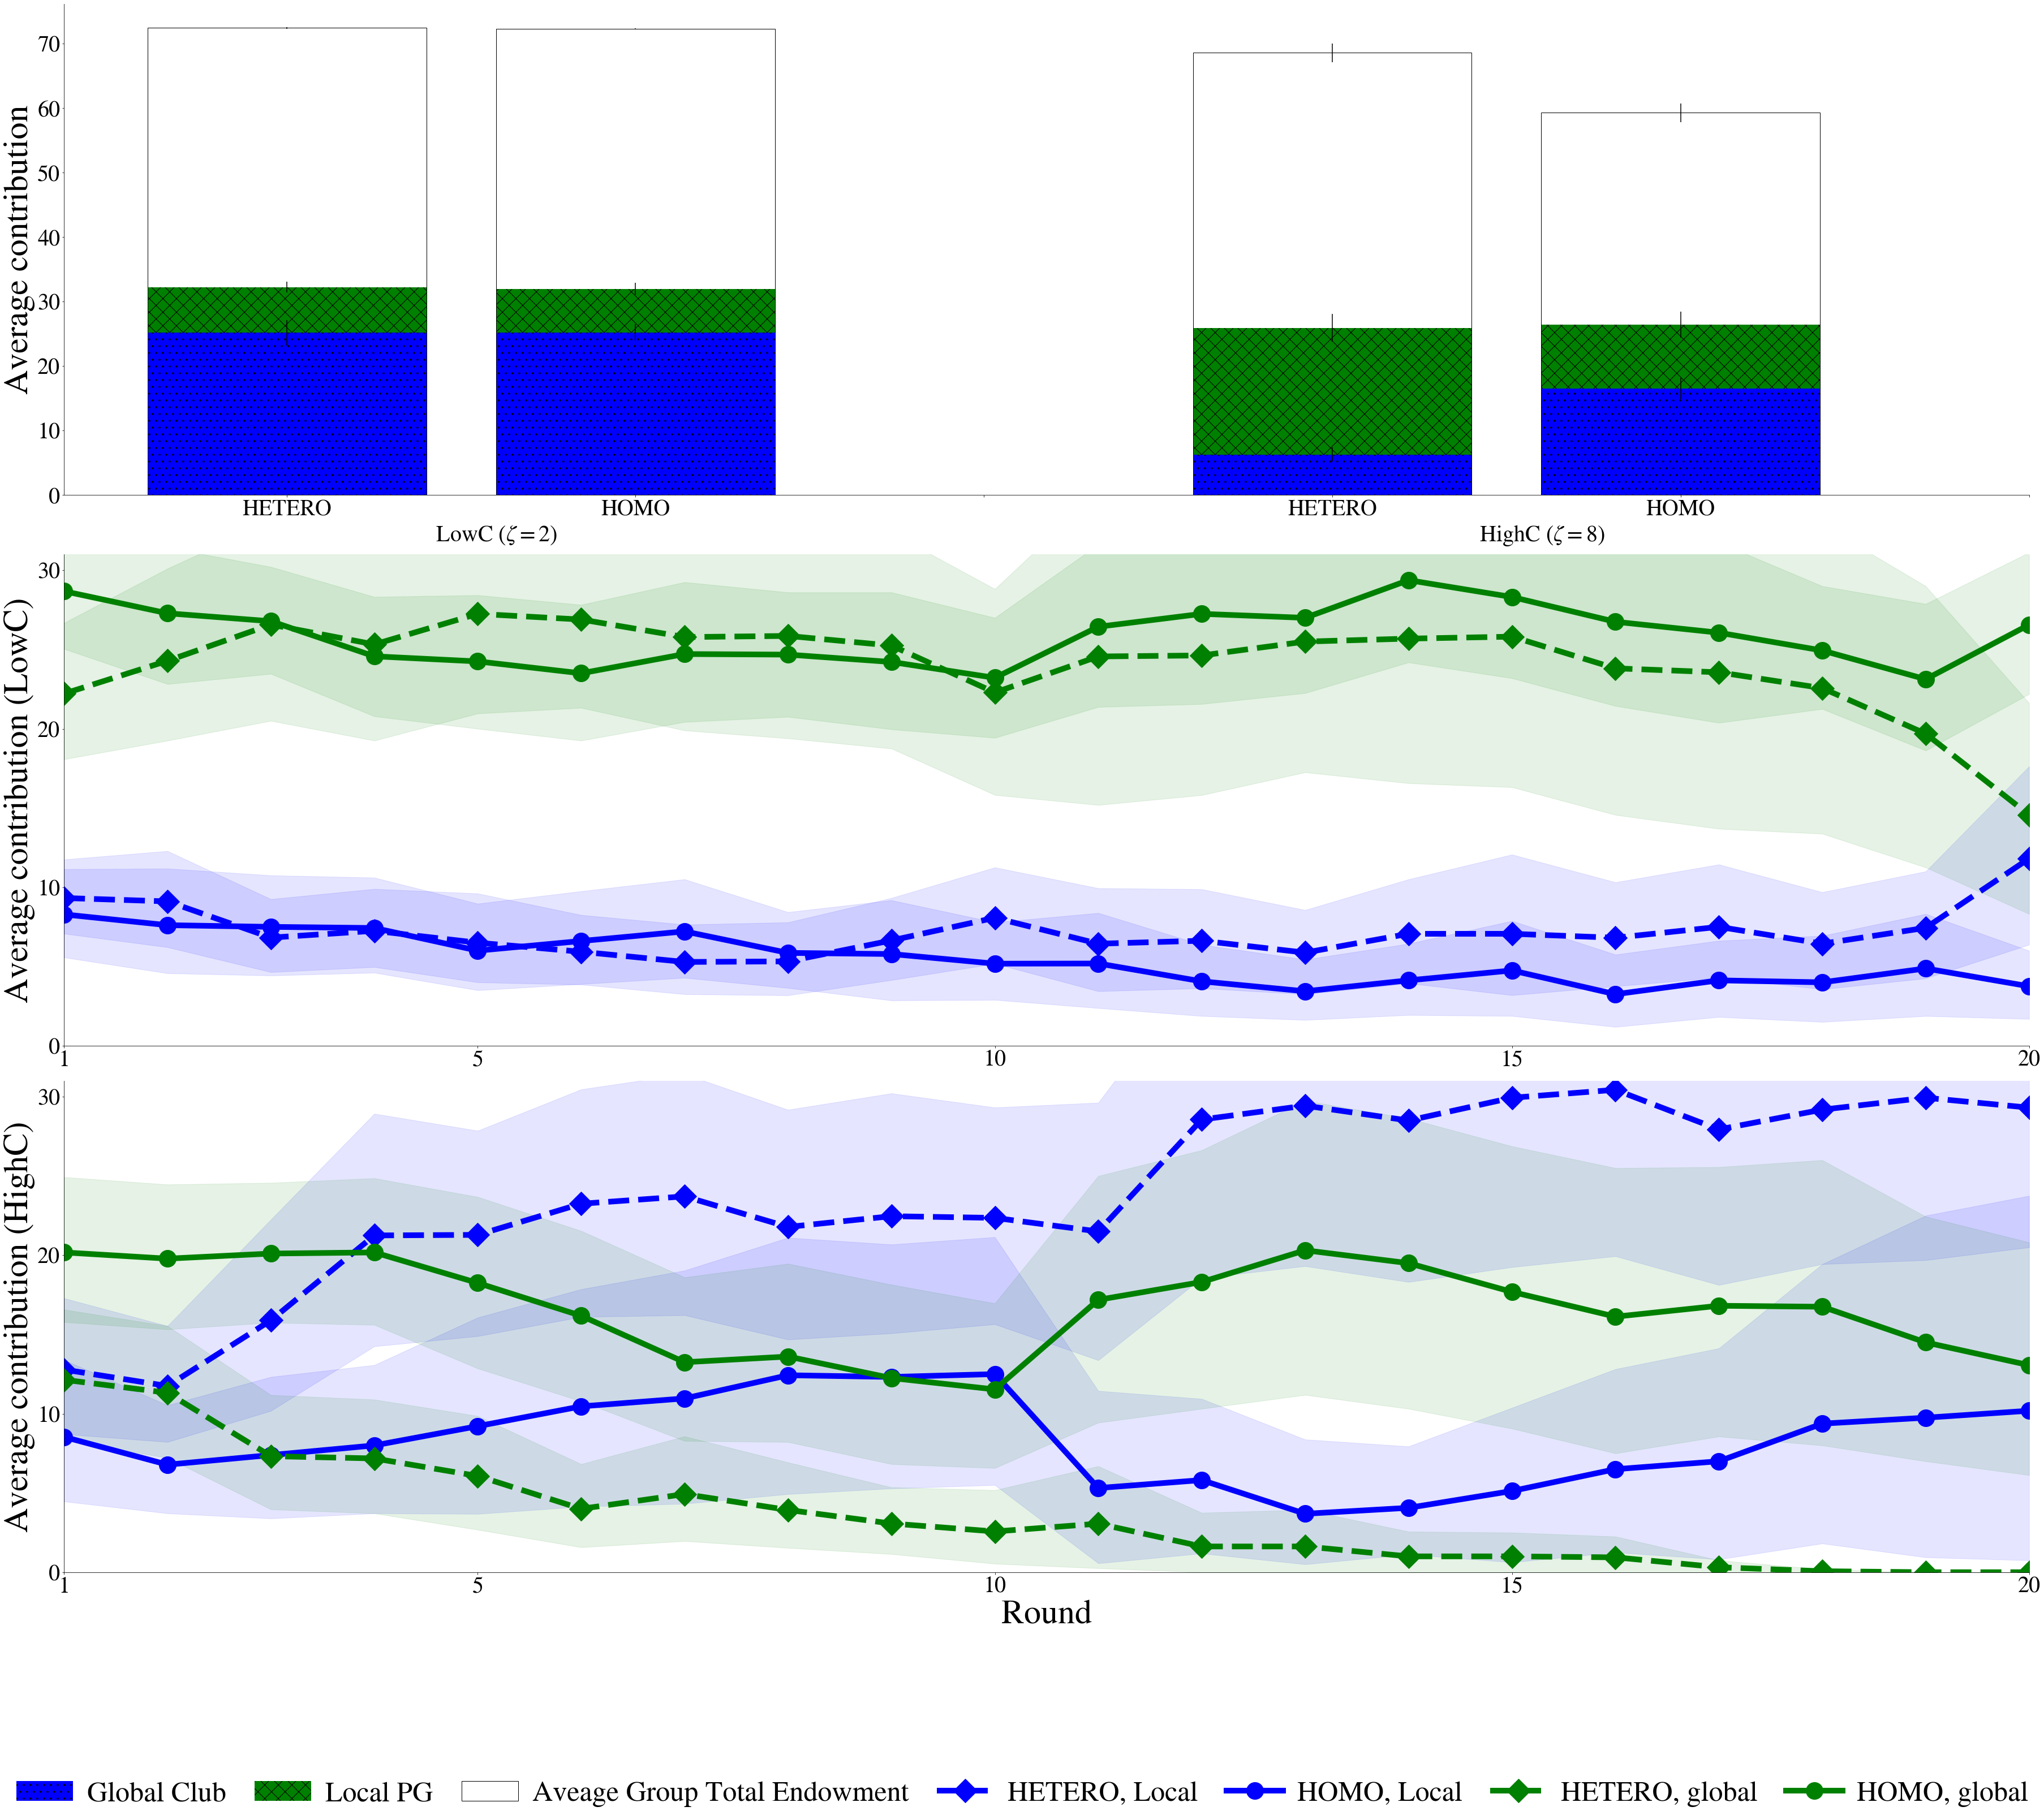

In [69]:
### Separate data and the figure drawing
pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=3, ncols=1,  sharex=False,  
#                          sharey=False,  
                         constrained_layout=True, figsize=(50, 40))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# First figure
labels=  ['HETERO\n $\hspace{25}$ LowC ($\zeta = 2$)', 'HOMO', '','HETERO\n $\hspace{25}$ HighC ($\zeta = 8$)', 'HOMO', '']
labels2 = ["Global Club", "Local PG", "Aveage Group Total Endowment"]
colors = ['grey', 'white']
hatchs = ['.', 'x']
x = np.arange(len(labels))

axes[0].bar([0,1], output[[0,1],1, 0], 
             yerr=[output[[0,1],1,0]-output[[0,1],1,1], output[[0,1],1,2]-output[[0,1],1,0]],
             label=labels2[0],
             hatch=hatchs[0],
             color = 'blue')

axes[0].bar([0,1], output[[0,1],0, 0], 
             yerr=[output[[0,1],0,0]-output[[0,1],0,1], output[[0,1],0,2]-output[[0,1],0,0]],
          label=labels2[1],
         bottom = output[[0,1],1, 0], 
             hatch=hatchs[1],
             color = 'green')

axes[0].bar([0,1], total_e[[0,1],0, 0], 
         yerr=[total_e[[0,1],0,0]-total_e[[0,1],0,1], total_e[[0,1],0,2]-total_e[[0,1],0,0]],
          fill=False, label=labels2[2],
        edgecolor = 'black')

axes[0].bar([3,4], output[[2,3],1, 0], 
             yerr=[output[[2,3],1,0]-output[[2,3],1,1], output[[2,3],1,2]-output[[2,3],1,0]],
             label=labels2[0],
             hatch=hatchs[0],
             color = 'blue')

axes[0].bar([3,4], output[[2,3],0, 0], 
             yerr=[output[[2,3],0,0]-output[[2,3],0,1], output[[2,3],0,2]-output[[2,3],0,0]],
          label=labels2[1],
         bottom = output[[2,3],1, 0], 
             hatch=hatchs[1],
             color = 'green')

axes[0].bar([3,4], total_e[[0,1],1, 0], 
         yerr=[total_e[[0,1],1,0]-total_e[[0,1],1,1], total_e[[0,1],1,2]-total_e[[0,1],1,0]],
          fill=False, label=labels2[2],
        edgecolor = 'black')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels,multialignment='center',fontsize=60)

axes[0].set_ylabel('Average contribution', fontsize=60)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 19)
custom_ylim = (0, 31)
custom_ytick = np.arange(0,31,step=10)
custom_xtick = np.array([0,4,9,14,19])
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    
custom_markercolor = ['blue', 'blue', ]
custom_markerfacecolor = ['blue', 'blue']
custom_linestyle = ['--','-']

for j, yy in enumerate(treatment_list):
    axes[1].plot(df1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_u1.index, df_ci_u1[yy],df_ci_l1[yy], alpha=0.1, color=custom_markercolor[j])

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    

custom_markercolor = ['green', 'green' ]
custom_markerfacecolor = ['green', 'green']
custom_linestyle = ['--','-']


for j, yy in enumerate(treatment_list):
    axes[1].plot(df2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_u2.index, df_ci_u2[yy],df_ci_l2[yy], alpha=0.1, color=custom_markercolor[j])

    
    
# axes[1].set_xlabel('Round', fontsize=60)
axes[2].set_xlabel('Round', fontsize=60)
# axes[1].set_ylabel('Average contribution', fontsize=60)
# axes[1].set_title('LowC', fontsize=60)
axes[1].set_ylabel('Average contribution (LowC)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[2], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    
custom_markercolor = ['blue', 'blue', ]
custom_markerfacecolor = ['blue', 'blue']
custom_linestyle = ['--','-']



for j, yy in enumerate(treatment_list):
    axes[2].plot(dfr1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[2].fill_between(df_ci_ur1.index, df_ci_ur1[yy],df_ci_lr1[yy], alpha=0.1, color=custom_markercolor[j])

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    
custom_markercolor = ['green','green', ]
custom_markerfacecolor = ['green', 'green']
custom_linestyle = ['--','-']


for j, yy in enumerate(treatment_list):
    axes[2].plot(dfr2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[2].fill_between(df_ci_ur2.index, df_ci_ur2[yy],df_ci_lr2[yy], alpha=0.1, color=custom_markercolor[j])

    
# axes[2].set_title('HighC', fontsize=60)
axes[2].set_ylabel('Average contribution (HighC)', fontsize=60)


for i in range(3):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)


handles, labels = axes[0].get_legend_handles_labels() 
handles2, labels2 = axes[1].get_legend_handles_labels() 
fig.legend( handles[:3]+handles2, labels[0:3]+labels2, bbox_to_anchor=(.5,-.1), loc="center" , ncol=8 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution-Tradeoff.pdf', bbox_inches="tight" )  


In [190]:
# To add the simulation



treatment_list = ['HETERO','HOMO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
var_of_interest =  [var_l, var_g]
R_max = 10

# Prepare for the first subfigure (sum)
LocalGlobal = data_OpporSim.groupby([ 
                     treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()


outputSim = np.empty((4,2, 3))
outputSim[:]=np.nan

for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==20), v]
        print('index', i,j, t, v)
        outputSim[i, j, 0]=pop_a.mean()
        outputSim[i, j, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==80), v]
        print('index', i+2, j, t,v)
        outputSim[i+2,j, 0]=pop_a.mean()
        outputSim[i+2,j,1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
        
var_of_interest = 'endowment'
LocalGlobal = data_OpporSim.groupby([ 
                     treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()
total_eSim = np.empty((2,2,3))
total_eSim[:]=np.nan

for i,t in enumerate(treatment_list): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==20), var_of_interest]
    total_eSim[i,0,0] =pop_a.mean()
    total_eSim[i, 0, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
    
    pop_b = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==80), var_of_interest]
    total_eSim[i,1,0] = np.mean(pop_b)
    total_eSim[i, 1, 1:3]=bootstrap_ci(np.array(pop_b), 10000, np.mean)  
#     print(i,t)

# Treatment by endowment (mean)
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
var_of_interest =  [var_l, var_g]
LocalOnly = data_OpporSim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()


# Left graph for FC=2
output1 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_l,treatment_var,treatment_list , 20)

df1Sim = pd.DataFrame(output1[0,:,:], columns = treatment_list)
df_ci_l1Sim = pd.DataFrame(output1[1,:,:], columns = treatment_list)
df_ci_u1Sim = pd.DataFrame(output1[2,:,:], columns = treatment_list)

output2 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_g,treatment_var,treatment_list , 20)

df2Sim = pd.DataFrame(output2[0,:,:], columns = treatment_list)
df_ci_l2Sim = pd.DataFrame(output2[1,:,:], columns = treatment_list)
df_ci_u2Sim = pd.DataFrame(output2[2,:,:], columns = treatment_list)


# right graph for absolute value 

output1 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_l,treatment_var,treatment_list , 20)

dfr1Sim = pd.DataFrame(output1[0,:,:], columns = treatment_list)
df_ci_lr1Sim = pd.DataFrame(output1[1,:,:], columns = treatment_list)
df_ci_ur1Sim = pd.DataFrame(output1[2,:,:], columns = treatment_list)

output2 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_g,treatment_var,treatment_list , 20)

dfr2Sim = pd.DataFrame(output2[0,:,:], columns = treatment_list)
df_ci_lr2Sim = pd.DataFrame(output2[1,:,:], columns = treatment_list)
df_ci_ur2Sim = pd.DataFrame(output2[2,:,:], columns = treatment_list)

index 0 0 HETERO player.contribution_local
index 0 1 HETERO player.contribution_global
index 1 0 HOMO player.contribution_local
index 1 1 HOMO player.contribution_global
index 2 0 HETERO player.contribution_local
index 2 1 HETERO player.contribution_global
index 3 0 HOMO player.contribution_local
index 3 1 HOMO player.contribution_global


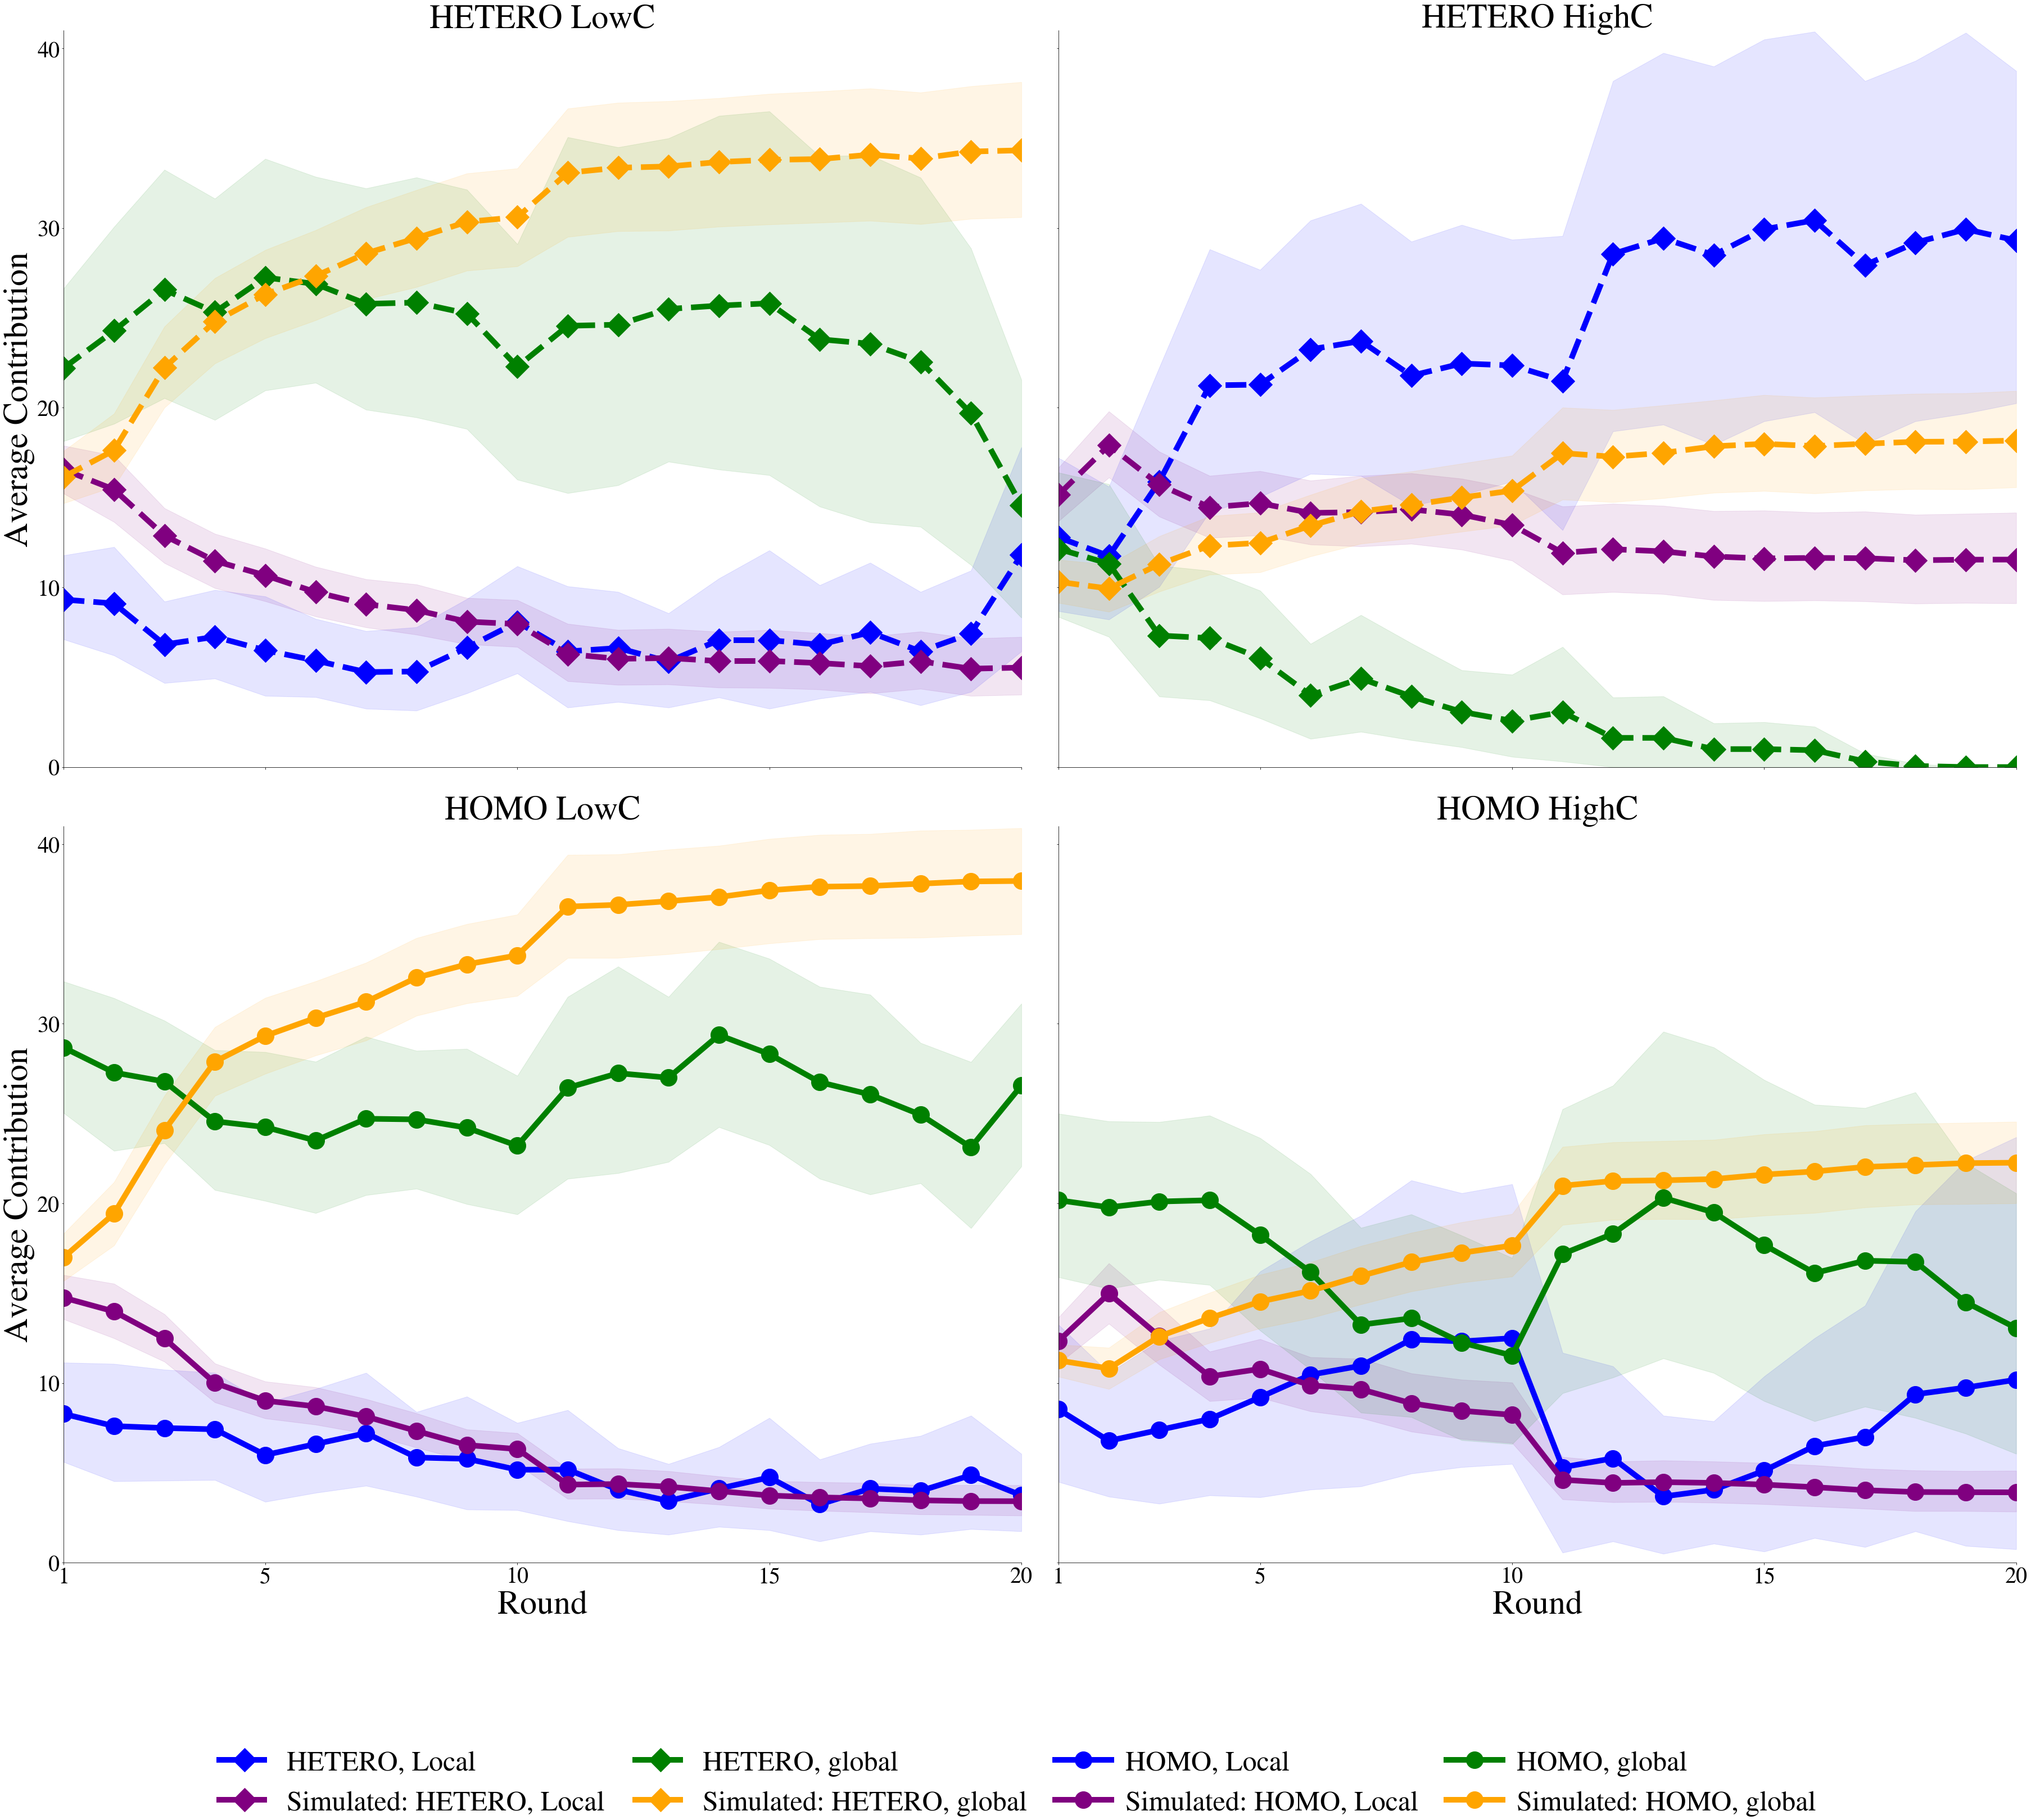

In [210]:
### Separate data and the figure drawing
pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=2, ncols=2,  sharex=True,  
                         sharey=True,  
                         constrained_layout=True, figsize=(50, 40))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# First figure
# labels=  ['HETERO\n $\hspace{25}$ LowC ($\zeta = 2$)', 'HOMO', '','HETERO\n $\hspace{25}$ HighC ($\zeta = 8$)', 'HOMO', '']
# labels2 = ["Global Club", "Local PG", "Aveage Group Total Endowment"]
# colors = ['grey', 'white']
# hatchs = ['.', 'x']
# x = np.arange(len(labels))

# axes[0].bar([0,1], output[[0,1],1, 0], 
#              yerr=[output[[0,1],1,0]-output[[0,1],1,1], output[[0,1],1,2]-output[[0,1],1,0]],
#              label=labels2[0],
#              hatch=hatchs[0],
#              color = 'blue')

# axes[0].bar([0,1], output[[0,1],0, 0], 
#              yerr=[output[[0,1],0,0]-output[[0,1],0,1], output[[0,1],0,2]-output[[0,1],0,0]],
#           label=labels2[1],
#          bottom = output[[0,1],1, 0], 
#              hatch=hatchs[1],
#              color = 'green')

# axes[0].bar([0,1], total_e[[0,1],0, 0], 
#          yerr=[total_e[[0,1],0,0]-total_e[[0,1],0,1], total_e[[0,1],0,2]-total_e[[0,1],0,0]],
#           fill=False, label=labels2[2],
#         edgecolor = 'black')

# axes[0].bar([3,4], output[[2,3],1, 0], 
#              yerr=[output[[2,3],1,0]-output[[2,3],1,1], output[[2,3],1,2]-output[[2,3],1,0]],
#              label=labels2[0],
#              hatch=hatchs[0],
#              color = 'blue')

# axes[0].bar([3,4], output[[2,3],0, 0], 
#              yerr=[output[[2,3],0,0]-output[[2,3],0,1], output[[2,3],0,2]-output[[2,3],0,0]],
#           label=labels2[1],
#          bottom = output[[2,3],1, 0], 
#              hatch=hatchs[1],
#              color = 'green')

# axes[0].bar([3,4], total_e[[0,1],1, 0], 
#          yerr=[total_e[[0,1],1,0]-total_e[[0,1],1,1], total_e[[0,1],1,2]-total_e[[0,1],1,0]],
#           fill=False, label=labels2[2],
#         edgecolor = 'black')
# axes[0].set_xticks(x)
# axes[0].set_xticklabels(labels,multialignment='center',fontsize=60)

# axes[0].set_ylabel('Average contribution', fontsize=60)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 19)
custom_ylim = (0, 41)
custom_ytick = np.arange(0,41,step=10)
custom_xtick = np.array([0,4,9,14,19])
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    
custom_markercolor = ['blue', 'blue', ]
custom_markerfacecolor = ['blue', 'blue']
custom_linestyle = ['--','-']

for j, yy in enumerate(treatment_list):
    axes[j,0].plot(df1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[j,0].fill_between(df_ci_u1.index, df_ci_u1[yy],df_ci_l1[yy], alpha=0.1, color=custom_markercolor[j])
    axes[j,0].plot(df1Sim[yy], label='Simulated: '+yy+', Local', marker=treatment_marker[yy], c='purple',
                         ls=custom_linestyle[j],markerfacecolor='purple',
                         linewidth=10,  markersize=30 )
    axes[j,0].fill_between(df_ci_u1Sim.index, df_ci_u1Sim[yy],df_ci_l1Sim[yy], alpha=0.1, color='purple')

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    

custom_markercolor = ['green', 'green' ]
custom_markerfacecolor = ['green', 'green']
custom_linestyle = ['--','-']


for j, yy in enumerate(treatment_list):
    axes[j,0].plot(df2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[j,0].fill_between(df_ci_u2.index, df_ci_u2[yy],df_ci_l2[yy], alpha=0.1, color=custom_markercolor[j])
    axes[j,0].plot(df2Sim[yy], label='Simulated: '+ yy+', global', marker=treatment_marker[yy], c='orange', 
                         ls=custom_linestyle[j],markerfacecolor='orange',
                         linewidth=10,  markersize=30 )
    axes[j,0].fill_between(df_ci_u2Sim.index, df_ci_u2Sim[yy],df_ci_l2Sim[yy], alpha=0.1, color='orange')
    

    

axes[0,0].set_ylabel('Average Contribution', fontsize=60)
axes[0,0].set_title(treatment_list[0]+' LowC', fontsize=60)
axes[1,0].set_title(treatment_list[1]+' LowC', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    
custom_markercolor = ['blue', 'blue', ]
custom_markerfacecolor = ['blue', 'blue']
custom_linestyle = ['--','-']



for j, yy in enumerate(treatment_list):
    axes[j,1].plot(dfr1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[j,1].fill_between(df_ci_ur1.index, df_ci_ur1[yy],df_ci_lr1[yy], alpha=0.1, color=custom_markercolor[j])
    axes[j,1].plot(dfr1Sim[yy], label='Simulated: '+yy+', Local', marker=treatment_marker[yy], c='purple', 
                         ls=custom_linestyle[j],markerfacecolor='purple',
                         linewidth=10,  markersize=30 )
    axes[j,1].fill_between(df_ci_ur1Sim.index, df_ci_ur1Sim[yy],df_ci_lr1Sim[yy], alpha=0.1, color='purple')

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    
custom_markercolor = ['green','green', ]
custom_markerfacecolor = ['green', 'green']
custom_linestyle = ['--','-']


for j, yy in enumerate(treatment_list):
    axes[j,1].plot(dfr2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[j,1].fill_between(df_ci_ur2.index, df_ci_ur2[yy],df_ci_lr2[yy], alpha=0.1, color=custom_markercolor[j])
    axes[j,1].plot(dfr2Sim[yy], label='Simulated: '+yy+', global', marker=treatment_marker[yy], c='orange', 
                         ls=custom_linestyle[j],markerfacecolor='orange',
                         linewidth=10,  markersize=30 )
    axes[j,1].fill_between(df_ci_ur2Sim.index, df_ci_ur2Sim[yy],df_ci_lr2Sim[yy], alpha=0.1, color='orange')

    
axes[1,0].set_ylabel('Average Contribution', fontsize=60)
axes[0,1].set_title(treatment_list[0]+' HighC', fontsize=60)
axes[1,1].set_title(treatment_list[1]+' HighC', fontsize=60)


axes[1,0].set_xlabel('Round', fontsize=60)
axes[1,1].set_xlabel('Round', fontsize=60)

for i in range(2):
    for j in range(2):
        axes[i,j].spines['top'].set_visible(False)
        axes[i,j].spines['right'].set_visible(False)  
        axes[i,j].tick_params(axis='x', labelsize=40)
        axes[i,j].tick_params(axis='y', labelsize=40)

handles, labels = axes[0,0].get_legend_handles_labels() 
handles2, labels2 = axes[1,0].get_legend_handles_labels() 
fig.legend( handles+handles2, labels+labels2, bbox_to_anchor=(.5,-.1), loc="center" , ncol=4 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution-Tradeoff-add-simulation.pdf', bbox_inches="tight" )  


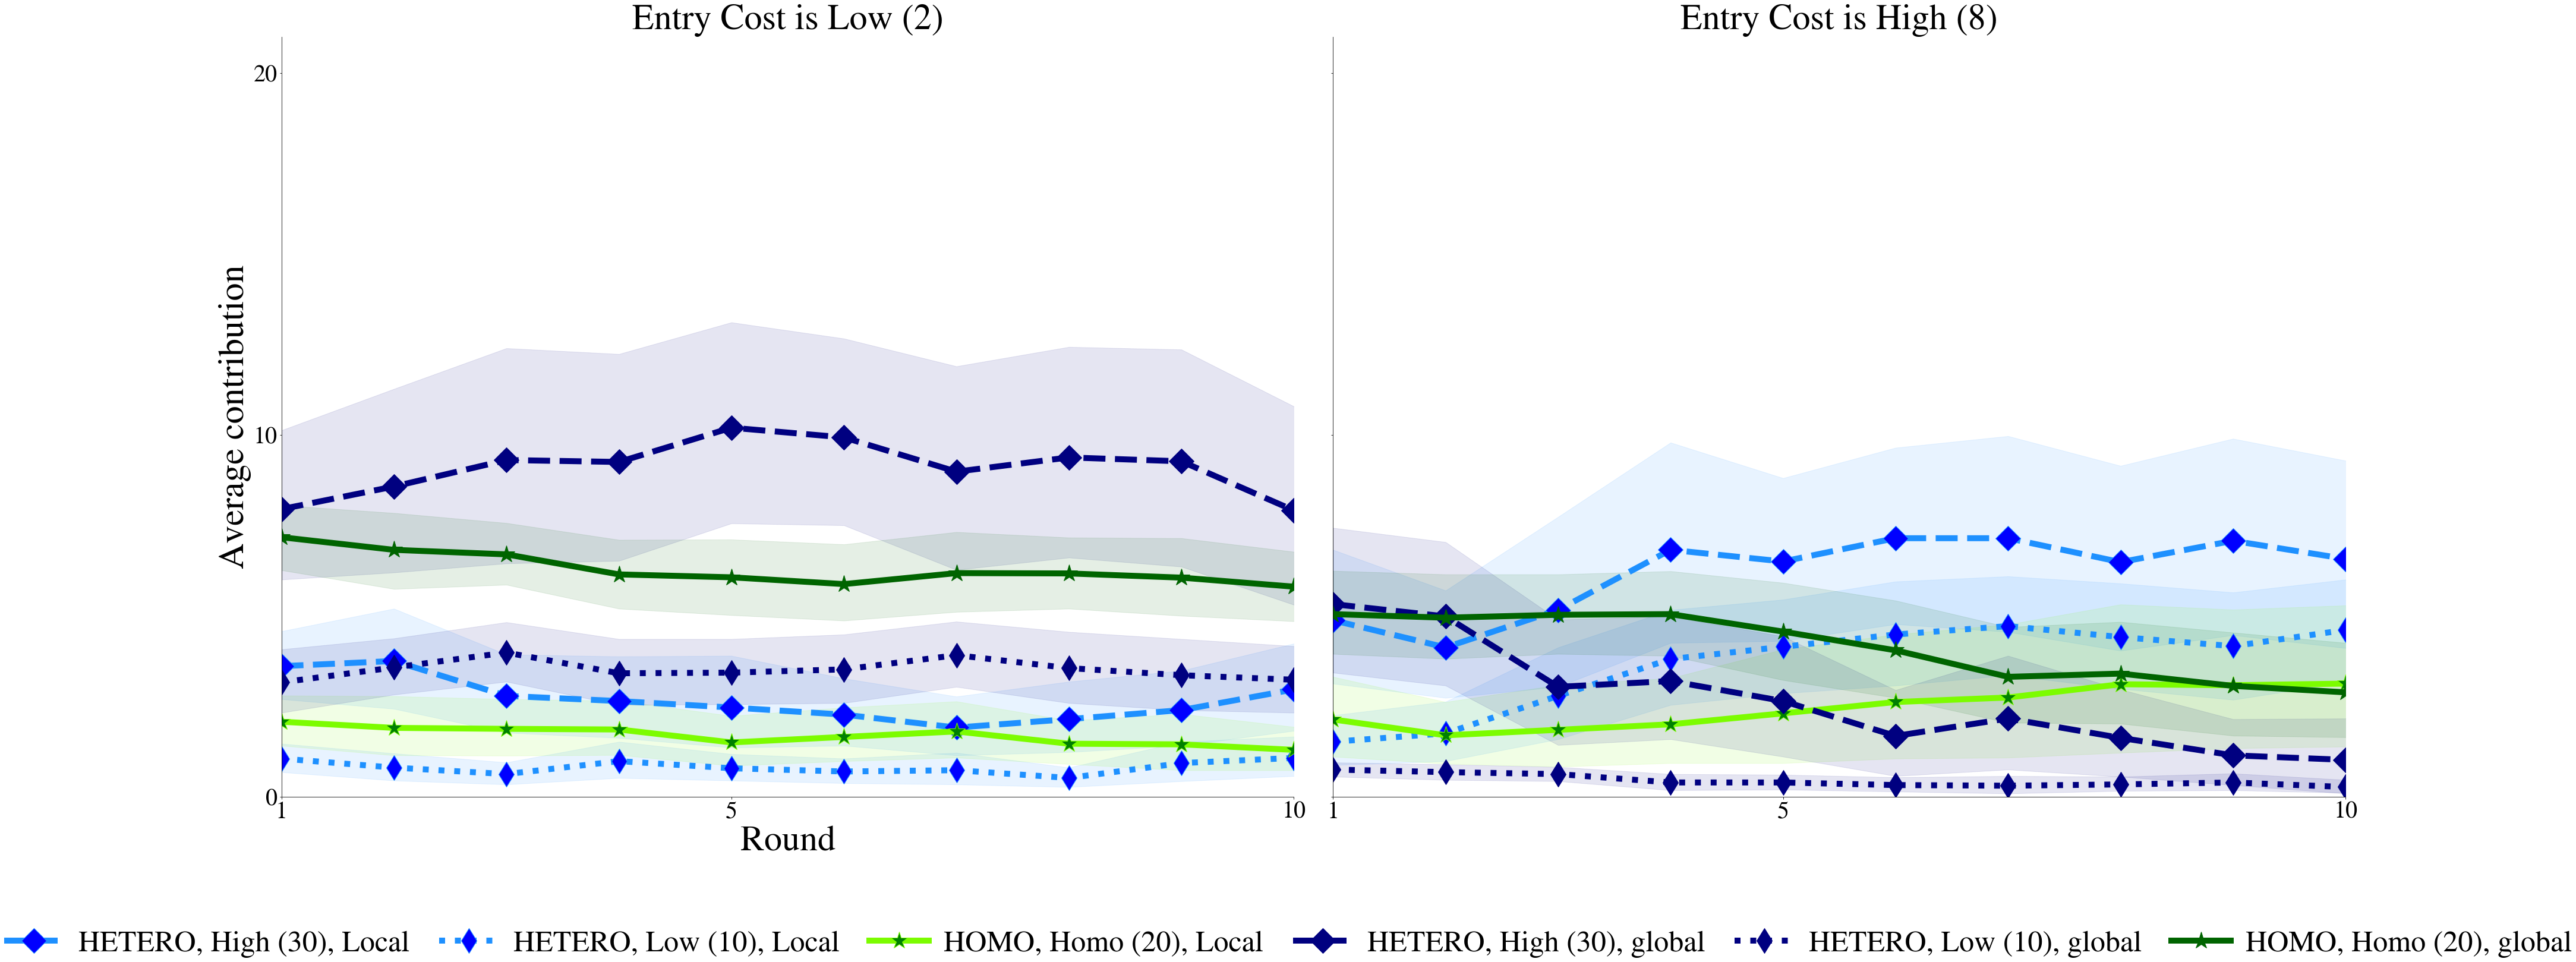

In [255]:
### This is to create the graph for all rounds
# Treatment by endowment 
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
var_of_interest =  [var_l, var_g]
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()


# Left graph for FC=2
output1 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_l,treatment_var,treatment_list_r , 20)

df1 = pd.DataFrame(output1[0,:,:], columns = treatment_list_r)
df_ci_l1 = pd.DataFrame(output1[1,:,:], columns = treatment_list_r)
df_ci_u1 = pd.DataFrame(output1[2,:,:], columns = treatment_list_r)

output2 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_g,treatment_var,treatment_list_r , 20)

df2 = pd.DataFrame(output2[0,:,:], columns = treatment_list_r)
df_ci_l2 = pd.DataFrame(output2[1,:,:], columns = treatment_list_r)
df_ci_u2 = pd.DataFrame(output2[2,:,:], columns = treatment_list_r)


# right graph for absolute value 

output1 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_l,treatment_var,treatment_list_r , 20)

dfr1 = pd.DataFrame(output1[0,:,:], columns = treatment_list_r)
df_ci_lr1 = pd.DataFrame(output1[1,:,:], columns = treatment_list_r)
df_ci_ur1 = pd.DataFrame(output1[2,:,:], columns = treatment_list_r)

output2 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_g,treatment_var,treatment_list_r , 20)

dfr2 = pd.DataFrame(output2[0,:,:], columns = treatment_list_r)
df_ci_lr2 = pd.DataFrame(output2[1,:,:], columns = treatment_list_r)
df_ci_ur2 = pd.DataFrame(output2[2,:,:], columns = treatment_list_r)



pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 21)
custom_ytick = np.arange(0,21,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['dodgerblue','dodgerblue', 'lawngreen', ]
custom_markerfacecolor = ['b', 'b','g']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u1.index, df_ci_u1[yy],df_ci_l1[yy], alpha=0.1, color=custom_markercolor[j])

treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['navy','navy', 'darkgreen', ]
custom_markerfacecolor = ['navy', 'navy','darkgreen']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u2.index, df_ci_u2[yy],df_ci_l2[yy], alpha=0.1, color=custom_markercolor[j])

    
    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average contribution', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['dodgerblue','dodgerblue', 'lawngreen', ]
custom_markerfacecolor = ['b', 'b','g']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(dfr1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur1.index, df_ci_ur1[yy],df_ci_lr1[yy], alpha=0.1, color=custom_markercolor[j])

treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['navy','navy', 'darkgreen', ]
custom_markerfacecolor = ['navy', 'navy','darkgreen']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(dfr2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur2.index, df_ci_ur2[yy],df_ci_lr2[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution-Tradeoff.pdf', bbox_inches="tight" )  


In [258]:
LocalOnly[np.isnan(LocalOnly['player.contribution_global'])]

Empty DataFrame
Columns: [T_endw_comp, player.local_community, session.code, FC, Sequence, subsession.round_number, subsession.period, player.contribution_local, player.contribution_global]
Index: []

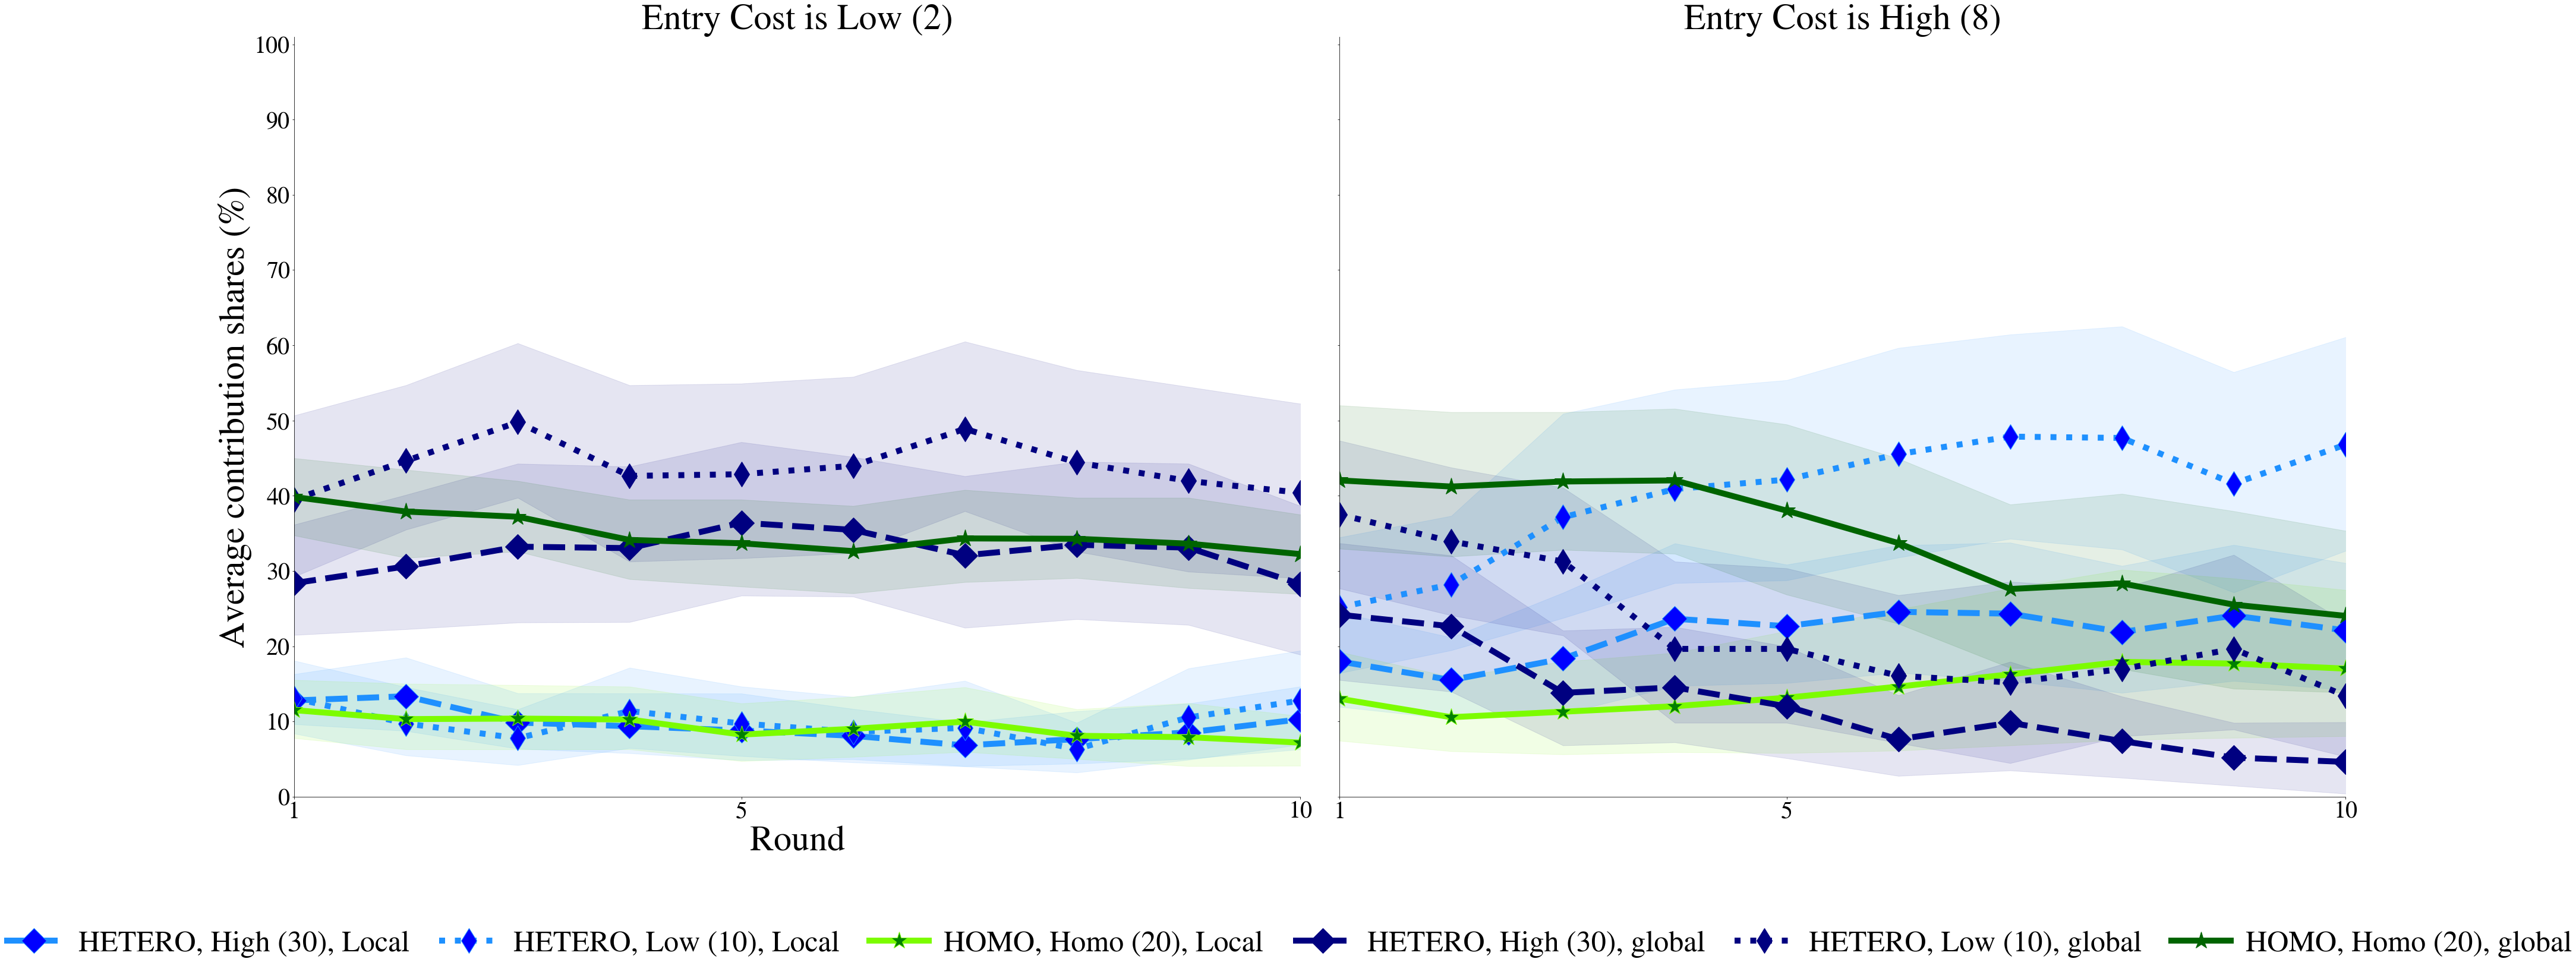

In [253]:
### This is to create the graph for all rounds
# Treatment by endowment 
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_l = 'local_share'
var_g = 'global_share'
var_of_interest =  [var_l, var_g]
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()


treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_l = 'local_share'
var_g = 'global_share'
var_of_interest =  [var_l, var_g]
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output1 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_l,treatment_var,treatment_list_r , 20)

df1 = pd.DataFrame(output1[0,:,:], columns = treatment_list_r)
df_ci_l1 = pd.DataFrame(output1[1,:,:], columns = treatment_list_r)
df_ci_u1 = pd.DataFrame(output1[2,:,:], columns = treatment_list_r)

output2 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_g,treatment_var,treatment_list_r , 20)

df2 = pd.DataFrame(output2[0,:,:], columns = treatment_list_r)
df_ci_l2 = pd.DataFrame(output2[1,:,:], columns = treatment_list_r)
df_ci_u2 = pd.DataFrame(output2[2,:,:], columns = treatment_list_r)


# right graph for absolute value 

output1 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_l,treatment_var,treatment_list_r , 20)

dfr1 = pd.DataFrame(output1[0,:,:], columns = treatment_list_r)
df_ci_lr1 = pd.DataFrame(output1[1,:,:], columns = treatment_list_r)
df_ci_ur1 = pd.DataFrame(output1[2,:,:], columns = treatment_list_r)

output2 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_g,treatment_var,treatment_list_r , 20)

dfr2 = pd.DataFrame(output2[0,:,:], columns = treatment_list_r)
df_ci_lr2 = pd.DataFrame(output2[1,:,:], columns = treatment_list_r)
df_ci_ur2 = pd.DataFrame(output2[2,:,:], columns = treatment_list_r)



pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['dodgerblue','dodgerblue', 'lawngreen', ]
custom_markerfacecolor = ['b', 'b','g']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u1.index, df_ci_u1[yy],df_ci_l1[yy], alpha=0.1, color=custom_markercolor[j])

treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['navy','navy', 'darkgreen', ]
custom_markerfacecolor = ['navy', 'navy','darkgreen']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u2.index, df_ci_u2[yy],df_ci_l2[yy], alpha=0.1, color=custom_markercolor[j])

    
    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average contribution shares (%)', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['dodgerblue','dodgerblue', 'lawngreen', ]
custom_markerfacecolor = ['b', 'b','g']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(dfr1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur1.index, df_ci_ur1[yy],df_ci_lr1[yy], alpha=0.1, color=custom_markercolor[j])

treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['navy','navy', 'darkgreen', ]
custom_markerfacecolor = ['navy', 'navy','darkgreen']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(dfr2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur2.index, df_ci_ur2[yy],df_ci_lr2[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution-Tradeoff.pdf', bbox_inches="tight" )  


### % Join the club (both)

Return: 
 [Local + Global Environment](#Local-+-Global-Environment)


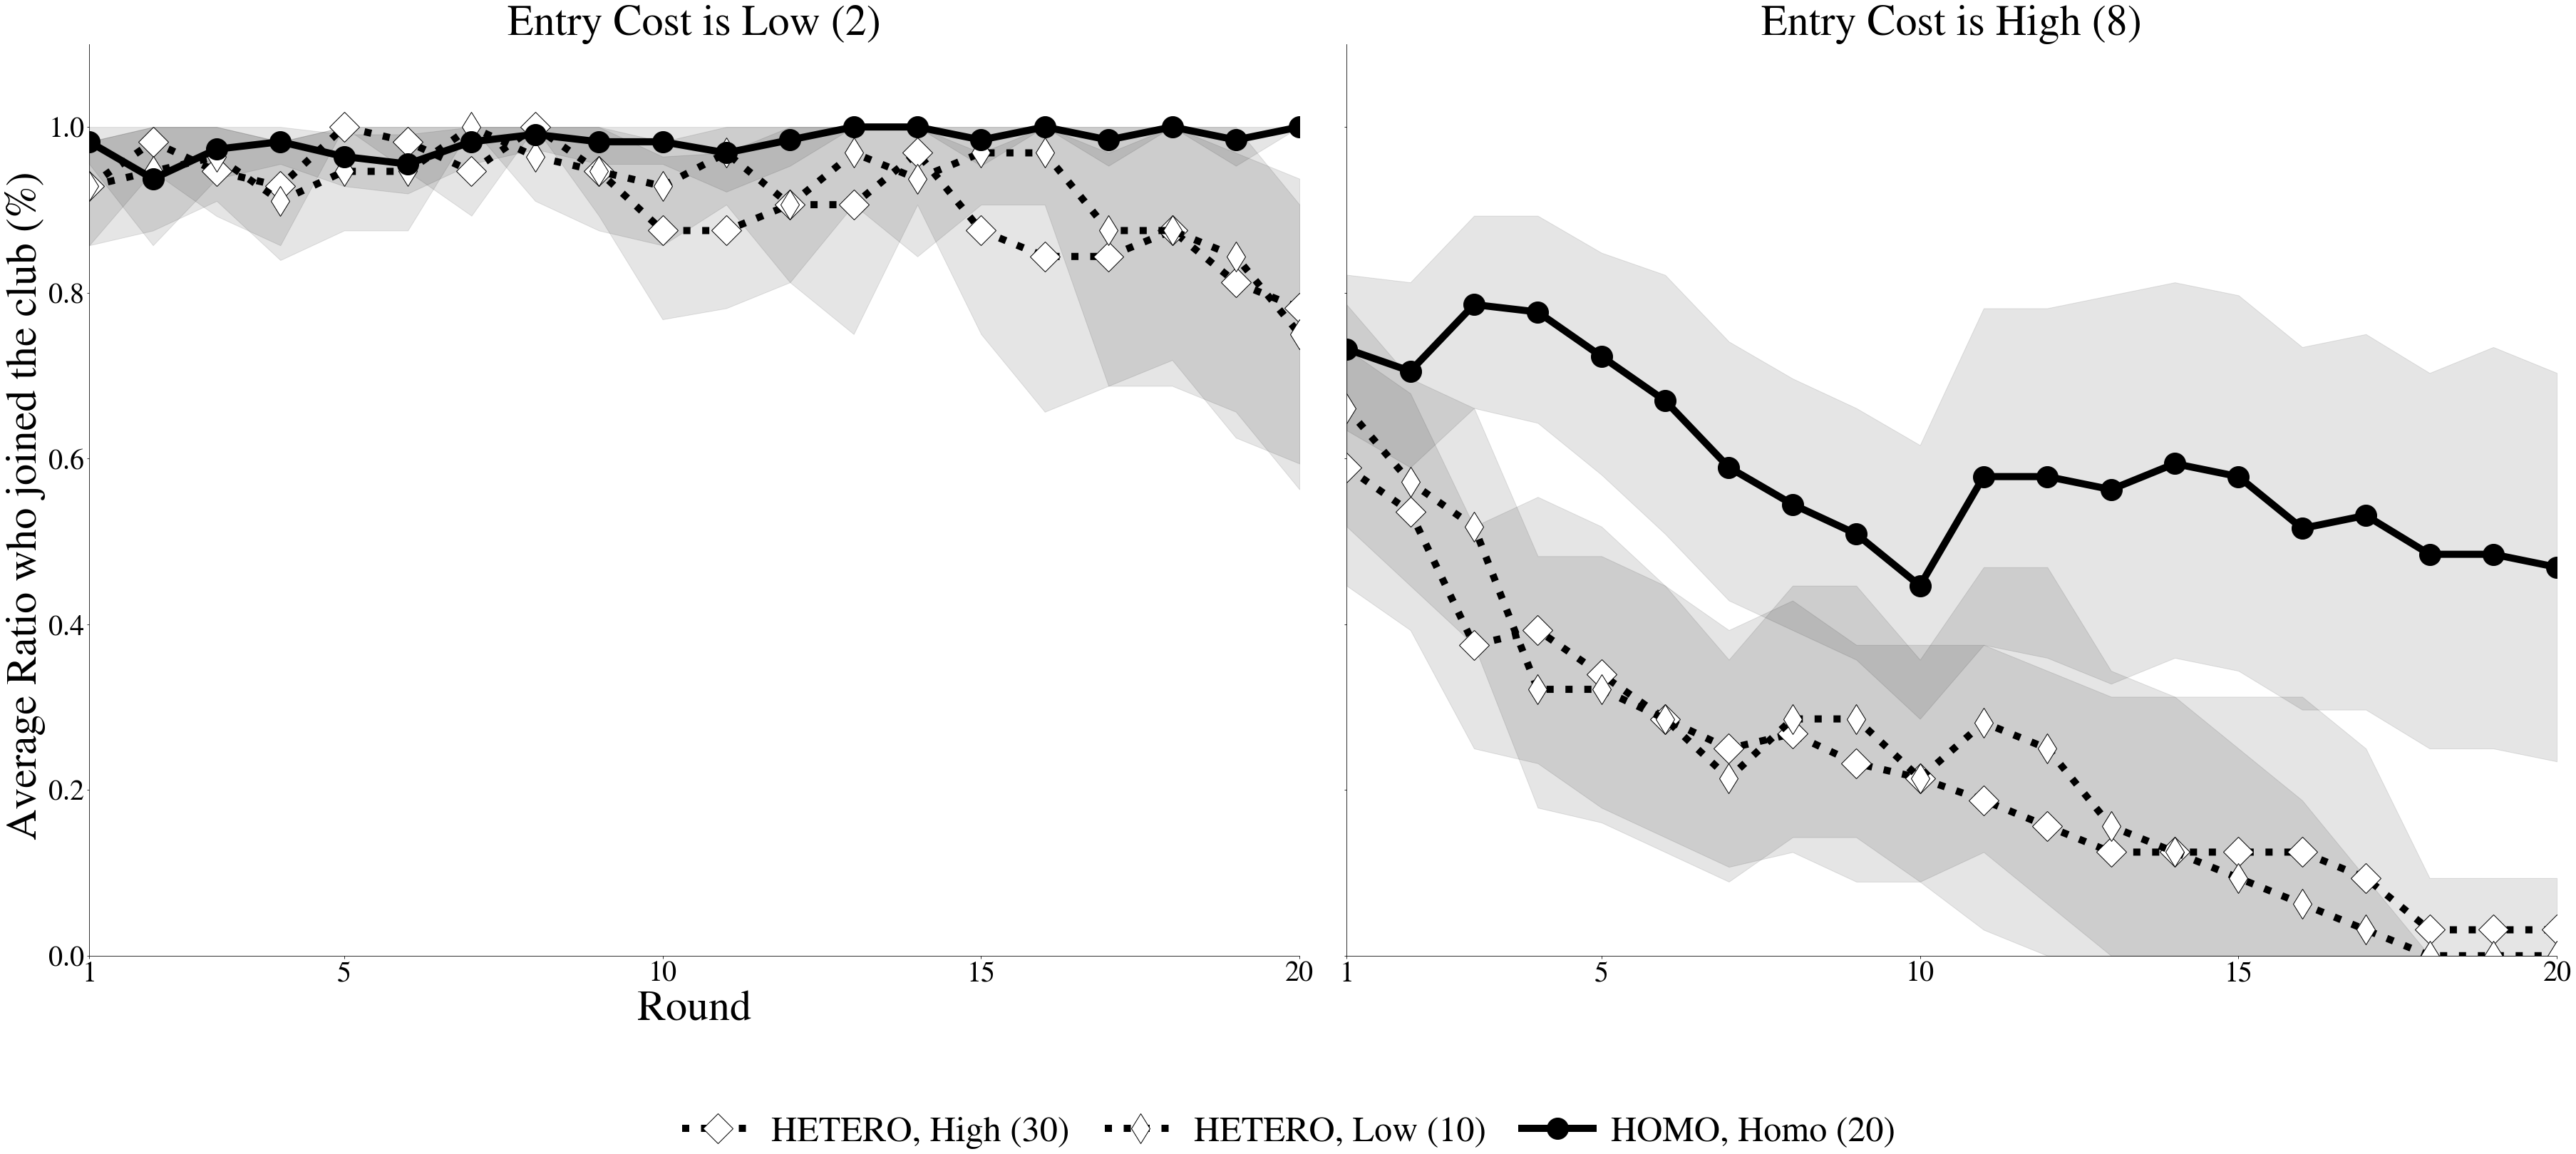

In [332]:
### This is to create the graph for all rounds
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'player.join_club'
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 19)
custom_ylim = (0, 1.1)
custom_ytick = np.arange(0,1.1,step=0.2)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average Ratio who joined the club (%) ', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Join.pdf', bbox_inches="tight" )  


In [333]:
1-np.isnan(data_OpporSim['player.contribution_global'])

0         1
1         0
2         1
3         1
4         1
         ..
102365    1
102366    1
102367    1
102368    1
102369    1
Name: player.contribution_global, Length: 64000, dtype: int32

In [334]:
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'player.join_club'
LocalOnly = data_OpporSim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

dfSim = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lSim = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_uSim = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_rSim = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lrSim = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_urSim = pd.DataFrame(output[2,:,:], columns = treatment_list_r)


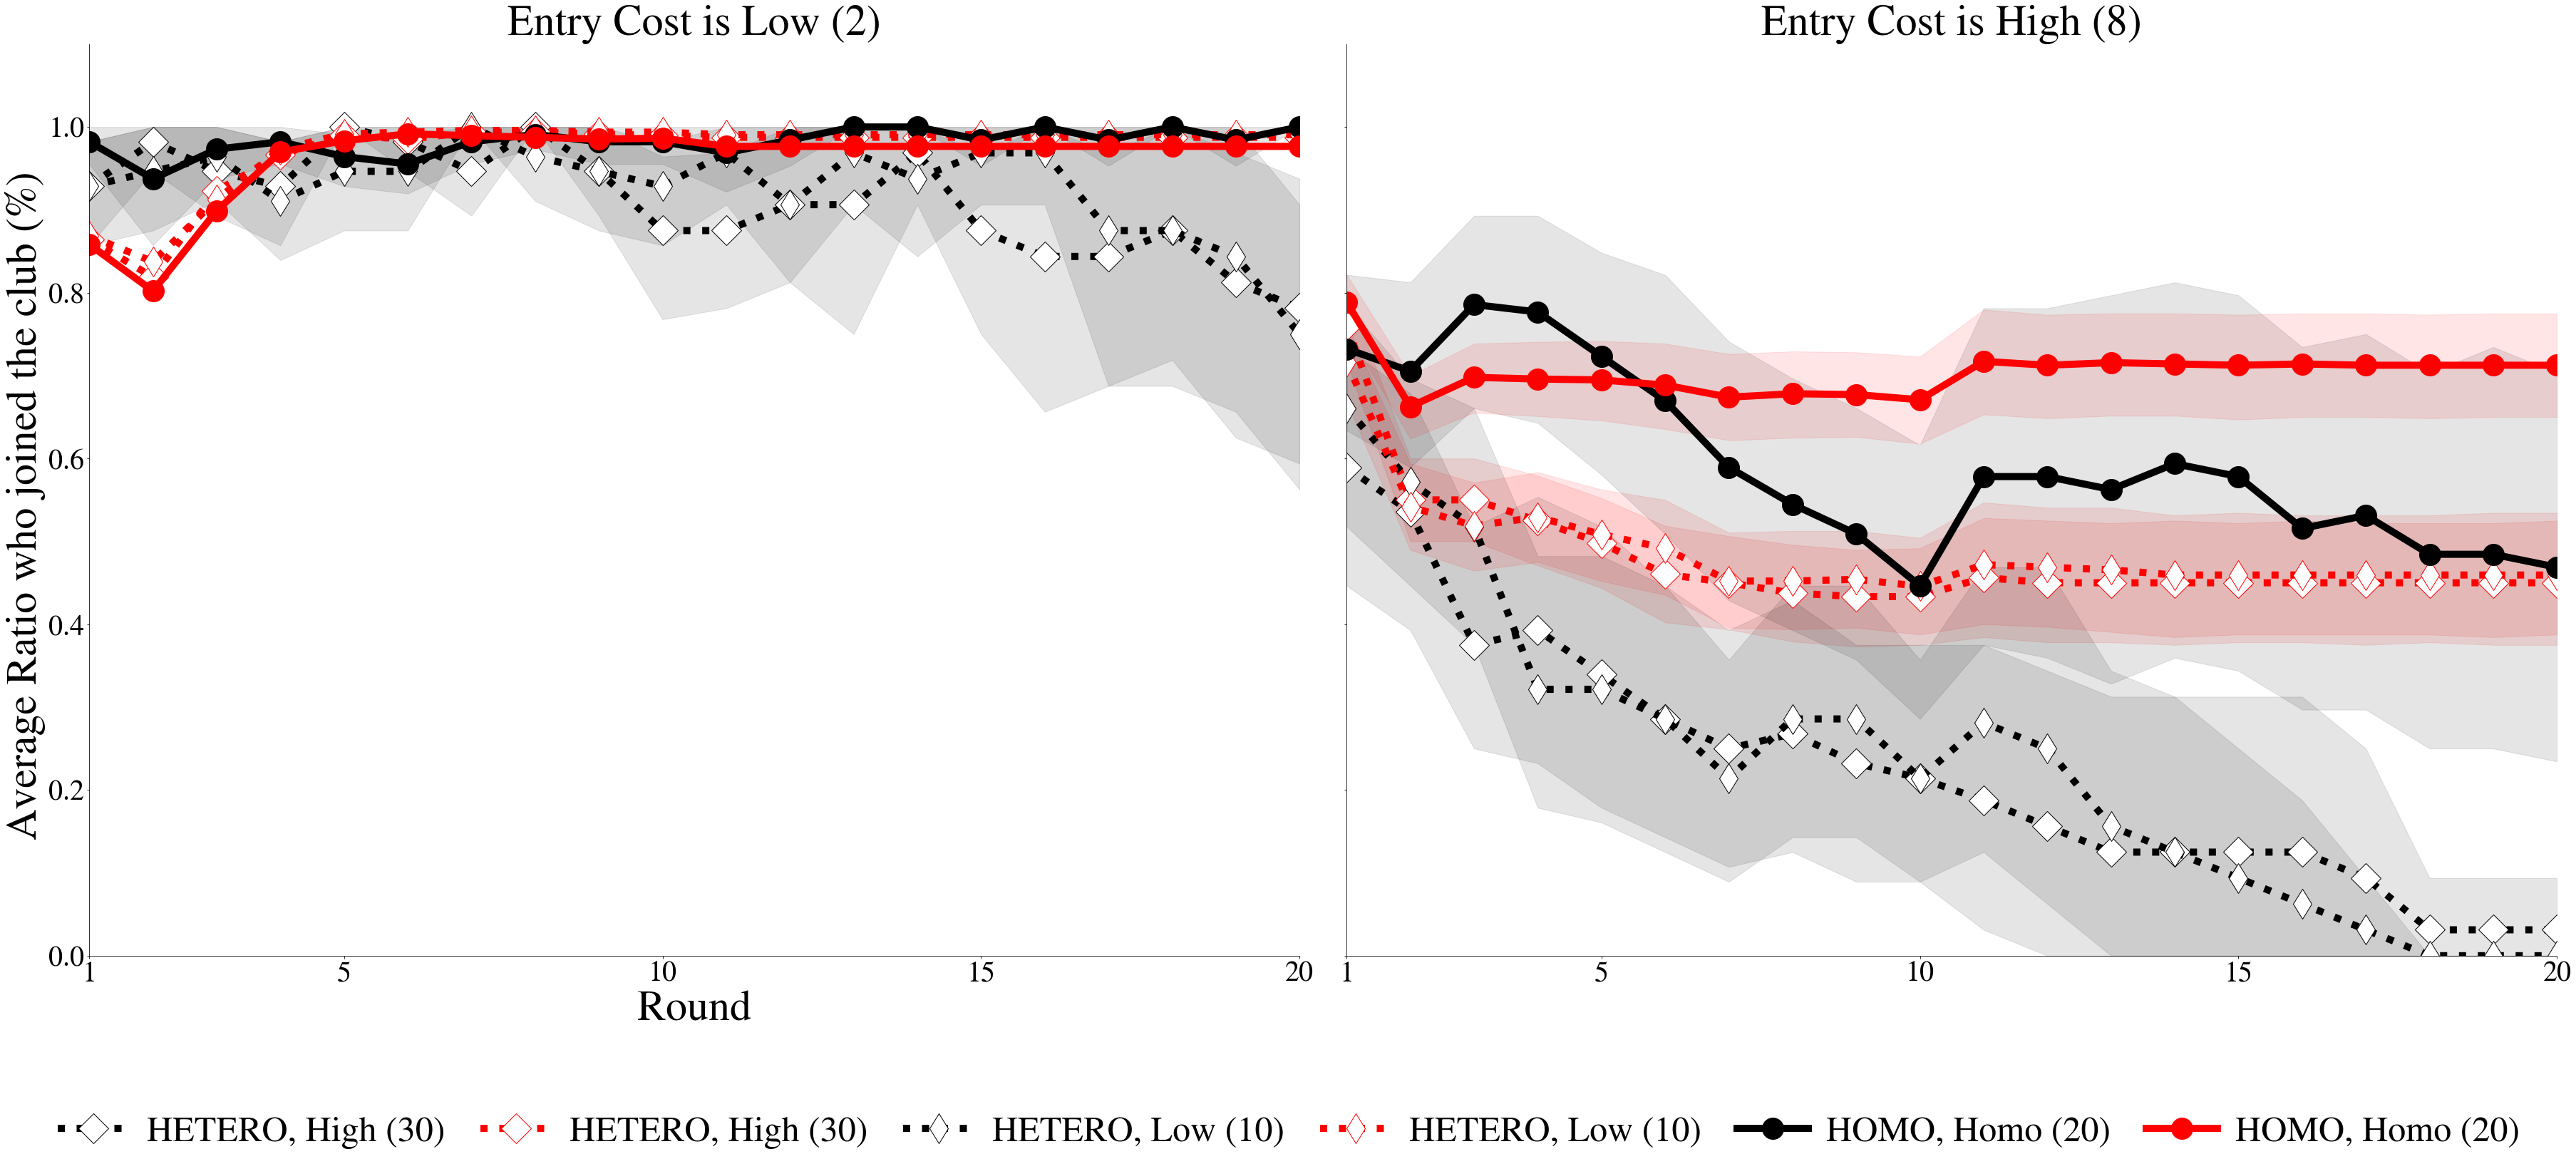

In [335]:
### This is to create the graph for all rounds
pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 19)
custom_ylim = (0, 1.1)
custom_ytick = np.arange(0,1.1,step=0.2)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_markerfacecolor_s = ['white', 'white','red']
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])
    axes[0].plot(dfSim[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=30 )
#     axes[0].fill_between(df_ci_uSim.index, df_ci_uSim[yy],df_ci_lSim[yy], alpha=0.1, color='red')

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average Ratio who joined the club (%) ', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])
    axes[1].plot(df_rSim[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_urSim.index, df_ci_urSim[yy],df_ci_lrSim[yy], alpha=0.1, color='red')

axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Join-add-simulation.pdf', bbox_inches="tight" )  


### % Welfare (both)

Return: 
 [Local + Global Environment](#Local-+-Global-Environment)

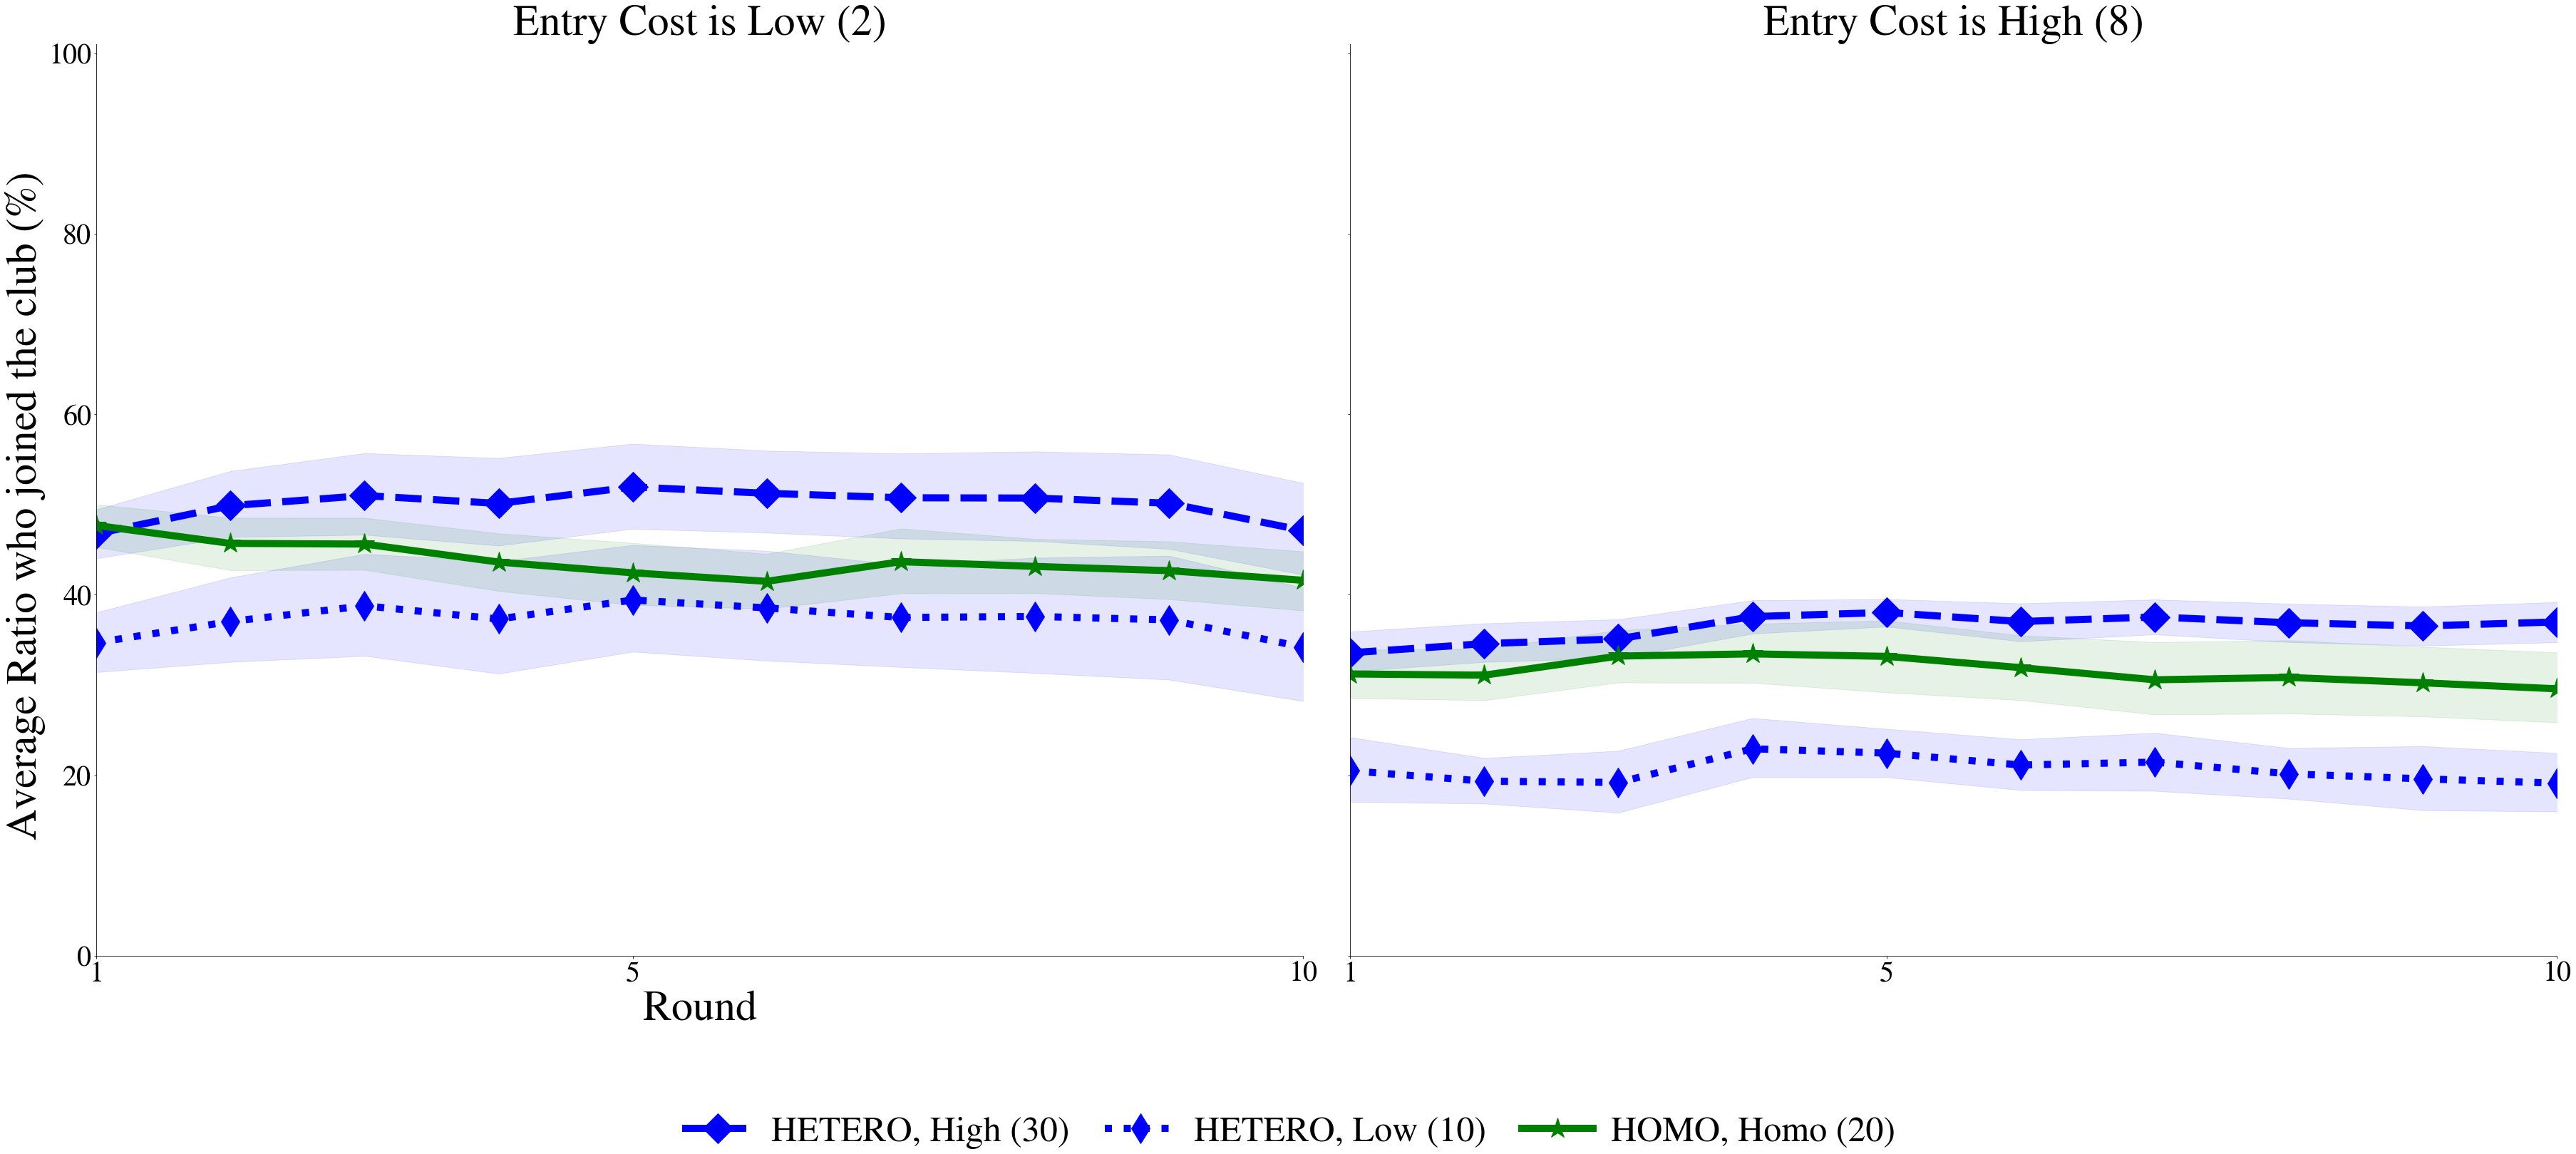

In [141]:
### This is to create the graph for all rounds
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'player.payoff'
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=20)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['b','b', 'g', ]
custom_markerfacecolor = ['b', 'b','g']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average Ratio who joined the club (%) ', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Welfare.pdf', bbox_inches="tight" )  


### Analyze Global + Local (Others)


-[Local + Global Environment](#Local-+-Global-Environment)

In [29]:
# Note: when analyzing the global club good, can't use local community as the unit, use the whole group
data_Oppor = data_Oppor_allB
# data_Oppor = data_Oppor_allB[data_Oppor_allB['Sequence']=='B1_bab'] #B1 only 
# data_Oppor = pd.concat([B1, B1_bab,B2_bab], ignore_index=True)
# data_Oppor = pd.concat([B1, B1_bab], ignore_index=True)

# For the 50 rounds in B setting, need to divide into 3 big groups
# data_Oppor['subsession.round_number_o'] = data_Oppor['subsession.round_number']
# data_Oppor['subsession.round_number'] = data_Oppor['subsession.round_number'].apply(B_round_number_transfor)


# var_of_interest = 'player.contribution_local'
# var_of_interest = 'privateAcc'
var_of_interest =  'tot_contr'

# LocalGlobal = pd.pivot_table(data_Oppor, values=var_of_interest, index=['player.local_community',  
# 'session.code', 'Treatment','FC'],
#                     columns=['subsession.round_number_o'], aggfunc=np.sum, fill_value=np.nan)

LocalGlobal = data_Oppor.groupby([ 
                      'Treatment',
        'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum()


LocalGlobal
# .groupby(['Treatment','FC']).mean()

Treatment  player.local_community  session.code  FC  Sequence  subsession.round_number  subsession.period
HETERO     0                       2fgmodqt      80  B1        1                        1                    34.0
                                                               2                        2                     7.0
                                                               3                        3                     7.0
                                                               4                        4                    18.0
                                                               5                        5                    17.0
                                                                                                             ... 
HOMO       3                       xiwi1u7k      80  B2_bab    6                        6                    52.0
                                                               7                        7       

<AxesSubplot:title={'center':'All B (Total Contribution)'}, xlabel='subsession.period'>

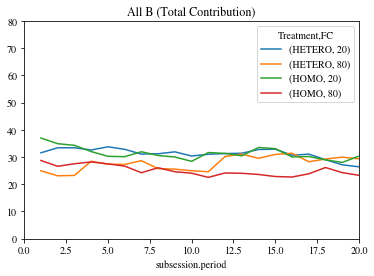

In [31]:
pd.pivot_table(LocalGlobal.reset_index(), index = 'subsession.period', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,20), ylim=(0,80), title='All B (Total Contribution)')

In [18]:
data_Oppor.columns

Index(['subsession.round_number', 'subsession.period', 'subsession.sg',
       'player.id_in_group', 'player.endowment', 'player.join_club',
       'player.local_community', 'player.id_in_local',
       'player.contribution_local', 'player.contribution_global',
       'player.total_contribution_local', 'player.individual_share_local',
       'player.payoff', 'group.id_in_subsession', 'group.FC',
       'group.total_contribution_global', 'group.individual_share_global',
       'session.code', 'Treatment', 'FC', 'participant.code', 'endowment',
       'tot_contr', 'privateAcc', 'Sequence'],
      dtype='object')

<AxesSubplot:title={'center':'All B (Total Contribution)'}, xlabel='subsession.period'>

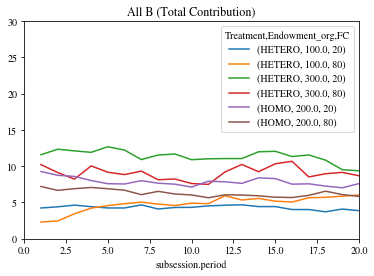

In [35]:
var_of_interest =  'tot_contr'
data_Oppor['Endowment_org'] = data_Oppor['player.endowment']  + data_Oppor['player.join_club']*data_Oppor['FC']

LocalGlobal = data_Oppor.groupby([ 
                      'Treatment',
    'player.local_community',  'session.code', 'Endowment_org',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean()


pd.pivot_table(LocalGlobal.reset_index(), index = 'subsession.period', 
               columns=['Treatment','Endowment_org', 'FC'], values=var_of_interest).plot(xlim=(0,20), 
                                                                                         ylim=(0,30), title='All B (Total Contribution)')

C:\Users\xinxi\AppData\Local\Temp/ipykernel_10556/329397773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Oppor['Endowment_org'] = data_Oppor['player.endowment']  + data_Oppor['player.join_club']*data_Oppor['FC']


<AxesSubplot:title={'center':'All B (Global Contribution)'}, xlabel='subsession.period'>

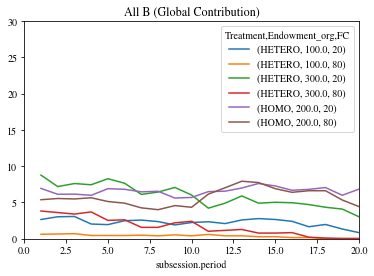

In [42]:
var_of_interest =  'player.contribution_global'
data_Oppor['Endowment_org'] = data_Oppor['player.endowment']  + data_Oppor['player.join_club']*data_Oppor['FC']

LocalGlobal = data_Oppor.groupby([ 
                      'Treatment',
    'player.local_community',  'session.code', 'Endowment_org',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean()


pd.pivot_table(LocalGlobal.reset_index(), index = 'subsession.period', 
               columns=['Treatment','Endowment_org', 'FC'], values=var_of_interest).plot(xlim=(0,20), ylim=(0,30), title='All B (Global Contribution)')

C:\Users\xinxi\AppData\Local\Temp/ipykernel_10556/3472798795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Oppor['Endowment_org'] = data_Oppor['player.endowment']  + data_Oppor['player.join_club']*data_Oppor['FC']


<AxesSubplot:title={'center':'All B (Local Contribution)'}, xlabel='subsession.period'>

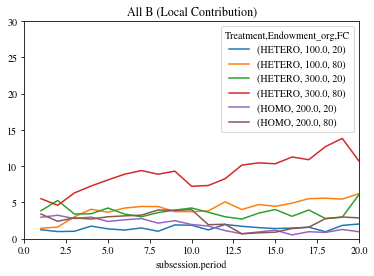

In [41]:
var_of_interest =  'player.contribution_local'
data_Oppor['Endowment_org'] = data_Oppor['player.endowment']  + data_Oppor['player.join_club']*data_Oppor['FC']

LocalGlobal = data_Oppor.groupby([ 
                      'Treatment',
    'player.local_community',  'session.code', 'Endowment_org',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean()


pd.pivot_table(LocalGlobal.reset_index(), index = 'subsession.period', 
               columns=['Treatment','Endowment_org', 'FC'], values=var_of_interest).plot(xlim=(0,20), ylim=(0,30), title='All B (Local Contribution)')

C:\Users\xinxi\AppData\Local\Temp/ipykernel_10556/1728974425.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Oppor['Endowment_org'] = data_Oppor['player.endowment']  + data_Oppor['player.join_club']*data_Oppor['FC']


<AxesSubplot:title={'center':'All B(% join club)'}, xlabel='subsession.period'>

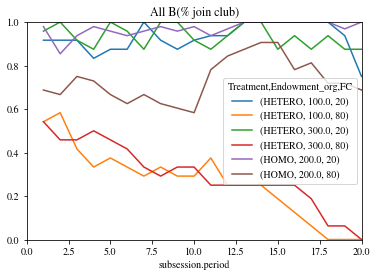

In [40]:
var_of_interest =  'player.join_club'
# data_Oppor = data_Oppor_allB
data_Oppor = data_Oppor_allB[data_Oppor_allB['Sequence']=='B1_bab']

data_Oppor['Endowment_org'] = data_Oppor['player.endowment']  + data_Oppor['player.join_club']*data_Oppor['FC']

LocalGlobal = data_Oppor.groupby([ 
                      'Treatment',
    'player.local_community',  'session.code', 'Endowment_org',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean()


pd.pivot_table(LocalGlobal.reset_index(), index = 'subsession.period', 
               columns=['Treatment','Endowment_org', 'FC'], values=var_of_interest).plot(xlim=(0,20), ylim=(0,1), title='All B(% join club)')

# Both Environments

-[Welfare comparison](#Welfare-comparison)

-[Experimental Data for caliberation](#Experimental-Data-for-caliberation)


-[All apps(others)](#All-apps(others))

-[Start Data Analysis](#Start-Data-Analysis)

## Experimental Data for caliberation

Return 
-[Both Environments](#Both-Environments)

In [68]:
v1 = data_noOppor.groupby(['Treatment', 'FC'])['player.contribution_local' ].mean()
print(v1)
v1_m = v1.to_numpy()
print(v1_m)

              player.contribution_local  tot_contr
Treatment FC                                      
HETERO    20                    9.28125    9.28125
          80                    7.46500    7.46500
HOMO      20                    7.61750    7.61750
          80                    9.54625    9.54625
[[9.28125 9.28125]
 [7.465   7.465  ]
 [7.6175  7.6175 ]
 [9.54625 9.54625]]


C:\Users\xinxi\AppData\Local\Temp/ipykernel_19604/2784433456.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  v1 = data_noOppor.groupby(['Treatment', 'FC'])['player.contribution_local',  'tot_contr' ].mean()


In [70]:
data_Oppor

subsession.round_number  subsession.period  subsession.sg  \
0                           1                  1              1   
1                           1                  1              1   
2                           1                  1              1   
3                           1                  1              1   
4                           1                  1              1   
...                       ...                ...            ...   
7035                       10                 10              1   
7036                       10                 10              1   
7037                       10                 10              1   
7038                       10                 10              1   
7039                       10                 10              1   

      player.id_in_group  player.endowment  player.join_club  \
0                      1             280.0                 1   
1                      5             280.0                 1   
2                      1             280.0                 1   
3                      5             280.0                 1   
4                      2             300.0                 0   
...                  ...               ...               ...   
7035                   7             180.0                 1   
7036                   4             180.0                 1   
7037                   8             180.0                 1   
7038                   4             180.0                 1   
7039                   8             180.0                 1   

      player.local_community  player.id_in_local  player.contribution_local  \
0                          1                   0                        8.0   
1                          2                   0                        5.0   
2                          3                   0                        7.0   
3                          0                   0                        4.0   
4                          1                   1                       10.0   
...                      ...                 ...                        ...   
7035                       0                   2                        0.0   
7036                       1                   3                        0.0   
7037                       2                   3                        1.0   
7038                       3                   3                        2.0   
7039                       0                   3                        0.0   

      player.contribution_global  ...  participant.code  endowment  tot_contr  \
0                            8.0  ...          zcomruh3       28.0       16.0   
1                            5.0  ...          2hmxb93l       28.0       10.0   
2                            7.0  ...          mtdu10l3       28.0       14.0   
3                            4.0  ...          ycczqkta       28.0        8.0   
4                            0.0  ...          8qc6v1us       30.0       10.0   
...                          ...  ...               ...        ...        ...   
7035                         3.0  ...          vou6qpqb       18.0        3.0   
7036                         0.0  ...          x1c0dxrl       18.0        0.0   
7037                         5.0  ...          191iospu       18.0        6.0   
7038                         9.0  ...          hzmz02dz       18.0       11.0   
7039                        18.0  ...          gkyo3o8s       18.0       18.0   

      privateAcc  Sequence  End_level  tot_cont_share        T_endw_comp  \
0           12.0        B1  High (30)       57.142857  HETERO, High (30)   
1           18.0        B1  High (30)       35.714286  HETERO, High (30)   
2           14.0        B1  High (30)       50.000000  HETERO, High (30)   
3           20.0        B1  High (30)       28.571429  HETERO, High (30)   
4           20.0        B1  High (30)       33.333333  HETERO, High (30)   
...          ...       ...        ...             ... 

In [72]:
v2 = data_Oppor.groupby(['Treatment', 'FC'])['player.join_club','player.contribution_local',  'player.contribution_global' ].mean()
print(v2)
v2_m = v2.to_numpy()
print(v2_m)

              player.join_club  player.contribution_local  \
Treatment FC                                                
HETERO    20          0.927841                   1.781818   
          80          0.264773                   5.715341   
HOMO      20          0.979545                   1.451136   
          80          0.607955                   2.176136   

              player.contribution_global  
Treatment FC                              
HETERO    20                    6.098864  
          80                    1.082386  
HOMO      20                    6.423864  
          80                    4.177841  
[[0.92784091 1.78181818 6.09886364]
 [0.26477273 5.71534091 1.08238636]
 [0.97954545 1.45113636 6.42386364]
 [0.60795455 2.17613636 4.17784091]]


C:\Users\xinxi\AppData\Local\Temp/ipykernel_19604/3308860188.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  v2 = data_Oppor.groupby(['Treatment', 'FC'])['player.join_club','player.contribution_local',  'player.contribution_global' ].mean()


## Welfare comparison

Return 
-[Both Environments](#Both-Environments)


In [336]:
# treatment_list = ['HETERO','HOMO']
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'player.payoff'
R_max = 20

LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC',
      'Sequence','subsession.round_number', 'subsession.period'
            ])[var_of_interest].mean().reset_index()



LocalGlobal =data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

output_all = np.empty((11, 3))
output_all[:]=np.nan

for i,t in enumerate(treatment_list_r): 
    pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&(LocalOnly['subsession.period']<=R_max), var_of_interest]

    output_all[i, 0]=pop_a.mean()
    output_all[i, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)
    
for i,t in enumerate(treatment_list_r): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==20), var_of_interest]

    output_all[i+4, 0]=pop_a.mean()
    output_all[i+4, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list_r): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==80), var_of_interest]

    output_all[i+8, 0]=pop_a.mean()
    output_all[i+8, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   


In [337]:
# treatment_list = ['HETERO','HOMO']
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'player.payoff'
R_max = 20

LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC',
      'Sequence','subsession.round_number', 'subsession.period'
            ])[var_of_interest].mean().reset_index()



LocalGlobal =data_Oppor[data_Oppor['player.join_club']==1].groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

output_join = np.empty((11, 3))
output_join[:]=np.nan

for i,t in enumerate(treatment_list_r): 
    pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&(LocalOnly['subsession.period']<=R_max), var_of_interest]

    output_join[i, 0]=pop_a.mean()
    output_join[i, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)
    
for i,t in enumerate(treatment_list_r): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==20), var_of_interest]

    output_join[i+4, 0]=pop_a.mean()
    output_join[i+4, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list_r): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==80), var_of_interest]

    output_join[i+8, 0]=pop_a.mean()
    output_join[i+8, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   


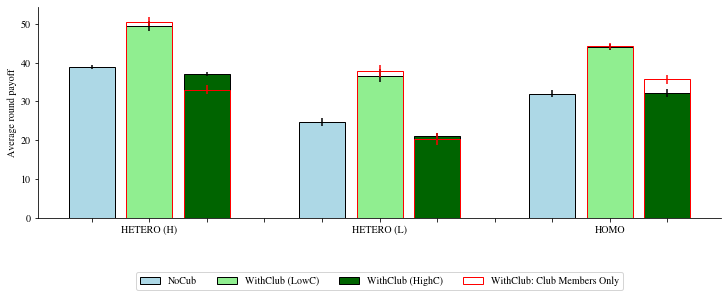

In [338]:
# Draw a graph to show the average player payoff without vs with opportunity 
# Re-group to compare the same type of subjects

# labels=  ['HETERO (H)', 'HETERO (L)','HOMO', '',
#           'HETERO (H)', 'HETERO (L)','HOMO', '',
#          'HETERO (H)', 'HETERO (L)','HOMO']

# labels = ['No Club Opportunity','Entry Cost = 2', 'Entry Cost = 8', '',
#          'No Club Opportunity','Entry Cost = 2', 'Entry Cost = 8', '',
#          'No Club Opportunity','Entry Cost = 2', 'Entry Cost = 8']

labels = ['NoCub','WithClub (LowC)', 'WithClub (HighC)','WithClub: Club Members Only'  ]

labels2 =  ['', 'HETERO (H)','', '',
          '', 'HETERO (L)','', '',
         '', 'HOMO','']

colors = [ 'lightblue','lightgreen','darkgreen']
hatchs = ['', '.', 'xx']

x = np.arange(len(labels2))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))


for i in np.arange(3): 
#     toDraw = output
    axes.bar([i,i+4,i+8], output_all[[i*4,i*4+1,i*4+2],0], 
             yerr=[output_all[[i*4,i*4+1,i*4+2],0]-output_all[[i*4,i*4+1,i*4+2],1], output_all[[i*4,i*4+1,i*4+2],2]-output_all[[i*4,i*4+1,i*4+2],0]],
#              hatch=hatchs[i],
             label="All: " + labels[i], 
#             fill=False,
             color = colors[i],
             edgecolor = 'black'
            )    
for i in np.arange(1,3): 
    axes.bar([i,i+4,i+8], output_join[[i*4,i*4+1,i*4+2],0], 
         yerr=[output_join[[i*4,i*4+1,i*4+2],0]-output_join[[i*4,i*4+1,i*4+2],1], output_join[[i*4,i*4+1,i*4+2],2]-output_join[[i*4,i*4+1,i*4+2],0]],
             ecolor = 'red',
#              hatch=hatchs[i],
         label= labels[3], 
            fill=False,
#          color = colors,
         edgecolor = 'red'
        )    

axes.set_ylabel('Average round payoff')
axes.set_ylabel('Average round payoff')
axes.set_xticks(x)
axes.set_xticklabels(labels2)
legend = axes.legend(labels, bbox_to_anchor=(.5,-.3), loc="center" , ncol=5)
# handles = legend.legendHandles
# for i, handle in enumerate(handles):
#     handle.set_edgecolor("black") 
#     handle.set_facecolor('white')
#     handle.set_hatch(hatchs[i])
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
# axes[1].spines['top'].set_visible(False)
# axes[1].spines['right'].set_visible(False)
# axes[0].set_title('All Subjects')
# axes[1].set_title('Subjects who joined the club only')
# fig.savefig('..\\Output\\01-group-data-Dec-2022-Payoff.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

In [339]:
# Adding simulation results 

# treatment_list = ['HETERO','HOMO']
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'player.payoff'
R_max = 20

LocalOnly = data_noOppor_sim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num','FC',
      'Sequence','subsession.round_number', 'subsession.period'
            ])[var_of_interest].mean().reset_index()


LocalGlobal =data_OpporSim.groupby([ 
                     treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Only for mean value now 
# 3 levels of treatment_list_r , Noclub + 11 fixed cost
output_allSim = np.empty((3, 12))
output_allSim[:]=np.nan

for i,t in enumerate(treatment_list_r): 
    pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&(LocalOnly['subsession.period']<=R_max), var_of_interest]
    output_allSim[i, 0]=pop_a.mean()
    
    for j in range(11):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==j*10), var_of_interest]
        output_allSim[i,j+1]=pop_a.mean()
       


    
LocalGlobal =data_OpporSim[data_OpporSim['player.join_club']==1].groupby([ 
                     treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

output_joinSim = np.empty((3,12))
output_joinSim[:]=np.nan

for i,t in enumerate(treatment_list_r): 
    pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&(LocalOnly['subsession.period']<=R_max), var_of_interest]
    output_joinSim[i, 0]=pop_a.mean()
    
    for j in range(11):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==j*10), var_of_interest]
        output_joinSim[i,j+1]=pop_a.mean()


KeyError: 'Column not found: player.payoff'

In [315]:
output_allSim

array([[38.8484733 , 56.79355   , 55.55375   , 52.8666    , 53.89135   ,
        46.722725  , 45.355625  , 40.85155   , 39.2721    , 37.394175  ,
        35.450675  , 34.683725  ],
       [28.33910114, 46.817875  , 46.3118    , 43.383425  , 44.785     ,
        35.780525  , 34.815925  , 29.46735   , 28.27625   , 26.8911    ,
        24.514875  , 22.557825  ],
       [33.80181648, 56.3469375 , 52.4088    , 50.3792    , 44.318375  ,
        43.1914125 , 40.121525  , 36.12395   , 33.0804    , 32.0876375 ,
        27.770025  , 28.835225  ]])

In [316]:
output_joinSim

array([[38.8484733 , 57.20405337, 56.02253663, 53.24850088, 54.36741601,
        47.12832399, 45.70467005, 41.37457815, 39.9931014 , 36.27688272,
        33.77204918, 31.09376694],
       [28.33910114, 47.25864151, 46.86714646, 43.84366339, 45.26603535,
        36.31179017, 35.42808729, 30.63536018, 29.83523948, 28.16385093,
        25.70552174, 23.22244404],
       [33.80181648, 56.75313465, 52.77918959, 50.69231924, 44.67286501,
        43.59625722, 40.42175739, 36.4876524 , 33.19032537, 32.5429977 ,
        26.17387327, 26.26026923]])

In [313]:
LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==9*10), var_of_interest]

76625     37.100000
76626     33.666667
76627     25.866667
76628     22.666667
76629     24.950000
            ...    
116981    12.400000
116982    13.000000
116983    12.400000
116984    12.600000
116985    13.600000
Name: player.payoff, Length: 2988, dtype: float64

Text(0, 0.5, 'Average round payoff')

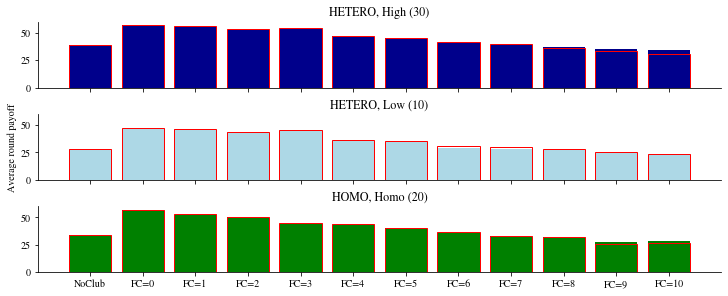

In [314]:
# Draw a graph to show the average player payoff without vs with opportunity 
# Group by environment

# labels=  ['HETERO (H)', 'HETERO (L)','HOMO', '',
#           'HETERO (H)', 'HETERO (L)','HOMO', '',
#          'HETERO (H)', 'HETERO (L)','HOMO']
labels = ['NoClub'] + ['FC='+str(i) for i in range(11)]

labels2 =  ['', 'No Club Opportunity','', '',
          '', 'Entry Cost = 2','', '',
         '', 'Entry Cost = 8','']

colors = [ 'darkblue','lightblue','green']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=3, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

# Hetero (H) 
for i,t in enumerate(treatment_list_r): 
#     toDraw = output
    axes[i].bar(np.arange(12), output_allSim[i,:], 
             label=t, 
#              yerr=[output[[i,i+4,i+8],0]-output[[i,i+4,i+8],1], output[[i,i+4,i+8],2]-output[[i,i+4,i+8],0]],
             color=colors[i]
            )
    axes[i].bar(np.arange(12), output_joinSim[i,:], 
             label=t, fill=False, 
#              yerr=[output[[i,i+4,i+8],0]-output[[i,i+4,i+8],1], output[[i,i+4,i+8],2]-output[[i,i+4,i+8],0]],
             edgecolor='red'
            )
    axes[i].set_title(t)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(labels)
#     axes[i].legend(['HETERO (H)', 'HETERO (L)','HOMO'])
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
axes[1].set_ylabel('Average round payoff')
# fig.savefig('..\\Output\\01-group-data-Dec-2022-Payoff.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

In [175]:
AllData = data_Oppor.append(data_noOppor)
AllData['RoundNumber'] = AllData['subsession.round_number']
AllData.loc[AllData['Sequence']=='B1', 'RoundNumber'] += 10
AllData.loc[AllData['Sequence']=='A2', 'RoundNumber'] += 60
AllData.loc[AllData['Sequence']=='A2_bab', 'RoundNumber'] += 50
AllData.loc[AllData['Sequence']=='B2_bab', 'RoundNumber'] += 70
AllData['SeqOrder']  = 'ABA'
AllData.loc[( AllData['Sequence'].str.contains('bab')), 'SeqOrder'] = 'BAB'
AllData['RoundNumber_comparable'] = AllData['RoundNumber']
AllData.loc[AllData['SeqOrder']=='BAB','RoundNumber_comparable'] += 10
AllData['tot_contr_shares'] = AllData['tot_contr']/AllData['endowment']

### All apps(others)

To see the trend over time

Return 
-[Both Environments](#Both-Environments)


In [12]:
AllData = data_Oppor_allB.append(data_noOppor_AllA)
AllData['RoundNumber'] = AllData['subsession.round_number']
AllData.loc[AllData['Sequence']=='B1', 'RoundNumber'] += 10
AllData.loc[AllData['Sequence']=='A2', 'RoundNumber'] += 60
AllData.loc[AllData['Sequence']=='A2_bab', 'RoundNumber'] += 50
AllData.loc[AllData['Sequence']=='B2_bab', 'RoundNumber'] += 70
AllData['SeqOrder']  = 'ABA'
AllData.loc[( AllData['Sequence'].str.contains('bab')), 'SeqOrder'] = 'BAB'
AllData['RoundNumber_comparable'] = AllData['RoundNumber']
AllData.loc[AllData['SeqOrder']=='BAB','RoundNumber_comparable'] += 10
AllData['tot_contr_shares'] = AllData['tot_contr']/AllData['endowment']

In [13]:
# AllData.columns
# AllData['tot_contr_shares'].unique()
AllData['RoundNumber_comparable'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90], dtype=int64)

<AxesSubplot:title={'center':'Data (ABA): Total Contribution'}, xlabel='RoundNumber'>

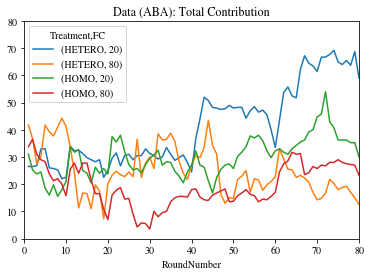

In [14]:
# average should start from local group
var_of_interest =  'tot_contr'

AllDataGroupAverage = AllData.groupby([ 
                      'Treatment', 'session.code','FC','RoundNumber','SeqOrder',
        'player.local_community',  
                      ])[var_of_interest].sum().reset_index()

ABA = AllDataGroupAverage[AllDataGroupAverage['SeqOrder']=='ABA']
# ABA
pd.pivot_table(ABA, index = 'RoundNumber', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,80), ylim=(0,80), title='Data (ABA): Total Contribution')

<AxesSubplot:title={'center':'Data (BAB): Total Contribution'}, xlabel='RoundNumber'>

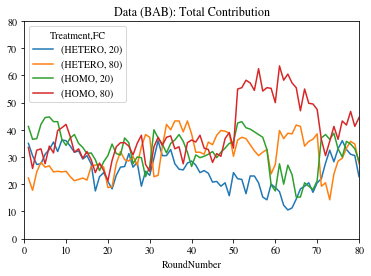

In [15]:
BAB = AllDataGroupAverage[AllDataGroupAverage['SeqOrder']=='BAB']
pd.pivot_table(BAB, index = 'RoundNumber', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,80), ylim=(0,80), title='Data (BAB): Total Contribution')

<AxesSubplot:title={'center':'Data: Total Contribution'}, xlabel='RoundNumber_comparable'>

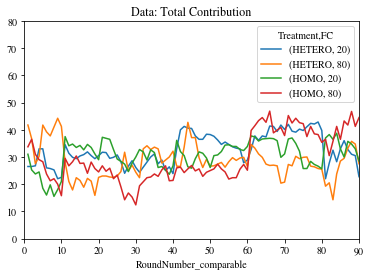

In [16]:
# average should start from local group
var_of_interest =  'tot_contr'

AllDataGroupAverage = AllData.groupby([ 
                      'Treatment', 'session.code','FC','RoundNumber_comparable','SeqOrder',
        'player.local_community',  
                      ])[var_of_interest].sum().reset_index()


pd.pivot_table(AllDataGroupAverage, index = 'RoundNumber_comparable', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,90), ylim=(0,80), title='Data: Total Contribution')

<AxesSubplot:title={'center':'Data: Total Contribution Shares'}, xlabel='RoundNumber_comparable'>

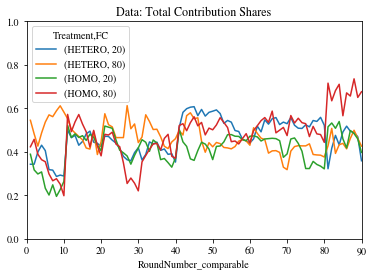

In [17]:
# average should start from local group
var_of_interest =  'tot_contr_shares'

AllDataGroupAverage = AllData.groupby([ 
                      'Treatment', 'session.code','FC','RoundNumber_comparable','SeqOrder',
        'player.local_community',  
                      ])[var_of_interest].mean().reset_index()


pd.pivot_table(AllDataGroupAverage, index = 'RoundNumber_comparable', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,90), ylim=(0,1), title='Data: Total Contribution Shares')

<AxesSubplot:title={'center':'Data: Average Payoff'}, xlabel='RoundNumber_comparable'>

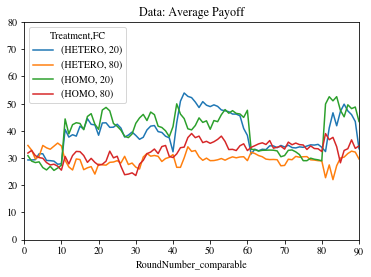

In [101]:
# average should start from local group
var_of_interest =  'player.payoff'

AllDataGroupAverage = AllData.groupby([ 
                      'Treatment', 'session.code','FC','RoundNumber_comparable','SeqOrder',
        'player.local_community',  
                      ])[var_of_interest].mean().reset_index()


pd.pivot_table(AllDataGroupAverage, index = 'RoundNumber_comparable', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,90), ylim=(0,80), title='Data: Average Payoff')

<AxesSubplot:title={'center':'Data: Local Contribution'}, xlabel='RoundNumber_comparable'>

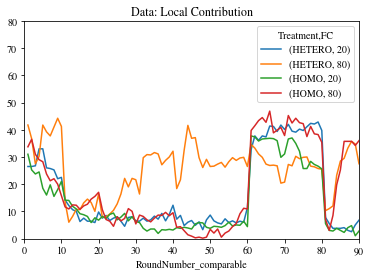

In [102]:
# average should start from local group
var_of_interest =  'player.contribution_local'

AllDataGroupAverage = AllData.groupby([ 
                      'Treatment', 'session.code','FC','RoundNumber_comparable','SeqOrder',
        'player.local_community',  
                      ])[var_of_interest].sum().reset_index()


pd.pivot_table(AllDataGroupAverage, index = 'RoundNumber_comparable', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,90), ylim=(0,80), title='Data: Local Contribution')

<AxesSubplot:title={'center':'Data: Global Contribution'}, xlabel='RoundNumber_comparable'>

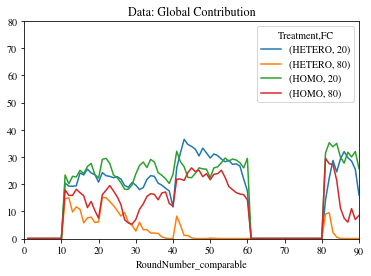

In [103]:
# average should start from local group
var_of_interest =  'player.contribution_global'

AllDataGroupAverage = AllData.groupby([ 
                      'Treatment', 'session.code','FC','RoundNumber_comparable','SeqOrder',
        'player.local_community',  
                      ])[var_of_interest].sum().reset_index()


pd.pivot_table(AllDataGroupAverage, index = 'RoundNumber_comparable', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,90), ylim=(0,80), title='Data: Global Contribution')

<AxesSubplot:title={'center':'Data: % join'}, xlabel='RoundNumber_comparable'>

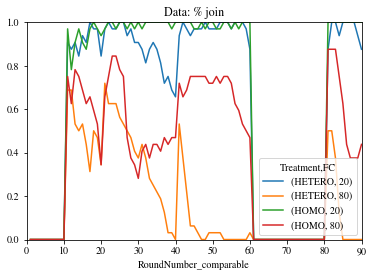

In [108]:
# average should start from local group
var_of_interest =  'player.join_club'

AllDataGroupAverage = AllData.groupby([ 
                      'Treatment', 'session.code','FC','RoundNumber_comparable','SeqOrder',
        'player.local_community',  
                      ])[var_of_interest].mean().reset_index()


pd.pivot_table(AllDataGroupAverage, index = 'RoundNumber_comparable', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,90), ylim=(0,1), title='Data: % join')

In [13]:
var_of_interest = 'player.contribution_global'
# var_of_interest = 'privateAcc'

LocalGlobal = pd.pivot_table(data_Oppor, values=var_of_interest, index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=np.nan)

LocalGlobal.groupby(['Treatment','FC']).mean()  # when the FC is small and hetero, the contribution is relatively stable;
    # when the FC is small and homo, the contribution decrease;
    # when FC is large, both hetero and homo decreases (but hetero move to local? homo doesn't? )
    
    # Need to calculate confidence interval!! group as individual unit, may have very large confidence interval!!!)
    # If interval is too big, need to use the simulation result to help make predictions!!!!

subsession.round_number     1      2      3      4      5      6      7   \
Treatment FC                                                               
HETERO    20             21.50  19.75  16.00  14.25  20.50  22.00  26.00   
          80             12.25   9.50  10.25  10.25   8.75   8.00   4.25   
HOMO      20             23.75  14.00  17.50  24.75  31.00  32.25  32.00   
          80             15.25  11.00  11.50  11.75   8.75  10.00   8.00   

subsession.round_number     8      9      10  ...     41     42     43     44  \
Treatment FC                                  ...                               
HETERO    20             22.75  27.00  23.50  ...  17.25  16.25  16.75  15.00   
          80              6.25   9.75  11.75  ...   0.25   0.00   0.00   0.00   
HOMO      20             33.75  24.00  23.75  ...  26.00  25.50  27.50  27.25   
          80             11.75  10.25   8.25  ...  31.50  31.00  32.25  28.75   

subsession.round_number     45     46     47    48     49     50  
Treatment FC                                                      
HETERO    20             14.00  13.50  11.25  13.0   7.50   6.25  
          80              0.00   0.00   0.00   0.0   0.00   0.00  
HOMO      20             26.75  27.25  28.00  30.5  29.25  31.00  
          80             22.50  22.50  19.25  18.5  16.75  11.50  

[4 rows x 50 columns]

In [ ]:
# Group Level data
Group_NoOpp = data_noOppor.groupby(['player.local_community', 'Sequence',
                                    'session.code', 'Treatment','FC',
                                    'subsession.round_number', 
                                    'subsession.period'])['player.contribution_local',
                                                          'endowment', 'tot_contr',
                                                          'privateAcc',
                                                         'player.payoff',
                                                          'player.join_club',
                                                        ].sum().reset_index()


Group_Opp = data_Oppor.groupby(['player.local_community', 'Sequence',
                                    'session.code', 'Treatment', 'FC',
                                    'subsession.round_number','subsession.round_number_o',
                                    'subsession.period'])['player.contribution_local',
                                                          'player.contribution_global',
                                                          'endowment', 'tot_contr',
                                                          'privateAcc',
                                                         'player.payoff',
                                                         'player.join_club'].sum().reset_index()


# data_Oppor.
# Group_NoOpp


In [ ]:
Group_Opp.groupby(['Treatment','FC'])['player.payoff'].agg(['mean']).reset_index()

In [ ]:
Group_NoOpp.groupby(['Treatment','FC'])['player.payoff'].agg(['mean']).reset_index()

In [ ]:
# Draw a graph to show the total contribution without vs with opportunity 

Contribution_Combined = Group_Opp.groupby(['Treatment','FC'])['player.contribution_local','tot_contr',
                                                                    'player.contribution_global',
                                                                   'player.payoff', 'player.join_club'].mean().reset_index()
# Contribution_Combined =pd.pivot_table(Group_Opp, values=['player.contribution_local','player.contribution_global'], 
#               index=['Treatment'],columns=['group.FC'] ).reset_index()
temp = Group_NoOpp.groupby(['Treatment','FC'])['player.contribution_local','tot_contr', 'player.payoff', 'player.join_club'].mean().reset_index()
Contribution_Combined = Contribution_Combined.merge(temp, on=['Treatment','FC'])

Contribution_Combined_std = Group_Opp.groupby(['Treatment','FC'])['player.contribution_local',
                                                                    'player.contribution_global','tot_contr',].std().reset_index()
temp = Group_NoOpp.groupby(['Treatment','FC'])['player.contribution_local', 'tot_contr'].std().reset_index()
Contribution_Combined_std = Contribution_Combined_std.merge(temp, on=['Treatment','FC'])

# Try s.e.
Contribution_Combined_std['player.contribution_local_x']=Contribution_Combined_std['player.contribution_local_x']/np.sqrt(80)
Contribution_Combined_std['player.contribution_local_y']=Contribution_Combined_std['player.contribution_local_y']/np.sqrt(20)
Contribution_Combined_std['player.contribution_global']=Contribution_Combined_std['player.contribution_global']/np.sqrt(80)

In [ ]:
Contribution_Combined_CI9 = copy.deepcopy(Contribution_Combined)

for t in Contribution_Combined.Treatment.unique():
    for fc in Contribution_Combined['FC'].unique():
        data = Group_NoOpp[(Group_NoOpp['Treatment']==t) & (Group_NoOpp['FC']==fc)]
        x = bootstrap_ci(np.array(data['player.contribution_local']), 10000, np.mean)[0] 

        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t)  & (Group_NoOpp['FC']==fc), 
                                      'player.contribution_local_y'] -= x

        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t)  & (Group_NoOpp['FC']==fc), 
                                      'player.payoff_y'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 
        
        data = Group_Opp[(Group_Opp['Treatment']==t) & (Group_Opp['FC']==fc)]
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                      (Contribution_Combined_CI9['FC']==fc),
                                      'player.contribution_local_x'] -= bootstrap_ci(np.array(data['player.contribution_local']), 10000, np.mean)[0]
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) 
                                      & (Contribution_Combined_CI9['FC']==fc), 
                                      'player.contribution_global'] -= bootstrap_ci(np.array(data['player.contribution_global']), 10000, np.mean)[0]
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                      (Contribution_Combined_CI9['FC']==fc), 
                                  'player.payoff_x'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                      (Contribution_Combined_CI9['FC']==fc), 
                                   'player.join_club_x'] -= bootstrap_ci(np.array(data['player.join_club']), 10000, np.mean)[0] 
    
    

In [ ]:
labels=  ['HETERO', 'HOMO', '','HETERO (L)',  'HETERO (H)','HOMO (L)', 'HOMO (H)']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

axes.bar(Contribution_Combined.Treatment, Contribution_Combined['player.contribution_local_y'], 
         label="Group Account", 
         yerr=Contribution_Combined_CI9['player.contribution_local_y'], 
#          yerr=Contribution_Combined_std['player.contribution_local_y'],
         color='lightblue')

axes.bar(Contribution_Combined.index+3, Contribution_Combined['player.contribution_local_x'],
#          label="Group Account",
         yerr=Contribution_Combined_CI9['player.contribution_local_x'],
#          yerr=Contribution_Combined_std['player.contribution_local_x'],
         color='lightblue')
# Stacked bars
axes.bar(Contribution_Combined.index+3,
         Contribution_Combined['player.contribution_global'], label="Group Account #2", 
         bottom=Contribution_Combined['player.contribution_local_x'],
#         yerr=Contribution_Combined_std['player.contribution_global'],
         yerr=Contribution_Combined_CI9['player.contribution_global'],
         color='lightgreen')

axes.set_xticks(labels)
axes.legend()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-Contribution.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

In [ ]:
# Draw a graph to show the total contribution without vs with opportunity 
def ContributionGraph(Group_Opp, Group_NoOpp):
    Contribution_Combined = Group_Opp.groupby(['Treatment','FC'])['player.contribution_local','tot_contr',
                                                                        'player.contribution_global',
                                                                       'player.payoff', 'player.join_club'].mean().reset_index()
    # Contribution_Combined =pd.pivot_table(Group_Opp, values=['player.contribution_local','player.contribution_global'], 
    #               index=['Treatment'],columns=['group.FC'] ).reset_index()
    temp = Group_NoOpp.groupby(['Treatment','FC'])['player.contribution_local','tot_contr', 'player.payoff', 'player.join_club'].mean().reset_index()
    Contribution_Combined = Contribution_Combined.merge(temp, on=['Treatment','FC'])

    Contribution_Combined_std = Group_Opp.groupby(['Treatment','FC'])['player.contribution_local',
                                                                        'player.contribution_global','tot_contr',].std().reset_index()
    temp = Group_NoOpp.groupby(['Treatment','FC'])['player.contribution_local', 'tot_contr'].std().reset_index()
    Contribution_Combined_std = Contribution_Combined_std.merge(temp, on=['Treatment','FC'])

    # Try s.e.
    Contribution_Combined_std['player.contribution_local_x']=Contribution_Combined_std['player.contribution_local_x']/np.sqrt(80)
    Contribution_Combined_std['player.contribution_local_y']=Contribution_Combined_std['player.contribution_local_y']/np.sqrt(20)
    Contribution_Combined_std['player.contribution_global']=Contribution_Combined_std['player.contribution_global']/np.sqrt(80)
    Contribution_Combined_CI9 = copy.deepcopy(Contribution_Combined)

    for t in Contribution_Combined.Treatment.unique():
        for fc in Contribution_Combined['FC'].unique():
            data = Group_NoOpp[(Group_NoOpp['Treatment']==t) & (Group_NoOpp['FC']==fc)]
            x = bootstrap_ci(np.array(data['player.contribution_local']), 10000, np.mean)[0] 

            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t)  & (Group_NoOpp['FC']==fc), 
                                          'player.contribution_local_y'] -= x

            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t)  & (Group_NoOpp['FC']==fc), 
                                          'player.payoff_y'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 

            data = Group_Opp[(Group_Opp['Treatment']==t) & (Group_Opp['FC']==fc)]
            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                          (Contribution_Combined_CI9['FC']==fc),
                                          'player.contribution_local_x'] -= bootstrap_ci(np.array(data['player.contribution_local']), 10000, np.mean)[0]
            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) 
                                          & (Contribution_Combined_CI9['FC']==fc), 
                                          'player.contribution_global'] -= bootstrap_ci(np.array(data['player.contribution_global']), 10000, np.mean)[0]
            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                          (Contribution_Combined_CI9['FC']==fc), 
                                      'player.payoff_x'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 
            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                          (Contribution_Combined_CI9['FC']==fc), 
                                       'player.join_club_x'] -= bootstrap_ci(np.array(data['player.join_club']), 10000, np.mean)[0] 

    labels=  ['HETERO', 'HOMO', '','HETERO (L)',  'HETERO (H)','HOMO (L)', 'HOMO (H)']
    x = np.arange(len(labels))
    fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

    axes.bar(Contribution_Combined.Treatment, Contribution_Combined['player.contribution_local_y'], 
             label="Group Account", 
             yerr=Contribution_Combined_CI9['player.contribution_local_y'], 
    #          yerr=Contribution_Combined_std['player.contribution_local_y'],
             color='lightblue')

    axes.bar(Contribution_Combined.index+3, Contribution_Combined['player.contribution_local_x'],
    #          label="Group Account",
             yerr=Contribution_Combined_CI9['player.contribution_local_x'],
    #          yerr=Contribution_Combined_std['player.contribution_local_x'],
             color='lightblue')
    # Stacked bars
    axes.bar(Contribution_Combined.index+3,
             Contribution_Combined['player.contribution_global'], label="Group Account #2", 
             bottom=Contribution_Combined['player.contribution_local_x'],
    #         yerr=Contribution_Combined_std['player.contribution_global'],
             yerr=Contribution_Combined_CI9['player.contribution_global'],
             color='lightgreen')

    axes.set_xticks(labels)
    axes.legend()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    # fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-Contribution.pdf'  , bbox_inches="tight")  
    # fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

In [ ]:
ContributionGraph(Group_Opp[Group_Opp['subsession.period']<=10], Group_NoOpp[Group_NoOpp['subsession.period']<=10] )

In [ ]:
# Draw a graph to show the average player payoff without vs with opportunity 


labels=  ['HETERO (L)', 'HETERO (H)','HOMO (L)', 'HOMO (H)', '', 'HETERO (L)',  'HETERO (H)','HOMO (L)', 'HOMO (H)']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

axes.bar(Contribution_Combined.index, Contribution_Combined['player.payoff_y'], 
         label="Average Group Payoff (No Global)", 
#          yerr=Contribution_Combined_CI9['player.payoff_y'], 
         yerr=Contribution_Combined_std['player.contribution_local_y'],
#          color='lightblue'
        )

axes.bar(Contribution_Combined.index+5, Contribution_Combined['player.payoff_x'],
         label="Average Group Payoff (With Global)", 
#          yerr=Contribution_Combined_CI9['player.payoff_x'],
         yerr=Contribution_Combined_std['player.contribution_local_x'],
#          color='lightblue'
        )

# axes.axhline(y=80, linestyle='dashed')

axes.set_xticks(x)
axes.set_xticklabels(labels)
axes.legend()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-Payoff.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

In [ ]:
# Draw a graph to show the number of players who join the club with opportunity 


labels=  ['HETERO (L)',  'HETERO (H)','HOMO (L)', 'HOMO (H)']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

axes.bar(list(Contribution_Combined.index), Contribution_Combined['player.join_club_x'],
#          label="Group Account",
         yerr=Contribution_Combined_CI9['player.join_club_x'],
#          yerr=Contribution_Combined_std['player.contribution_local_x'],
         color='lightgreen')

axes.set_xticks(ticks=list(Contribution_Combined.index))
axes.set_xticklabels(labels)
axes.legend()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-NumJoinClubInEachGroup.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

## Group Level data, inequality

In [ ]:
# Group Level data
Group_NoOpp = data_noOppor.groupby(['player.local_community', 
                                    'session.code', 'Treatment','FC',
                                    'subsession.round_number',
                                    'subsession.period'])['endowment',
                                                         'player.payoff',
                                                        ].std().reset_index()


Group_Opp = data_Oppor.groupby(['player.local_community', 
                                    'session.code', 'Treatment', 'FC',
                                    'subsession.round_number', 'subsession.round_number_o',
                                    'subsession.period'])['endowment','player.payoff'].std().reset_index()


Contribution_Combined = Group_Opp.groupby(['Treatment','FC'])['endowment','player.payoff'].mean().reset_index()
# Contribution_Combined =pd.pivot_table(Group_Opp, values=['player.contribution_local','player.contribution_global'], 
#               index=['Treatment'],columns=['group.FC'] ).reset_index()
temp = Group_NoOpp.groupby(['Treatment','FC'])['endowment','player.payoff'].mean().reset_index()
Contribution_Combined = Contribution_Combined.merge(temp, on=['Treatment','FC'])

# Calculate confidence intervals
Contribution_Combined_CI9 = copy.deepcopy(Contribution_Combined)

for t in Contribution_Combined.Treatment.unique():
    for fc in Contribution_Combined['FC'].unique():
        data = Group_NoOpp[(Group_NoOpp['Treatment']==t) & (Group_Opp['FC']==fc)]

        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) & (Group_Opp['FC']==fc), 
                                      'endowment_y'] -= bootstrap_ci(np.array(data['endowment']), 10000, np.mean)[0] 

        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) & (Group_Opp['FC']==fc), 
                                      'player.payoff_y'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 


    
        
     
        
        data = Group_Opp[(Group_Opp['Treatment']==t) & (Group_Opp['FC']==fc)]
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                      (Contribution_Combined_CI9['FC']==fc),
                                      'endowment_x'] -= bootstrap_ci(np.array(data['endowment']), 10000, np.mean)[0]
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                      (Contribution_Combined_CI9['FC']==fc), 
                                  'player.payoff_x'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 
    
    


# Draw a graph to show the average player payoff without vs with opportunity 


labels=  ['HETERO', 'HOMO', '','HETERO (L)',  'HETERO (H)','HOMO (L)', 'HOMO (H)']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

axes.scatter(Contribution_Combined.Treatment, Contribution_Combined['endowment_y'], 
         label="Within-Group Endowment Standard Deviation", 
         color='red',zorder=1)
axes.bar(Contribution_Combined.Treatment, Contribution_Combined['player.payoff_y'], 
         label="Within-Group Payoff Standard Deviation", 
         yerr=Contribution_Combined_CI9['player.payoff_y'], 
         color='lightblue',zorder=-1)


axes.scatter(Contribution_Combined.index+3, Contribution_Combined['endowment_x'], 
         color='red',zorder=1)
axes.bar(Contribution_Combined.index+3, Contribution_Combined['player.payoff_x'],
#          label="Group Account",
         yerr=Contribution_Combined_CI9['player.payoff_x'],
         color='lightblue',zorder=-1)

# axes.axhline(y=80, linestyle='dashed')
axes.set_ylim(-0.1,15)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_xticks(labels)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=2, frameon=False)
fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-PayoffVariance.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

In [ ]:
# Private Account 
var_of_interest = 'privateAcc'

LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, 
                           index=['player.local_community', 'Sequence', 'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0).groupby(['Treatment','FC']).mean()
data_Oppor_g = data_Oppor.groupby(['player.local_community',  'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()
# LocalOnly = group.groupby(['Treatment']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()
axes.plot(LocalOnly.T['HOMO'][20], label='HOMO No Opportunity (L)', c='blue', marker='o')
axes.plot(LocalOnly.T['HETERO'][20], label='HETERO No Opportunity (L)', c='orange', marker='o')
axes.plot(LocalOnly.T['HOMO'][80], label='HOMO No Opportunity (H)', c='blue')
axes.plot(LocalOnly.T['HETERO'][80], label='HETERO No Opportunity (H)', c='orange')
axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')


axes.set_title(str(var_of_interest))
axes.set_xlim(1,10)
axes.set_ylim(0,80)
axes.legend()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=3, frameon=False)

fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-PrivateAccTimeTrend.pdf'  , bbox_inches="tight")  

In [ ]:
# Total Contribution
var_of_interest = 'tot_contr'

LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, 
                           index=['player.local_community', 'Sequence', 'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0).groupby(['Treatment','FC']).mean()
data_Oppor_g = data_Oppor.groupby(['player.local_community', 'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()
# LocalOnly = group.groupby(['Treatment']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()
axes.plot(LocalOnly.T['HOMO'][20], label='HOMO No Opportunity (L)', c='blue', marker='o')
axes.plot(LocalOnly.T['HETERO'][20], label='HETERO No Opportunity (L)', c='orange', marker='o')
axes.plot(LocalOnly.T['HOMO'][80], label='HOMO No Opportunity (H)', c='blue')
axes.plot(LocalOnly.T['HETERO'][80], label='HETERO No Opportunity (H)', c='orange')
axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')

axes.set_title(str(var_of_interest))
# axes.set_xlim(1,10)
axes.set_ylim(0,80)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=3, frameon=False)

# fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-LocalContributionTimeTrend.pdf'  , bbox_inches="tight")  

In [ ]:
# Local Group Account 
var_of_interest = 'player.contribution_local'

LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, 
                           index=['player.local_community', 'Sequence', 'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0).groupby(['Treatment','FC']).mean()
data_Oppor_g = data_Oppor.groupby(['player.local_community', 'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()
axes.plot(LocalOnly.T['HOMO'][20], label='HOMO No Opportunity (L)', c='blue', marker='o')
axes.plot(LocalOnly.T['HETERO'][20], label='HETERO No Opportunity (L)', c='orange', marker='o')
axes.plot(LocalOnly.T['HOMO'][80], label='HOMO No Opportunity (H)', c='blue')
axes.plot(LocalOnly.T['HETERO'][80], label='HETERO No Opportunity (H)', c='orange')
axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')

axes.set_title(str(var_of_interest))
# axes.set_xlim(1,10)
# axes.set_ylim(0,80)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=3, frameon=False)

# fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-LocalContributionTimeTrend.pdf'  , bbox_inches="tight")  

In [ ]:
# Global Group Account 
var_of_interest = 'player.contribution_global'

data_Oppor_g = data_Oppor.groupby(['player.local_community', 'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()

axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')

axes.set_title(str(var_of_interest))
# axes.set_xlim(1,10)
# axes.set_ylim(0,80)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=2, frameon=False)

# fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-GlobalContributionTimeTrend.pdf'  , bbox_inches="tight")  

In [ ]:
LocalOnly

In [ ]:
LocalWith

In [ ]:
# Payoff 
var_of_interest = 'player.payoff'
# var_of_interest = 'player.join_club'


LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, 
                           index=['player.local_community', 'Sequence', 'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0).groupby(['Treatment','FC']).mean()
data_Oppor_g = data_Oppor.groupby(['player.local_community', 'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()
axes.plot(LocalOnly.T['HOMO'][20], label='HOMO No Opportunity (L)', c='blue', marker='o')
axes.plot(LocalOnly.T['HETERO'][20], label='HETERO No Opportunity (L)', c='orange', marker='o')
axes.plot(LocalOnly.T['HOMO'][80], label='HOMO No Opportunity (H)', c='blue')
axes.plot(LocalOnly.T['HETERO'][80], label='HETERO No Opportunity (H)', c='orange')
axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')

axes.set_title(str(var_of_interest))
axes.set_xlim(1,10)
# axes.set_ylim(0,80)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=3, frameon=False)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=2, frameon=False)

fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-PayoffTimeTrend.pdf'  , bbox_inches="tight")  

In [ ]:
# Payoff 
# var_of_interest = 'player.payoff'
var_of_interest = 'player.join_club'


LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, 
                           index=['player.local_community', 'Sequence', 'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0).groupby(['Treatment','FC']).mean()
data_Oppor_g = data_Oppor.groupby(['player.local_community', 'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()

axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')

axes.set_title(str(var_of_interest))
axes.set_xlim(1,10)
# axes.set_ylim(0,80)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=3, frameon=False)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=2, frameon=False)

fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-JoinClubTimeTrend.pdf'  , bbox_inches="tight")  

In [ ]:
pd.pivot_table(data_Oppor, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'],
#                            columns=['subsession.period'],
                           aggfunc=np.mean, fill_value=np.nan)

In [ ]:
var_of_interest =  'player.join_club'
# var_of_interest = 'player.contribution_global'
# var_of_interest = 'player.contribution_local' 
# var_of_interest = 'privateAcc'

LocalGlobal = pd.pivot_table(data_Oppor, values=var_of_interest, 
                    index=['group.id_in_subsession',  'session.code', 'Treatment','subsession.sg', 'FC' ],
                    columns=['subsession.period'], aggfunc=np.mean)


In [ ]:
SuperGames = LocalGlobal.groupby(['Treatment','FC']).mean()
SuperGames
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# # fig.plot()
axes.plot(SuperGames.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(SuperGames.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(SuperGames.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(SuperGames.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')
axes.set_title(str(var_of_interest))
axes.set_xlim(1,20)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=2, frameon=False)

fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll3Matches-JoinClubTimeTrend.pdf'  , bbox_inches="tight")  

In [ ]:
SuperGames = LocalGlobal.groupby(['Treatment','FC','subsession.sg']).mean()
SuperGames
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
for i in range(1,4):
    axes.plot(SuperGames.T['HOMO'][20][i], label='HOMO (L) '+str(i), c='blue', alpha=0.05*(10-2*i))
#     axes.plot(SuperGames.T['HETERO'][20][i], label='HETERO (L) '+str(i), c='orange',alpha=0.05*(10-2*i))
    axes.plot(SuperGames.T['HOMO'][80][i], label='HOMO (H) '+str(i), c='green', alpha=0.05*(10-2*i))
#     axes.plot(SuperGames.T['HETERO'][80][i], label='HETERO (H) '+str(i), c='red', alpha=0.05*(10-2*i))
axes.set_title(str(var_of_interest))
axes.legend()

In [ ]:
col_WOpp = 'PGSO_08_WithClubOppVariedCost_Part3'
col_names = [col_WOpp+'.'+str(1)+'.'+ x for x in variables]
col_rename = {}
for x in variables:
    col_rename[col_WOpp+'.'+str(1)+'.'+ x ] =  x
temp = data[col_names]
temp = temp.rename(columns=col_rename) 
data_WOppor = temp
# data_noOppor = []
for i in range(2,11):
    col_names = [col_WOpp+'.'+str(i)+'.'+ x for x in variables]
    col_rename = {}
    for x in variables:
        col_rename[col_WOpp+'.'+str(i)+'.'+ x ] =  x
    temp = data[col_names]
    temp = temp.rename(columns=col_rename) 
    data_WOppor = data_WOppor.append(temp, ignore_index=True)
    
LocalGlobal_l = pd.pivot_table(data_WOppor, values='player.contribution_local', index=['player.local_community'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0)
LocalGlobal_l

In [ ]:
LocalGlobal_gF = pd.pivot_table(data_WOppor, values=[
                                            'player.join_club',
                                                     'player.contribution_local', 
                                                     'player.contribution_global'],
                                index=['subsession.round_number'],
                    columns=['player.local_community','group.id_in_subsession', 'group.FC' ], aggfunc=np.sum, fill_value=0)
LocalGlobal_gF

In [ ]:
LocalGlobal_gF2 = pd.pivot_table(data_WOppor, values=[
                                            'group.total_contribution_global'],
                                index=['subsession.round_number'],
                    columns=['player.local_community','group.id_in_subsession', 'group.FC' ], aggfunc=np.mean, fill_value=0)
LocalGlobal_gF2

In [ ]:
condition = (data_WOppor['subsession.round_number'] == 2 )  & (data_WOppor['group.id_in_subsession'] == 2 )
data_WOppor[condition]

# Check page time



In [ ]:
# Some useful code in the past

In [ ]:
sessions = {
            'all_apps_wide_2022-11-04.csv':['pilot_1',125,'DynamicPower_05_Experiment.','T6 END',4], 
        
    
    
           }

rows = {}

nRows = 0
for i,s in enumerate(sessions):
    print("------------")
    print(s)
    data=pd.read_csv('..\\RawData\\'+s)
    sessions[s].append(nRows)
    nRows += data.shape[0]
    sessions[s].append(nRows)
    if not sessions[s][3] in rows:
        rows[sessions[s][3]]=np.arange(sessions[s][5],sessions[s][6])
    else:
        rows[sessions[s][3]]=np.concatenate([rows[sessions[s][3]],np.arange(sessions[s][5],sessions[s][6])])

sessions

#session dictionary
#session file : [sequence, experiment label within file, start row, end row + 1]

In [ ]:
rows

In [ ]:
columns = [ '.group.matchNumber','.group.roundNumber','.group.id_in_subsession','.player.id_in_group',
            '.player.myChoice','.player.myPayoff','.player.roundPayoff','.player.myPower',
              '.player.myBelief_firstX', '.player.myBelief_secondX', '.player.myBelief_thirdX',
          '.player.myPNorm_X', '.player.myPNorm_Y', '.player.mySNorm_X', '.player.mySNorm_Y',
          '.player.myEffort',
          '.group.total_contribution', 
          '.player.calculatorHistory3', '.player.calculatorHistory4','.player.calculatorHistory5','.player.calculatorHistory6','.player.calculatorHistory8'
          ]

additional_columns = ['participant.code','session.code','treatment', 'session']

ncols = 272

out = {}
for col in additional_columns+columns:
    out[col]=np.empty((nRows,ncols))
    out[col][:]=np.nan

In [ ]:
# for j,part_name in enumerate(['part2_play.','part3_play.']):

j=0
for i,s in enumerate(sessions):
    
    print(s)
    data=pd.read_csv('..\\RawData\\'+s)
    start_row = sessions[s][5]
    end_row = sessions[s][6]
    part_name = sessions[s][2]
    ncols = sessions[s][1]

    for col in columns:
        #part2 group qualification
        if i==0 and col=='.player.roundPayoff':
            pass
        else:
            colnames = [part_name+str(x)+col for x in range(1,ncols+1)]
            temp=data[colnames].to_numpy()
            if type(temp[0][0])==str:
                out[col]=out[col].astype(str)
            out[col][start_row:end_row,0:ncols]=temp

    #sessionID
    colnames = ['session.code' for x in range(1,ncols+1)]
    temp=data[colnames].to_numpy()
    if type(temp[0][0])==str:
        out['session.code']=out['session.code'].astype(str)
    out['session.code'][start_row:end_row,0:ncols]=temp
    
    #subjectID
    colnames = ['participant.code' for x in range(1,ncols+1)]
    temp=data[colnames].to_numpy()
    if type(temp[0][0])==str:
        out['participant.code']=out['participant.code'].astype(str)
    out['participant.code'][start_row:end_row,0:ncols]=temp
    
    #treatment
    temp=sessions[s][3]
    if type(temp)==str:
        out['treatment']=out['treatment'].astype(str)
    out['treatment'][start_row:end_row,0:ncols]=temp
    
    #session name 
    temp = sessions[s][0]
    if type(temp)==str:
        out['session']=out['session'].astype(str)
    out['session'][start_row:end_row,0:ncols]=temp

In [ ]:
for col in out:
    out[col]=out[col].flatten()

In [ ]:
out_data = pd.DataFrame(out)
# Drop when myChoice==-1
out_data = out_data[out_data['.player.myChoice']!=-1]
# Drop nan
out_data = out_data[~out_data['.group.matchNumber'].isnull()]
# Drop first session, match7-10
out_data = out_data.drop(out_data[ (out_data['session']=='pilot_1' ) & (out_data['.group.matchNumber'] >= 7 )].index)

# Added on May 22nd: 
#Drop 10 observations where the group contribution is not recorded correctly (end of crashed program, problematic)
out_data['group_total_contribution_check'] = out_data.groupby(['session.code', '.group.id_in_subsession', '.group.matchNumber', '.group.roundNumber',])['.player.myChoice'].transform('sum')

out_data = out_data.drop(out_data[out_data['group_total_contribution_check']!=out_data['.group.total_contribution']].index)
out_data.to_csv("01-clean-data-may-2022.csv",index=False)

In [ ]:
# len(out_data['participant.code'].unique())
len(out_data['session.code'].unique())

In [ ]:
len(out_data['session'].unique())

In [ ]:
out_data['session'].unique()